# Make heat maps of full length Orthologs
### Jan 2023, switched to Loess Smoothing instead of average smoothing

In [1]:
import localcider
from localcider.sequenceParameters import SequenceParameters
import protfasta
import glob
import pandas as pd
import numpy as np
import re
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict 
from Bio.Seq import Seq
import Bio
import matplotlib.patches as mpatches
import seaborn as sns
lightblue , darkblue, lightgreen, darkgreen, pink =  '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99'
import itertools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import metapredict
plt.rcParams["font.family"] = "Helvetica"
import protfasta


from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import time

In [2]:
# masterDF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20210608_withSeqFeatures.csv')
# masterDF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20220729_withSeqFeatures.csv')
masterDF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20240930_withSeqFeatures.csv')
maxActivity = max(masterDF.Activity_SCglucose)
minActivity = min(masterDF[masterDF.Recovered].Activity_SCglucose)

Activity = 'Activity_SCglucose'
print('%i of %i Designed ADs recovered, %.1f percent'%(sum(masterDF['Recovered']),len(masterDF),100.0*sum(masterDF['Recovered'])/len(masterDF)))


# ActivityThresh = 100000
# ActivityThresh=45373 #new thresholds from Aaron's model June 2024
# HighActivityThresh=45373*2
# ActivityThresh= 93612 # 80th percentile 20240913
ActivityThresh=  94031 # 80th percentile 20241001

#define WT
ScerWTactivity = np.mean(masterDF[masterDF.ADseq=='STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK'][Activity])
ScerWT_DF = masterDF[masterDF.ADseq=='STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK']

#Load the orthologs
# Orthologs_DF = pd.read_csv('../Data/Processed/OrthologTilingDFwActivities_202200609.csv')
# FullOrthoDF =  pd.read_pickle('../Data/Processed/FullOrthologDF_20220609')
Orthologs_DF = pd.read_csv('../Data/Processed/OrthologTilingDFwActivities_20240930.csv')
FullOrthoDF =  pd.read_pickle('../Data/Processed/FullOrthologDF_20240930')
ScerWTseq ='MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFDKFIKTEEDPIIKQDTPSNLDFDFALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGER'

18947 of 20731 Designed ADs recovered, 91.4 percent


In [3]:
# run MetaPredict on FL TF seqs
# metapredict.predict_disorder(FullOrthoDF.Seq)
tempParam = []
for line in FullOrthoDF.Seq: # This analysis includes the leading 'M' from the start codon
#     seq =  SequenceParameters(line)
    tempParam.append(metapredict.predict_disorder(line))
FullOrthoDF['Disorder'] = tempParam


KeyboardInterrupt: 

In [4]:
# Import Locations of the DBD
DBDDF = pd.read_csv('../Data/PFAM/GCN4_orthologs_bzip_domains.csv')
tempSeries = FullOrthoDF.SpeciesName
DBDDF= DBDDF.rename(columns={'envelope start': "DBD_start", "envelope end": "DBD_end"})
for col in ['DBD_start','DBD_end', 'WxxLF bZIP distance']:
    tempDict = dict(zip(DBDDF['seq id'],DBDDF[col]))
    FullOrthoDF[col] = tempSeries.map(tempDict)

ScerAA ='MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFDKFIKTEEDPIIKQDTPSNLDFDFALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADKAIESTEEVSLVPSNLEVSTTSFLPTPVLEDAKLTQTRKVKKPNSVVKKSHHVGKDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGER'
ScerDBD = ScerAA[224:275]
ScerRow = FullOrthoDF[FullOrthoDF.Seq==ScerAA]

# location of DBD in each full length TF

for i,line in FullOrthoDF.iterrows():
    diff = line.Length- line.DBD_end 
    if diff > 50:
        print( line.SpeciesName)
        print( 'Length: %i\t DBD end: %i'%(line.Length, line.DBD_end))

Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g
Length: 2928	 DBD end: 1127
Sordariomycetes_jgi|Acral2|2047914|estExt_Genemark1.C_4_t10464
Length: 2943	 DBD end: 1138
Lecanoromycetes_jgi|LobpulSw1|869208|CE869207_527746
Length: 283	 DBD end: 227
Leotiomycetes_jgi|Melbi2|682398|gm1.11251_g
Length: 646	 DBD end: 578


In [14]:
#load in the reduced set of homologs, one per speceis
# PrunedOrthologlist = pd.read_csv('../Data/GeanClairePrunedOrthologs/top138_phyloinfo_Gean_Claire_Summer2025pruned.csv')
PrunedOrthologlist = protfasta.read_fasta('../Data/GeanClairePrunedOrthologs/longest_gene_per_species.fasta')
tempDF = pd.Series(PrunedOrthologlist)

indx = []

for i in FullOrthoDF.SpeciesName.values:
    if i in tempDF.index.values:
        indx.append(True)

    else:
        indx.append(False)
FullOrthoDF_pruned = FullOrthoDF[indx]


10 long TFs, >1000 AA are excluded


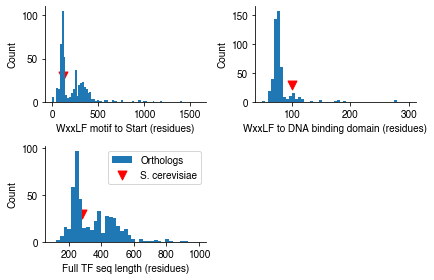

In [15]:
#hist of distances between WxxLF and DBD
#Approx with end of protein
# FullOrthoDF['Spacer'] = FullOrthoDF['DBD_start'] - FullOrthoDF['WxxLF_loc']+6

#leave out the few very long TFs
indx = FullOrthoDF.Length < 1000
print('%i long TFs, >1000 AA are excluded'%sum(FullOrthoDF.Length > 1000))
tempDF = FullOrthoDF#[indx]
plt.subplot(2,2,1)
bins = np.linspace(0,1600,80)
plt.hist(tempDF.WxxLF_loc,bins)
plt.xlabel('WxxLF motif to Start (residues)'),plt.ylabel('Count')
plt.scatter(ScerRow.WxxLF_loc,[30],c='r',s=80,marker='v',label ='S. cerevisiae')
plt.subplot(2,2,2)
bins = np.linspace(50,300,50)
plt.hist(tempDF['WxxLF bZIP distance'],bins)
plt.scatter(ScerRow['WxxLF bZIP distance'],[30],c='r',s=80,marker='v',label ='S. cerevisiae')
plt.xlabel('WxxLF to DNA binding domain (residues)'),plt.ylabel('Count')
plt.subplot(2,2,3)
bins = np.linspace(100,1000,40)
histpair = plt.hist(FullOrthoDF.Length,bins,label='Orthologs')
plt.scatter(ScerRow.Length,[30],c='r',s=80,marker='v',label ='S. cerevisiae')
plt.xlabel('Full TF seq length (residues)'),plt.legend(),plt.ylabel('Count')
# plt.xlim(0,1000)
plt.tight_layout()
plt.rcParams["font.family"] = "Helvetica"
sns.despine()
plt.savefig('Figures/PaperFigs/Supp/DistancesBetweenDBDandMotif.pdf')
plt.show()

# bins = np.linspace(100,1000,40)
# histpair = plt.hist(FullOrthoDF.Length,bins,label='Orthologs')
# plt.scatter([281],[20],c='r',s=80,marker='*',label ='S. cerevisiae')
# plt.xlabel('Full TF seq length'),plt.legend()
# plt.show()


In [7]:
import sparrow
tempSpacer = []
tempRGs, tempEnd2EndDist, temp_scaling_exponent,temp_asphericity = [],[],[],[]
for i, line in FullOrthoDF.iterrows():
    currentSpacerSeq = line.Seq[line.WxxLF_loc+6: line.DBD_start]
    tempSpacer.append(currentSpacerSeq)
    P = sparrow.Protein(currentSpacerSeq)
    tempRGs.append(P.predictor.radius_of_gyration())
    tempEnd2EndDist.append(P.predictor.end_to_end_distance(use_scaled=False))
    temp_scaling_exponent.append(P.predictor.scaling_exponent())
    temp_asphericity.append(P.predictor.asphericity())
FullOrthoDF['SpacerSeq'] = tempSpacer

FullOrthoDF['Spacer_Rg'] = tempRGs
FullOrthoDF['Spacer_End2EndDist'] = tempEnd2EndDist
FullOrthoDF['Spacer_ScalingExp'] = temp_scaling_exponent
FullOrthoDF['Spacer_asphericity'] = temp_asphericity

Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


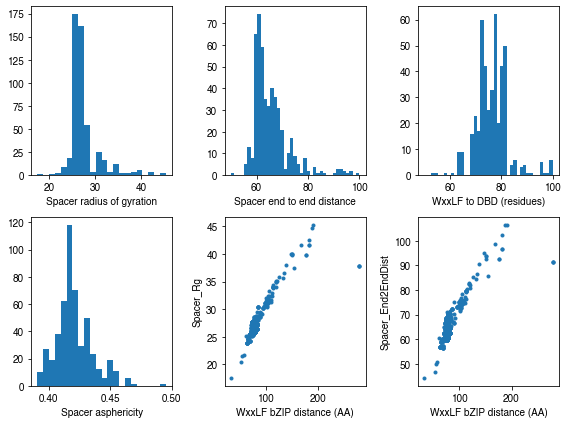

In [8]:
plt.figure(figsize=(8,6))
plt.subplot(2,3,1)
plt.hist(FullOrthoDF.Spacer_Rg,22)
plt.xlabel('Spacer radius of gyration')
plt.subplot(2,3,2)
plt.hist(FullOrthoDF.Spacer_End2EndDist,np.linspace(50,100,40))
plt.xlabel('Spacer end to end distance')
plt.subplot(2,3,3)
# plt.hist(FullOrthoDF.Spacer_ScalingExp,22)
# plt.xlabel('Spacer ScalingExp')
plt.hist(FullOrthoDF['WxxLF bZIP distance'],np.linspace(50,100,40))
plt.xlabel('WxxLF to DBD (residues)')
plt.subplot(2,3,4)
plt.hist(FullOrthoDF.Spacer_asphericity,22)
plt.xlabel('Spacer asphericity')
plt.subplot(2,3,5)
plt.scatter(FullOrthoDF['WxxLF bZIP distance'],FullOrthoDF['Spacer_Rg'],marker='.')
plt.xlabel('WxxLF bZIP distance (AA)'),plt.ylabel('Spacer_Rg')
plt.subplot(2,3,6)
plt.scatter(FullOrthoDF['WxxLF bZIP distance'],FullOrthoDF['Spacer_End2EndDist'],marker='.')
plt.xlabel('WxxLF bZIP distance (AA)'),plt.ylabel('Spacer_End2EndDist')

plt.tight_layout()
plt.savefig('Figures/PaperFigs/Supp/SpacerRG.png')
plt.show()
# FullOrthoDF.plot.scatter(x='WxxLF bZIP distance',y='Spacer_Rg')

In [9]:
ActivityThresh

94031

--
Leotiomycetes_jgi|Oidma1|18868|fgenesh1_kg.6_#_311_#_isotig02349 had no ADs
--
--
Saccharomycotina_jgi|Hanpo2|10524|gm1.4782_g had no ADs
--
Saccharomycotina_jgi|Canca1|23981|e_gw1.2.2068.1 has no active ADs
--
Saccharomycotina_jgi|Canca1|23981|e_gw1.2.2068.1 had no ADs
--
--
Sordariomycetes_jgi|Hypfra2|223471|CE223470_113748 had no ADs
--
--
Sordariomycetes_jgi|Hypfra2|485503|fgenesh1_kg.4_#_1380_#_TRINITY_DN1166_c0_g2_i1 had no ADs
--
[-0.5  0.5  1.5  2.5  3.5 25.5]
(array([  1., 245., 178.,  48.,  30.]), array([-0.5,  0.5,  1.5,  2.5,  3.5, 25.5]), <BarContainer object of 5 artists>)


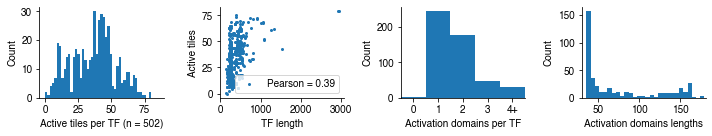

245 TFs have one active AD
291 TFs have one strong AD
1 TFs have no active ADs (or 5 counting another way)
5 TFs have no strong ADs (or 5 counting another way)
245 TFs have only one active AD and it overlaps the WxxLF motif
292 TFs have only one strong AD and it overlaps the WxxLF motif
High activity threshold: 150000 	 Activity threshold 94031


In [10]:
# for each TF how many active tiles?
## SLOW
HighActivityThresh = 150000
plothighactive = False 

tempDict ={}
# capture stats about TFs
NumActive,NumHighActive, lengths = [],[],[]
NumADs,NumHighADs =[],[]
NumTFswOneAD,NumTFswOneAD_high,NumTFswZeroAD_high =0,0,0
Collect_list_of_ADs =[]

FullTFSeqDict = dict(zip(FullOrthoDF.SpeciesName,FullOrthoDF.Seq))

#capture ADs that don't overlap the WxxLF motif
plt.figure(figsize=(10,2))
ADseqs, SpeciesNames = [],[]
TileLength = 40
genenames, starts,ends, seqs,regionlengths,regionlengthsHigh,RegionType = [],[],[],[],[],[],[]
SingleADoverlapsWxxLF,SingleADoverlapsWxxLF_Strong =0,0
LengthDict = dict(zip(FullOrthoDF.SpeciesName,FullOrthoDF.Length))
for ii, name in enumerate( set(Orthologs_DF.SpeciesNames)):
    indx = Orthologs_DF.SpeciesNames==name
    
    tempDF = Orthologs_DF[indx] # DF for all tiles for each ortholog
    NumActive.append(sum(tempDF.Activity>ActivityThresh))
    NumHighActive.append(sum(tempDF.Activity>HighActivityThresh))
    lengths.append(LengthDict[name])
    #combine overlapping tiles to estimate number of ADs. 
    tempDF2 = tempDF[tempDF.Activity>ActivityThresh]#active tiles
    tempDF2 = tempDF2.sort_values(by='NativeLocation',ascending=True)
    tempDF2 = tempDF2.reset_index()
    #check if there are no ADs
    if len(tempDF2)==0:
        NumADs.append(0)
        print(name+' has no active ADs')
    else:
        tempNumADs =1
        previousstart = (tempDF2.NativeLocation[0]-19)
        previousend   = (tempDF2.NativeLocation[0]+20)
        for i, entry in tempDF2.iterrows():
            if (entry.NativeLocation-19) < (previousend):
                previousend = entry.NativeLocation+20
#                 if i ==len(tempDF2)-1:
#                     tempADseq = fullseq[previousstart:previousend]
#                     Collect_list_of_ADs.append(tempADseq)
            else:
                starts.append(previousstart)
                ends.append(previousend)
                tempNumADs +=1
                regionlengths.append(previousend-previousstart)
                tempADseq = fullseq[previousstart:previousend]
                Collect_list_of_ADs.append(tempADseq)
                
                #restart
                previousstart = entry.NativeLocation-19
                previousend   = entry.NativeLocation+20
            # get seq of the AD 
            fullseq = FullTFSeqDict[name]
#             tempADseq = fullseq[previousstart:previousend]
#             Collect_list_of_ADs.append(tempADseq)
#           
                # check if it contains WxxLF
#                 re.search()
#                 hits = re.search('W..LF',tempADseq)
#                     if not(hits):
        NumADs.append(tempNumADs)        
    #check if single AD overlaps WxxLF
    if tempNumADs ==1:
        correction = entry.NativeLocation - entry.NormLocation
        if ((previousstart -correction <0 ) & (previousend-correction >0)):
            SingleADoverlapsWxxLF +=1
        else:
            print(name+' has one active AD that does not overlap the WxxLF motif')

    tempDF2 = tempDF[tempDF.Activity>HighActivityThresh]#active tiles
    tempDF2 = tempDF2.sort_values(by='NativeLocation',ascending=True)
    tempDF2 = tempDF2.reset_index()
    starts,ends =[],[]
    #check if there is only one AD
    if len(tempDF2)==0:
        NumTFswZeroAD_high+=1
        print('--\n%s had no ADs\n--'%name)
        NumHighADs.append(0)
    else:
        tempNumADs =1
        previousstart = (tempDF2.NativeLocation[0]-19)
        previousend   = (tempDF2.NativeLocation[0]+20)
        for i, entry in tempDF2.iterrows():
            if (entry.NativeLocation-19) < (previousend):
                previousend = entry.NativeLocation+20
            else:
                starts.append(previousstart)
                ends.append(previousend)
                tempNumADs +=1
                regionlengthsHigh.append(previousend-previousstart)
                previousstart = entry.NativeLocation-19
                previousend   = entry.NativeLocation+20
        NumHighADs.append(tempNumADs)
    #check if single AD overlaps WxxLF
    if tempNumADs ==1:
        correction = entry.NativeLocation - entry.NormLocation
        if ((previousstart -correction <0 ) & (previousend-correction >0)):
            SingleADoverlapsWxxLF_Strong +=1


# nubmer of active tiles   
plt.subplot(1,4,1)
bins = np.linspace(0,85)
plt.hist(NumActive,bins,label='Active')
if plothighactive:
    plt.hist(NumHighActive,bins,alpha = .5,label='Highly Active')
    plt.legend()
plt.xlabel('Active tiles per TF (n = %i)'%len(set(Orthologs_DF.SpeciesNames)))
# plt.xlabel('Active tiles per TF')
plt.ylabel('Count')
# TF length vs number acitve tiles
plt.subplot(1,4,2)
corr = scipy.stats.pearsonr(lengths,NumActive)
plt.scatter(lengths,NumActive,s=4,label = 'Pearson = %.2f'%corr[0])
#corr length
if plothighactive:
    corr2 = scipy.stats.pearsonr(lengths,NumHighActive)
    plt.scatter(lengths,NumHighActive,s=4,alpha=.5,label = 'Highly Active, Corr = %.2f'%corr2[0])
plt.xlabel('TF length'),plt.ylabel('Active tile count')
plt.ylabel('Active tiles')
# plt.text('Corr = %.2f'%corr[0])
plt.legend(loc='lower right')

#number of agragated ADs per TF
plt.subplot(1,4,3)
bins = np.array([-1,0,1,2,3,25])+.5
print(bins)
# plt.hist(NumADs,bins)
x = plt.hist(NumADs,bins)
print(x)
if plothighactive:
    plt.hist(NumHighADs,bins,alpha=.5)

plt.xlabel('Activation domains per TF')
plt.ylabel('Count')
plt.xlim([-0.5,4.5])
plt.xticks([0,1,2,3,4],[0,1,2,3,'4+'])

plt.subplot(1,4,4)
bins = np.linspace(0,200,40)
bins[-1] =2000
plt.hist(regionlengths,bins)
if plothighactive:
    plt.hist(regionlengthsHigh,bins,alpha=.5)
plt.xlim([30,181])
plt.tight_layout()
plt.xlabel('Activation domains lengths')
plt.ylabel('Count')
sns.despine()
plt.savefig('Figures/PaperFigs/ADcounts.pdf')
plt.show()

print('%i TFs have one active AD'%sum(x==1 for x in NumADs))
print('%i TFs have one strong AD'%sum(x==1 for x in NumHighADs))
print('%i TFs have no active ADs (or %i counting another way)'%(sum(x==0 for x in NumADs),NumTFswZeroAD_high))
print('%i TFs have no strong ADs (or %i counting another way)'%(sum(x==0 for x in NumHighADs),NumTFswZeroAD_high))
print('%i TFs have only one active AD and it overlaps the WxxLF motif'%SingleADoverlapsWxxLF)
print('%i TFs have only one strong AD and it overlaps the WxxLF motif'%SingleADoverlapsWxxLF_Strong)
print('High activity threshold: %i \t Activity threshold %i'%(HighActivityThresh, ActivityThresh))

In [11]:
#collect sequences of all active ADs.
NumActive, lengths = [],[]
NumADs =[]
NumTFswOneAD,NumTFswZeroAD_high =0,0
Collect_list_of_ADs =[]

FullTFSeqDict = dict(zip(FullOrthoDF.SpeciesName,FullOrthoDF.Seq))

#capture ADs that don't overlap the WxxLF motif

ADseqs, SpeciesNames = [],[]
TileLength = 40
genenames, starts,ends, regionlengths,regionlengthsHigh,RegionType = [],[],[],[],[],[]
LengthDict = dict(zip(FullOrthoDF.SpeciesName,FullOrthoDF.Length))

for ii, name in enumerate( set(Orthologs_DF.SpeciesNames)):
    indx = Orthologs_DF.SpeciesNames==name #for each ortholog
    
    tempDF = Orthologs_DF[indx] # DF for all tiles for each ortholog
    NumActive.append(sum(tempDF.Activity>ActivityThresh))

    #combine overlapping tiles to estimate number of ADs. 
    tempDF2 = tempDF[tempDF.Activity>ActivityThresh]#active tiles
    tempDF2 = tempDF2.sort_values(by='NativeLocation',ascending=True)
    tempDF2 = tempDF2.reset_index()
    fullseq = FullTFSeqDict[name]
    #check if there are no ADs
    if len(tempDF2)==0:
        NumADs.append(0)
        print(name+' has no active ADs')
    else:
        tempNumADs =1
        previousstart = (tempDF2.NativeLocation[0]-19)
        previousend   = (tempDF2.NativeLocation[0]+20)
        for i, entry in tempDF2.iterrows():
            if (entry.NativeLocation-19) < (previousend):# if current tile overlaps previous end value
                previousend = entry.NativeLocation+20 # update previous end value
#                 if i ==len(tempDF2)-1: # if this is the last tile, record sequence
#                     tempADseq = fullseq[previousstart:previousend+1]
#                     Collect_list_of_ADs.append(tempADseq)
            else: # when the current tiles does not overlap pervious end value
                starts.append(previousstart) #record the start position
                ends.append(previousend) # record the end postion
                tempNumADs +=1 # increment the AD count
                regionlengths.append(previousend-previousstart) #record length of the AD region
                tempADseq = fullseq[previousstart:previousend+1] #find sequence
                Collect_list_of_ADs.append(tempADseq) #record sequence
                
                #restart
                previousstart = entry.NativeLocation-19
                previousend   = entry.NativeLocation+20
            # get seq of the AD 
        # after the last tile, record sequence
        tempADseq = fullseq[previousstart:previousend]
        Collect_list_of_ADs.append(tempADseq)    
            
#             
                # check if it contains WxxLF
#                 re.search()
#                 hits = re.search('W..LF',tempADseq)
#                     if not(hits):
        NumADs.append(tempNumADs)        


Saccharomycotina_jgi|Canca1|23981|e_gw1.2.2068.1 has no active ADs


In [12]:
print(sum(NumADs))

print(len(Collect_list_of_ADs))
# Collect_list_of_ADs

# a =(sum(np.array(NumADs)==1))
# b=(sum(np.array(NumADs)==2))
# c=(sum(np.array(NumADs)==3))
# d =(sum(np.array(NumADs)==4))
# print(a+2*b+3*c+4*d)


915
915


Found ADs by combining tiles
There are 500 ADs with the WxxLF motif
There are 415 ADs without the WxxLF motif


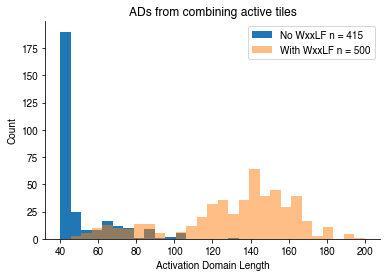

In [13]:
# find the ADs without the WxxLF motif.
ADs_withoutWxxLF = []
ADs_withWxxLF = []
for tempADseq in Collect_list_of_ADs:
    hits = re.search('W..LF',tempADseq)
    if (hits):
        ADs_withWxxLF.append(tempADseq)
    if not(hits):
        ADs_withoutWxxLF.append(tempADseq)
len(ADs_withoutWxxLF)
with open('ExportedSeqLists/ActivationDomainsWithoutWxxLF_Corrected.txt', 'w') as f:
    for line in ADs_withoutWxxLF:
        f.write(f"{line}\n")
with open('ExportedSeqLists/ActivationDomainsWithWxxLF.txt', 'w') as f:
    for line in ADs_withWxxLF:
        f.write(f"{line}\n")
print('Found ADs by combining tiles')
print('There are %i ADs with the WxxLF motif'%len(ADs_withWxxLF))
print('There are %i ADs without the WxxLF motif'%len(ADs_withoutWxxLF))
#export all active tiles without a WxxLF motif.
Tiles_withoutWxxLF ={}
tempDF = masterDF[masterDF[Activity]>ActivityThresh]
for i, row in tempDF.iterrows():
    tempADseq = row.ADseq
    hits = re.search('W..LF',tempADseq)
    if not(hits):
        Tiles_withoutWxxLF[row.Name] = tempADseq
protfasta.write_fasta(Tiles_withoutWxxLF,'ExportedSeqLists/TilesWithoutWxxLF.fasta')


bins = np.linspace(40,200,30)

lengthsNoWxxLF  =[]
for i in ADs_withoutWxxLF:
    lengthsNoWxxLF.append(len(i))
plt.hist(lengthsNoWxxLF,bins,label='No WxxLF n = %i'%len(ADs_withoutWxxLF))
lengths  =[]
for i in ADs_withWxxLF:
    lengths.append(len(i))
plt.hist(lengths,bins,label='With WxxLF n = %i'%len(ADs_withWxxLF),alpha=.5)
plt.legend()
plt.xlabel('Activation Domain Length'),plt.ylabel('Count')
plt.title('ADs from combining active tiles')
sns.despine()
plt.savefig('Figures/Heatmaps/AD_legnths_FromTiles.pdf')
plt.show()

Now look for ADs per TF using the smoothed traces 
There are 332 ADs with the WxxLF motif
There are 783 ADs WITHOUT the WxxLF motif
There are 129 unique ADs with the WxxLF motif
There are 289 unique ADs WITHOUT the WxxLF motif


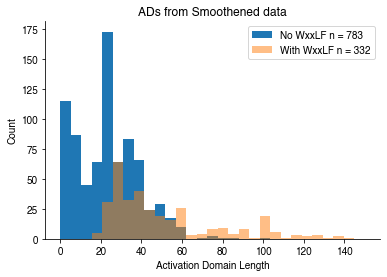

332 TFs have active AD with the WxxLF motif
0 TFs have only one active AD and it overlaps the WxxLF motif


In [14]:
# compute ADs per TF using the smoothed traces
print('Now look for ADs per TF using the smoothed traces ')
HoldADs_wxxLF_seq,HoldADs_wxxLF_name,HoldADs_wxxLF_id =[],[],[]
HoldADs_NOwxxLF_seq,HoldADs_NOwxxLF_name,HoldADs_NOwxxLF_id = [],[],[]
SingleADoverlapsWxxLF =0
LocalActivityThresh = ActivityThresh
for i, row in FullOrthoDF.iterrows():
    tempTrace = row.SmoothedActivitesLoess
    Fullseq = row.Seq
    threshTrace = tempTrace > LocalActivityThresh
    labeledTrace = list(itertools.chain((k * j // 2 for j, (k, g) in enumerate(itertools.groupby(threshTrace), 2) for l in g)))
    labeledTrace = np.array(labeledTrace)
    for j in range(1,max(labeledTrace)+1):
        tempholder =[]
        for k,value in enumerate(labeledTrace):
            if value == j:
                tempholder.append(k)
        tempstart = min(tempholder)
        tempend = max(tempholder)+1
        tempseq = Fullseq[tempstart:tempend]
        
#         if (i >2)&(i<6):
#             print(Fullseq)
#             print('_')
#             print(tempstart)
#             print(tempend)
#             print(tempseq)
#             print('---')
#     hits = re.search(motif,seq)
#             if hits:
    
        if (tempstart<row.WxxLF_loc)&(tempend>(row.WxxLF_loc+4)):
            HoldADs_wxxLF_seq.append(tempseq)
            HoldADs_wxxLF_name.append(row.SpeciesName)
            HoldADs_wxxLF_id.append("%i_%i"%(i,j))
        else:
            HoldADs_NOwxxLF_seq.append(tempseq)
            HoldADs_NOwxxLF_name.append(row.SpeciesName)
            HoldADs_NOwxxLF_id.append("%i_%i"%(i,j))
         #check if single AD overlaps WxxLF
        if tempNumADs ==1:
            correction = entry.NativeLocation - entry.NormLocation
            if ((previousstart -correction <0 ) & (previousend-correction >0)):
                SingleADoverlapsWxxLF +=1
print('There are %i ADs with the WxxLF motif'%len(HoldADs_wxxLF_seq))

print('There are %i ADs WITHOUT the WxxLF motif'%len(HoldADs_NOwxxLF_seq))

print('There are %i unique ADs with the WxxLF motif'%len(set(HoldADs_wxxLF_seq)))

print('There are %i unique ADs WITHOUT the WxxLF motif'%len(set(HoldADs_NOwxxLF_seq)))
bins = np.linspace(0,150,30)
lengthsNoWxxLF  =[]
for i in HoldADs_NOwxxLF_seq:
    lengthsNoWxxLF.append(len(i))
plt.hist(lengthsNoWxxLF,bins,label='No WxxLF n = %i'%len(HoldADs_NOwxxLF_seq))
lengths  =[]
for i in HoldADs_wxxLF_seq:
    lengths.append(len(i))
plt.hist(lengths,bins,label='With WxxLF n = %i'%len(HoldADs_wxxLF_seq),alpha=.5)
plt.legend()
plt.xlabel('Activation Domain Length'),plt.ylabel('Count')
plt.title('ADs from Smoothened data')
sns.despine()
plt.savefig('Figures/Heatmaps/AD_legnths_InHeatMaps.pdf')
plt.show()

NonWxxLFADs_DF = pd.DataFrame({'SpeciesName':HoldADs_NOwxxLF_name, 'Seq':HoldADs_NOwxxLF_seq,'ID':HoldADs_NOwxxLF_id,'Length':lengthsNoWxxLF})
NonWxxLFADs_DF['Species_ID']=NonWxxLFADs_DF.SpeciesName+NonWxxLFADs_DF.ID
exportfilename = 'ExportedSeqLists/SmoothedData_ADs/ADs_without_WxxLF_FromSmoothedData_Thresh%i.fasta'%ActivityThresh
tempDict = dict(zip(NonWxxLFADs_DF.Species_ID,NonWxxLFADs_DF.Seq))
protfasta.write_fasta(tempDict,exportfilename)

tempDF = NonWxxLFADs_DF[NonWxxLFADs_DF.Length>10]
exportfilename = 'ExportedSeqLists/SmoothedData_ADs/ADs_without_WxxLF_FromSmoothedData_Thresh%i_longer.fasta'%ActivityThresh
tempDict = dict(zip(tempDF.Species_ID,tempDF.Seq))
protfasta.write_fasta(tempDict,exportfilename)

WxxLFADs_DF = pd.DataFrame({'SpeciesName':HoldADs_wxxLF_name, 'Seq':HoldADs_wxxLF_seq,'ID':HoldADs_wxxLF_id,'Length':lengths})
WxxLFADs_DF['Species_ID']=WxxLFADs_DF.SpeciesName+WxxLFADs_DF.ID
exportfilename = 'ExportedSeqLists/SmoothedData_ADs/ADs_with_WxxLF_FromSmoothedData_Thresh%i.fasta'%ActivityThresh
tempDict = dict(zip(WxxLFADs_DF.Species_ID,WxxLFADs_DF.Seq))
protfasta.write_fasta(tempDict,exportfilename)

print('%i TFs have active AD with the WxxLF motif'%len(set(HoldADs_wxxLF_name)))
print('%i TFs have only one active AD and it overlaps the WxxLF motif'%SingleADoverlapsWxxLF)


In [15]:
temp = FullOrthoDF[FullOrthoDF.SpeciesName=='Saccharomycotina_jgi|Canca1|23981|e_gw1.2.2068.1']
print(max(max(temp.SmoothedActivites)))
temp

45818.94247955396


SpeciesName  \
225  Saccharomycotina_jgi|Canca1|23981|e_gw1.2.2068.1   

                                                   Seq  Length  WxxLF_loc  \
225  MWQSLFPEWSESSEPKQDKDDVTSEVADRRCKSTSDSQDVYDKPGE...     162          1   

                                     SmoothedActivites  \
225  [34438.72250577401, 34438.72250577401, 34438.7...   

                                          LinearCharge  \
225  [0.0, 0.0, 0.0, 0.0, 0.0, -0.2, -0.2, -0.2, -0...   

                                LinearHydrophobicityKD  \
225  [0.0, 0.0, 0.5111111111111112, 0.5311111111111...   

                                SmoothedActivitesLoess  \
225  [32368.834942865782, 32368.834942865782, 32368...   

                                              Disorder  DBD_start  DBD_end  \
225  [0.8861, 0.9192, 0.8819, 0.8674, 0.8277, 0.820...        110      162   

     WxxLF bZIP distance                                          SpacerSeq  \
225                104.0  EWSESSEPKQDKDDVTSEVADRRCKSTSDSQDVYDKPGESESPERT...   

     Spacer_Rg  Spacer_End2EndDist  Spacer_ScalingExp  Spacer_asphericity  
225   31.14879            72.72303           0.534783            0.412415

In [16]:
# How many of the TFs have an AD
print('There are %i TFs '% len(Orthologs_DF.SpeciesNames.unique()))
thresholds = [20,40 ,70,75,80,85,90,95]#,97,99]
for quantile in thresholds:
    thresh = masterDF[Activity].quantile(quantile/100.0)
    counter = 0
    for j, species in enumerate(Orthologs_DF.SpeciesNames.unique()):
        indx = (Orthologs_DF.SpeciesNames==species)
        tempDF = Orthologs_DF[indx]
        indx = tempDF.Activity>thresh
        if sum(indx)>0:
            counter+=1
#         else:
#             print('\t'+ species)
    print('At a threshold of %i (%ith percentile), %i TFs have an AD, %.1f percent'%(thresh,quantile,counter,100.0*counter/(j+1)))
    


There are 502 TFs 
At a threshold of 21932 (20th percentile), 502 TFs have an AD, 100.0 percent
At a threshold of 34352 (40th percentile), 502 TFs have an AD, 100.0 percent
At a threshold of 67210 (70th percentile), 502 TFs have an AD, 100.0 percent
At a threshold of 77297 (75th percentile), 502 TFs have an AD, 100.0 percent
At a threshold of 94031 (80th percentile), 501 TFs have an AD, 99.8 percent
At a threshold of 120506 (85th percentile), 501 TFs have an AD, 99.8 percent
At a threshold of 164610 (90th percentile), 496 TFs have an AD, 98.8 percent
At a threshold of 226894 (95th percentile), 492 TFs have an AD, 98.0 percent


In [17]:
#find the two alternative gene models
name = 'Saccharomycotina_jgi|Canca1|23981|e_gw1.2.2068.1'
indx = Orthologs_DF.SpeciesNames ==name
print('%s has %f MAX activity'% (name, max(Orthologs_DF[indx]['Activity'])))

name = 'Saccharomycotina_jgi|Canca1|57326|fgenesh1_pm.2_#_827'
indx = Orthologs_DF.SpeciesNames ==name
print('%s has %f MAX activity'% (name, max(Orthologs_DF[indx]['Activity'])))
print(sum(Orthologs_DF[indx]['Activity']>ActivityThresh))

Saccharomycotina_jgi|Canca1|23981|e_gw1.2.2068.1 has 86608.934889 MAX activity
Saccharomycotina_jgi|Canca1|57326|fgenesh1_pm.2_#_827 has 261977.090182 MAX activity
6


In [18]:
# # Export TFs with one AD or 2 ADs for Sathvik
# FullOrthoDF['NumADs']=NumADs
# # FullOrthoDF['NumStrongADs']=NumHighADs

# # col = 'NumStrongADs'
# col = 'NumADs'
# for i in range(0,max(FullOrthoDF[col])):
#     indx =FullOrthoDF[col]==i
#     print('%i species have %i ADs'%(sum(indx),i))
#     tempDF  = FullOrthoDF[indx]
#     exportfilename = 'ExportedSeqLists/NumberOfADs/Full_Orthologs_with_One_Strong_AD_%i.fasta'%i
#     tempDict = dict(zip(tempDF.SpeciesName,tempDF.Seq))
#     protfasta.write_fasta(tempDict,exportfilename)

In [19]:
print(NonWxxLFADs_DF.shape)
len(set(NonWxxLFADs_DF.SpeciesName))

(783, 5)


391

In [14]:
# add another column to sort the dataframe
tempCol,Xs =[],[]
for i, row in FullOrthoDF.iterrows():
    temp = row.SmoothedActivitesLoess[row.WxxLF_loc]
    tempCol.append(temp)
    tempX =(np.arange(0,(row.SmoothedActivitesLoess.shape[0])))
    tempX = tempX-row.WxxLF_loc
    Xs.append(tempX)
FullOrthoDF['Activity_at_WxxLF']=tempCol
FullOrthoDF['CenteredXpos'] = Xs

tempCol,tempCol2,tempCol3 =[],[],[]
for i, row in FullOrthoDF.iterrows():
    temp = row.SmoothedActivitesLoess[row.WxxLF_loc+20]
    tempCol.append(temp)
    temp = row.SmoothedActivitesLoess[row.WxxLF_loc-20]
    tempCol2.append(temp)
    temp = row.SmoothedActivitesLoess[row.WxxLF_loc-10]
    tempCol3.append(temp)
FullOrthoDF['Activity_at_WxxLF_plus20']=tempCol
FullOrthoDF['Activity_at_WxxLF_minus20']=tempCol2
FullOrthoDF['Activity_at_WxxLF_minus10']=tempCol3

tempCol =[]
plusX, minusX = 10,10
for i, row in FullOrthoDF.iterrows():
    start = max(0,row.WxxLF_loc-minusX)
    end   = row.WxxLF_loc+plusX
    temp = row.SmoothedActivitesLoess[start:end]
    tempCol.append(sum(temp)/(plusX+minusX))
FullOrthoDF['IntegralAround_WxxLF']=tempCol


# 20230802 I noticed that the peak of heatmap is actually at -10, which is hte center of the altCAAD
tempCol,tempCol2 =[],[]
for i, row in FullOrthoDF.iterrows():
    temp = row.SmoothedActivitesLoess[row.WxxLF_loc+10]
    tempCol.append(temp)
    temp = row.SmoothedActivitesLoess[row.WxxLF_loc-10]
    tempCol2.append(temp)
FullOrthoDF['Activity_at_WxxLF_plus10']=tempCol
FullOrthoDF['Activity_at_WxxLF_minus10']=tempCol2

<AxesSubplot:ylabel='Frequency'>

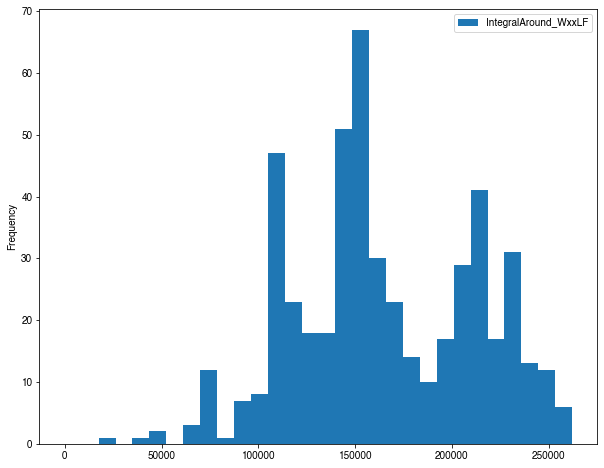

In [15]:
# plt.hist(FullOrthoDF['IntegralAround_WxxLF'],50)
FullOrthoDF.plot.hist(column= 'IntegralAround_WxxLF',figsize=(10, 8),bins=30)


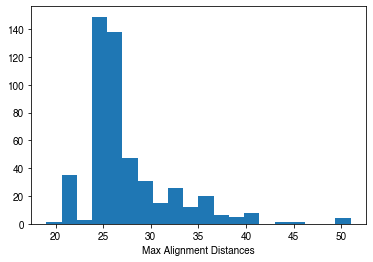

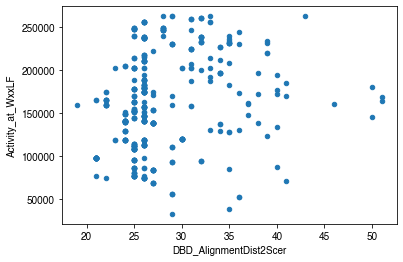

(0.23880096897393627, 6.107377023553799e-08)


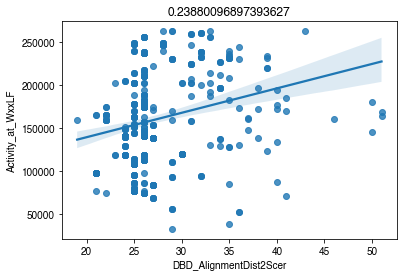

In [22]:
# alignment distance vs activity difference 

tempCol =[]
for i, tf in FullOrthoDF.iterrows():
    tempDBD = tf.Seq[tf["DBD_start"]:tf["DBD_end"]]
    tempAlignmnet = pairwise2.align.localxx(tempDBD,ScerDBD)
    tempScores =[]
    for alignment in tempAlignmnet: 
        tempScores.append(alignment[2])
    tempCol.append(max(tempScores))
plt.hist(tempCol,20)
plt.xlabel('Max Alignment Distances')
plt.show()
FullOrthoDF['DBD_AlignmentDist2Scer']=tempCol

FullOrthoDF.plot.scatter(x='DBD_AlignmentDist2Scer',y= 'Activity_at_WxxLF')
plt.savefig('Figures/PaperFigs/AlignmentDistOfDBD_NotCorrelatedWithActivity.pdf')
plt.show()
corr = scipy.stats.pearsonr( FullOrthoDF['DBD_AlignmentDist2Scer'],FullOrthoDF['Activity_at_WxxLF'])
print(corr)
sns.regplot(x='DBD_AlignmentDist2Scer',y= 'Activity_at_WxxLF',data=FullOrthoDF)
plt.title(corr[0])
plt.savefig('Figures/PaperFigs/AlignmentDistOfDBD_NotCorrelatedWithActivity_regressionline.pdf')
plt.show()

In [23]:
print(scipy.stats.pearsonr( FullOrthoDF['DBD_AlignmentDist2Scer'],FullOrthoDF['Activity_at_WxxLF_minus10']))
print(scipy.stats.pearsonr( FullOrthoDF['DBD_AlignmentDist2Scer'],FullOrthoDF['Activity_at_WxxLF']))
print(scipy.stats.pearsonr( FullOrthoDF['DBD_AlignmentDist2Scer'],FullOrthoDF['Activity_at_WxxLF_plus10']))

(-0.25023653931966117, 1.3209772736757762e-08)
(0.23880096897393627, 6.107377023553799e-08)
(0.26615972209201955, 1.3769423838663657e-09)


In [24]:
#Export Data for manuscript
 
FullOrthoDF.to_csv('Figures/PaperFigs/Supp/Table_S7_Full_length_ortholog_dataframe.csv')
Orthologs_DF.to_csv('Figures/PaperFigs/Supp/Table_S6_Ortholog_Tile_dataframe.csv')

In [25]:
# FullOrthoDF.to_csv('../Data/Processed/FullLengthOrthologs_ExportExtraColumns_20241002.csv')
FullOrthoDF.shape

(502, 25)

In [25]:
# plot smoothed activity as a heatmap

def plotFullLengthOrthologHeatMap(tempDF, Property,ZoomCenter=False,colormapname='Purples',AlignonDBD=False,OtherFileNameData='',YZoom=False,showWxxLFIntegralRegion=False):
    indx = max(tempDF.Length)==tempDF.Length
#     CenterPosition = int(tempDF[indx]['WxxLF_loc'])
    maxLength = int(tempDF[indx]['Length'])
    maxLength = maxLength+200
    CenterPosition = maxLength-300
    print(maxLength)
#     indx = (FullOrthoDF.Length < 900)#&(FullOrthoDF.Length >476)
    print('%i Orthologs are plotted'%len(tempDF))
#     indx = (FullOrthoDF.Length < 600)&(FullOrthoDF['Activity_at_WxxLF']< 90000)&(FullOrthoDF['Activity_at_WxxLF']>81000)
    heatmapMatrix = np.zeros((len(tempDF),maxLength))
    tempDF = tempDF.reset_index()
    ScerLocation =0
    for i, row in tempDF.iterrows():
        tempLen = len(row.Seq)
        # align on WxxLF motif
        if AlignonDBD:
            start = CenterPosition+200-row.DBD_start
            end = CenterPosition+200+tempLen - row.DBD_start
        else:
            start = CenterPosition-row.WxxLF_loc
            end = CenterPosition+tempLen - row.WxxLF_loc
        # find and remember the Scer species line
        if row.Seq == ScerWTseq:
            ScerLocation =i
    #     #align on end of protein
    #     start =maxLength - tempLen
    #     end = maxLength
        heatmapMatrix[i,start:end] = np.array(row[Property])
    print('Scer is on line %i'%ScerLocation)
    if YZoom:
        plt.figure(figsize=(15,4))
    else:
        plt.figure(figsize=(15,15))
    if Property in[ 'SmoothedActivites','SmoothedActivitesLoess']:
        ax = sns.heatmap(heatmapMatrix,cmap=colormapname, vmin=minActivity, vmax=maxActivity,xticklabels=100, yticklabels=False,
                        cbar_kws={'label': 'Activity'})#,xlabel='Position')
#     cbar = plt.colorbar(ax,shrink=1, aspect=20,label= Property)
    
    elif Property =='LinearCharge':
        ax = sns.heatmap(-1*heatmapMatrix,cmap='bwr', xticklabels=100, yticklabels=False,cbar_kws={'label': 'Charge'})
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([-1, 0, 1])
        cbar.set_ticklabels(['+1','0','-1'])
        colormapname = 'bwr'
        
    else:
        ax = sns.heatmap(heatmapMatrix,cmap='Greens', xticklabels=100, yticklabels=False,cbar_kws={'label': Property})
        colormapname = 'Greens'
    # mark the Scer species line
    if not(YZoom):
        ax.scatter([820],[ScerLocation],c='r',marker=">")
    #scalebar
    ax.plot([0,100],[len(tempDF)/2,len(tempDF)/2],c='k',)
    if AlignonDBD == True: #added 20240403
#         ax.set_xticks([800],labels=['DBD'])
        plt.xticks([CenterPosition+200],labels=['DBD'])
    else:
#         ax.set_xticks([500],labels=['WxxLF'])
        plt.xticks([CenterPosition-200,CenterPosition,CenterPosition+200],labels=['-200 AA','WxxLF','+200 AA'])
    
    # Zoom in option
    text4 = ''
    if ZoomCenter:
        plt.xlim(400,600)
        text4 = 'Zoom'
    if AlignonDBD == True:
        text2 = 'AlignOnDBD'
    else:
        text2 = 'AlignOnWxxLF'
    if YZoom:
#         plt.ylim(400,600)
        text4 = 'YaxisZoom'
    #show the location of the CAAD region
    if showWxxLFIntegralRegion:
        plt.plot([CenterPosition-50,CenterPosition+20],[i+1,i+1],c=darkgreen,lw=4)
#     if not(AlignonDBD):
#         plt.plot([CenterPosition-50,CenterPosition+20],[i+2,i+2],c=darkgreen,lw=5)

    figname = 'Figures/Heatmaps/HM_%s_%s_%s_%s_%s'%(Property,text2,colormapname,text4,OtherFileNameData)#fix this
    plt.savefig(figname+'.png', dpi=300)
#     plt.savefig(figname+'.pdf')
    plt.show()
    
    # Find the sum of the heatmap
#     plt.plot(np.mean(heatmapMatrix,axis=0)), #this may average in the zeros
    sums = np.mean(heatmapMatrix,axis=0)
    peakpos = sums[sums==max(sums)]
    temp = list(sums==max(sums))
    peakval= temp.index(True)
    print("The peak of the sum is at %i"%peakval)
    print("The sum of the peak is %i"%peakpos )  

    # plot the sum of the heatmap, removing zeros
    heatmapMatrix[heatmapMatrix == 0] = np.nan # 20240726
    plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726
    
    if ZoomCenter:
        plt.xlim(400,600)
    plt.xlabel('Position'),
    if (Property =='SmoothedActivitesLoess'):
        plt.ylabel('Activity (Loess Smoothing)'),
    else:
        plt.ylabel(Property),
    if AlignonDBD == True:
        plt.plot([CenterPosition+200,CenterPosition+200],[0,max(sums)],c='gray')
        plt.xticks([CenterPosition+200],labels=['DBD'])
#         plt.yticks()
#         plt.yticks([min(heatmapMatrix.all()),max(heatmapMatrix.all())])
    else:
        plt.plot([CenterPosition,CenterPosition],[0,max(sums)],c='gray')
        plt.xticks([CenterPosition],labels=['WxxLF'])
#         plt.yticks([])
#         plt.yticks([min(heatmapMatrix.all()),max(heatmapMatrix.all())])
    plt.tight_layout()
    sns.despine()
    plt.savefig(figname+'_Sum.pdf')
    plt.show()
    
    return heatmapMatrix


In [17]:
temp = FullOrthoDF.sort_values(by = 'Length',ascending=False)
temp[['SpeciesName','Length']][:10]

SpeciesName  Length
5     Sordariomycetes_jgi|Acral2|2047914|estExt_Gene...    2943
0         Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g    2928
49    Pezizomycetes_jgi|Ascni1|352744|fgenesh1_pg.76...    1543
1014         Xylonomycetes_jgi|Trigu1|1079454|gm1.247_g    1328
1103          Xylonomycetes_jgi|Xylhe1|264767|gm1.473_g    1255
292   Sordariomycetes_jgi|Daces1|522128|fgenesh1_pg....    1098
291   Sordariomycetes_jgi|Daces1|604900|estExt_fgene...    1080
744   Sordariomycetes_jgi|OphPMI507_1|434063|gm1.8796_g    1066
549   Sordariomycetes_jgi|Lasov1|716087|estExt_Genem...    1064
548        Sordariomycetes_jgi|Lasov1|674147|gm1.2096_g    1010

1298
497 Orthologs are plotted
Scer is on line 227


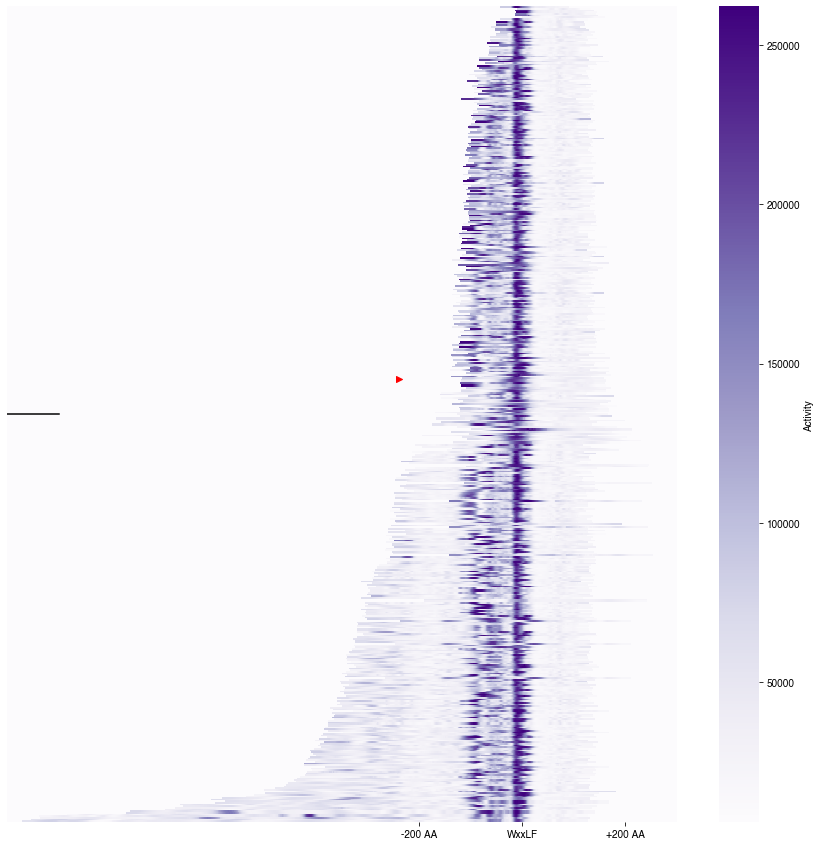

The peak of the sum is at 988
The sum of the peak is 216866


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_30629/1431872385.py:98: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


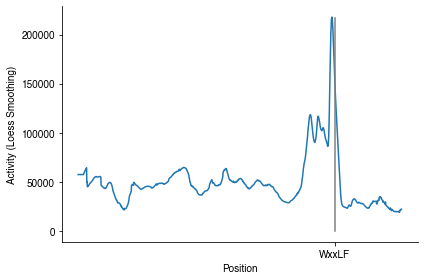

The orthologs are sorted by length. They are aligned by the location of the WxxLF motif (500). This figure excludes the 26 TFs longer than 600AA


In [18]:
indx = (FullOrthoDF.Length < 1100)
Long = FullOrthoDF[indx]
tempDF = Long.sort_values(by = 'Length',ascending=True)
# LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivites')
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',OtherFileNameData='LongTFs')
# Disorder = plotFullLengthOrthologHeatMap(tempDF,'Disorder',AlignonDBD=False)
print('The orthologs are sorted by length. They are aligned by the location of the WxxLF motif (500). This figure excludes the 26 TFs longer than 600AA')


1298
120 Orthologs are plotted
Scer is on line 27


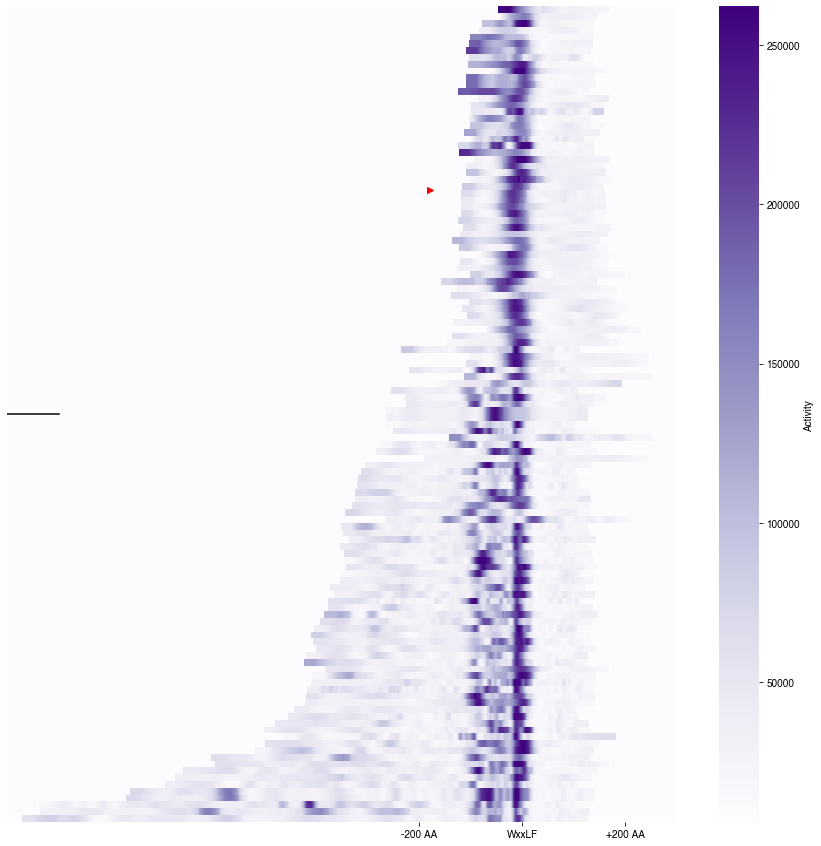

The peak of the sum is at 988
The sum of the peak is 200880


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_30629/445841470.py:98: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


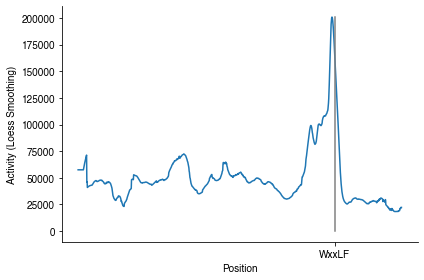

The orthologs are sorted by length. They are aligned by the location of the WxxLF motif (500). This figure excludes the 26 TFs longer than 600AA


In [26]:
#load in the reduced set of homologs, one per speceis
# PrunedOrthologlist = pd.read_csv('../Data/GeanClairePrunedOrthologs/top138_phyloinfo_Gean_Claire_Summer2025pruned.csv')
PrunedOrthologlist = protfasta.read_fasta('../Data/GeanClairePrunedOrthologs/longest_gene_per_species.fasta')
tempDF = pd.Series(PrunedOrthologlist)

indx = []

for i in FullOrthoDF.SpeciesName.values:
    if i in tempDF.index.values:
        indx.append(True)

    else:
        indx.append(False)
FullOrthoDF_pruned = FullOrthoDF[indx]

indx = (FullOrthoDF_pruned.Length < 1100)
Long = FullOrthoDF_pruned[indx]
tempDF = Long.sort_values(by = 'Length',ascending=True)
# LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivites')
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',OtherFileNameData='PrunedTFList_long')
# Disorder = plotFullLengthOrthologHeatMap(tempDF,'Disorder',AlignonDBD=False)
print('The orthologs are sorted by length. They are aligned by the location of the WxxLF motif (500). This figure excludes the 26 TFs longer than 600AA')




750
125 Orthologs are plotted
Scer is on line 90


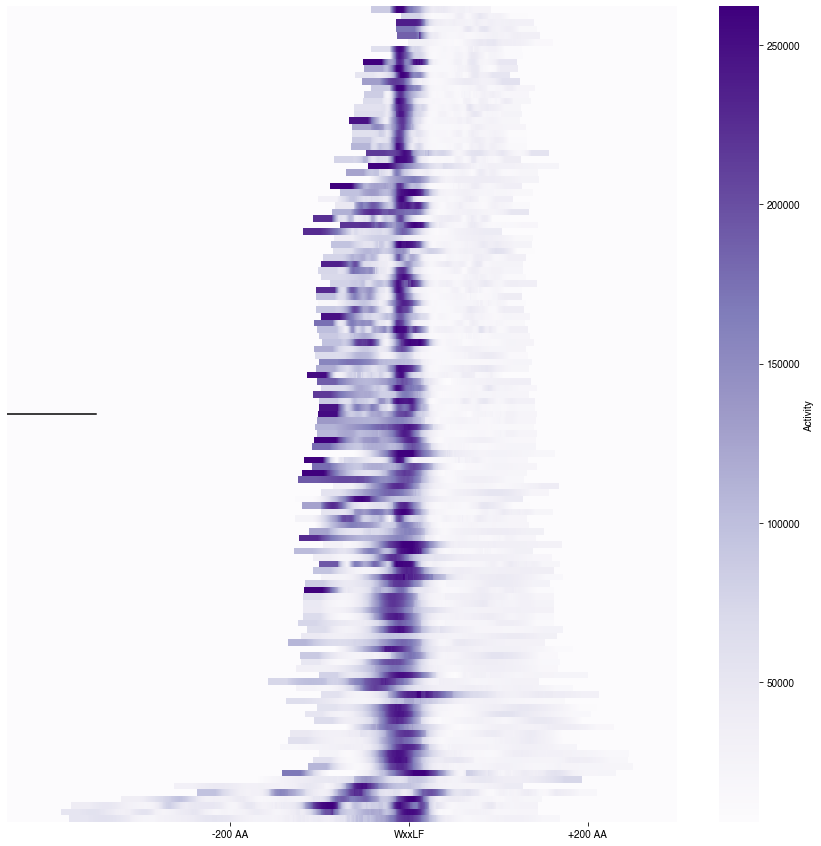

The peak of the sum is at 441
The sum of the peak is 199733


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_30629/1431872385.py:98: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


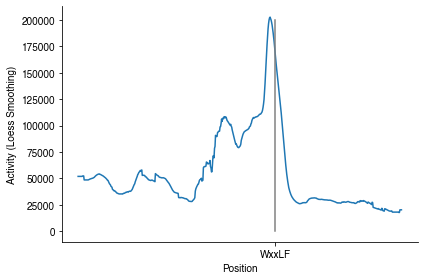

The orthologs are sorted by length. They are aligned by the location of the WxxLF motif (500). This figure excludes the 26 TFs longer than 600AA


In [21]:
#load in the reduced set of homologs, one per speceis
# PrunedOrthologlist = pd.read_csv('../Data/GeanClairePrunedOrthologs/top138_phyloinfo_Gean_Claire_Summer2025pruned.csv')
PrunedOrthologlist = protfasta.read_fasta('../Data/GeanClairePrunedOrthologs/shortest_gene_per_species.fasta')
tempDF = pd.Series(PrunedOrthologlist)

indx = []

for i in FullOrthoDF.SpeciesName.values:
    if i in tempDF.index.values:
        indx.append(True)

    else:
        indx.append(False)
FullOrthoDF_pruned = FullOrthoDF[indx]

indx = (FullOrthoDF_pruned.Length < 1100)
Long = FullOrthoDF_pruned[indx]
tempDF = Long.sort_values(by = 'Length',ascending=True)
# LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivites')
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',OtherFileNameData='PrunedTFList_shortest')
# Disorder = plotFullLengthOrthologHeatMap(tempDF,'Disorder',AlignonDBD=False)
print('The orthologs are sorted by length. They are aligned by the location of the WxxLF motif (500). This figure excludes the 26 TFs longer than 600AA')




1210
135 Orthologs are plotted
Scer is on line 72


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_73830/1244665103.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF_pruned['Activity_at_WxxLF']=tempCol


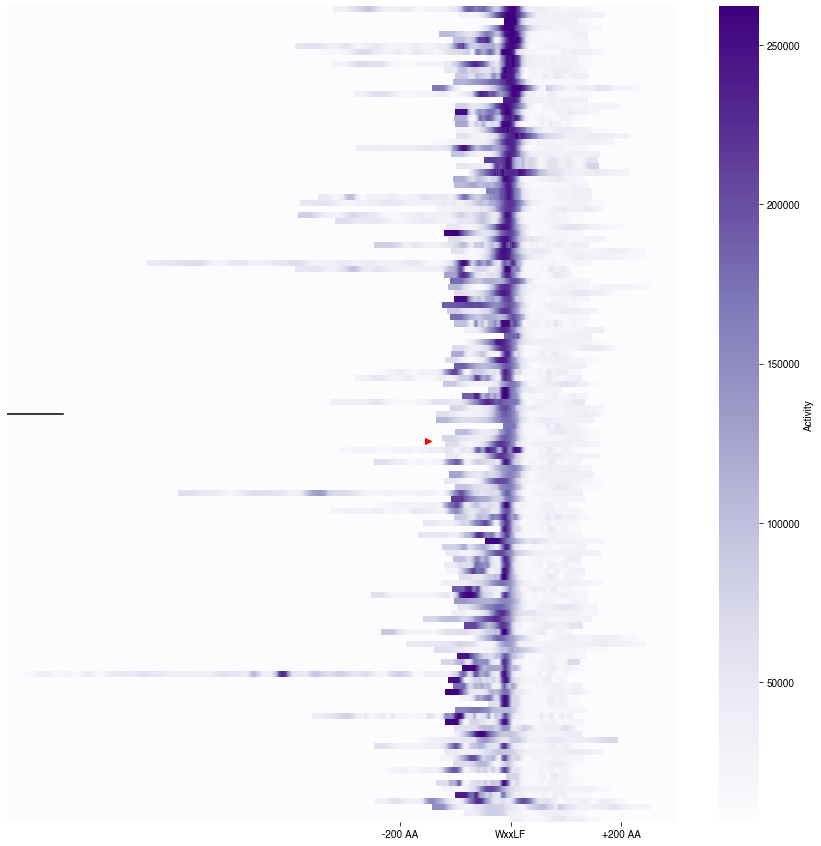

The peak of the sum is at 901
The sum of the peak is 201313


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_73830/1431872385.py:98: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


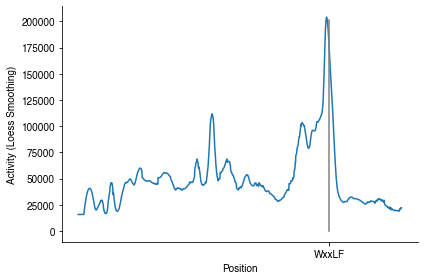

In [11]:
tempCol,Xs =[],[]
for i, row in FullOrthoDF_pruned.iterrows():
    temp = row.SmoothedActivitesLoess[row.WxxLF_loc]
    tempCol.append(temp)
    tempX =(np.arange(0,(row.SmoothedActivitesLoess.shape[0])))
    tempX = tempX-row.WxxLF_loc
    Xs.append(tempX)
FullOrthoDF_pruned['Activity_at_WxxLF']=tempCol

indx = (FullOrthoDF_pruned.Length < 1100)
Long = FullOrthoDF_pruned[indx]
tempDF = Long.sort_values(by = 'Activity_at_WxxLF',ascending=False)
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',OtherFileNameData='SortOnWxxLFAct_PrunedTFList')


790
476 Orthologs are plotted
Scer is on line 232


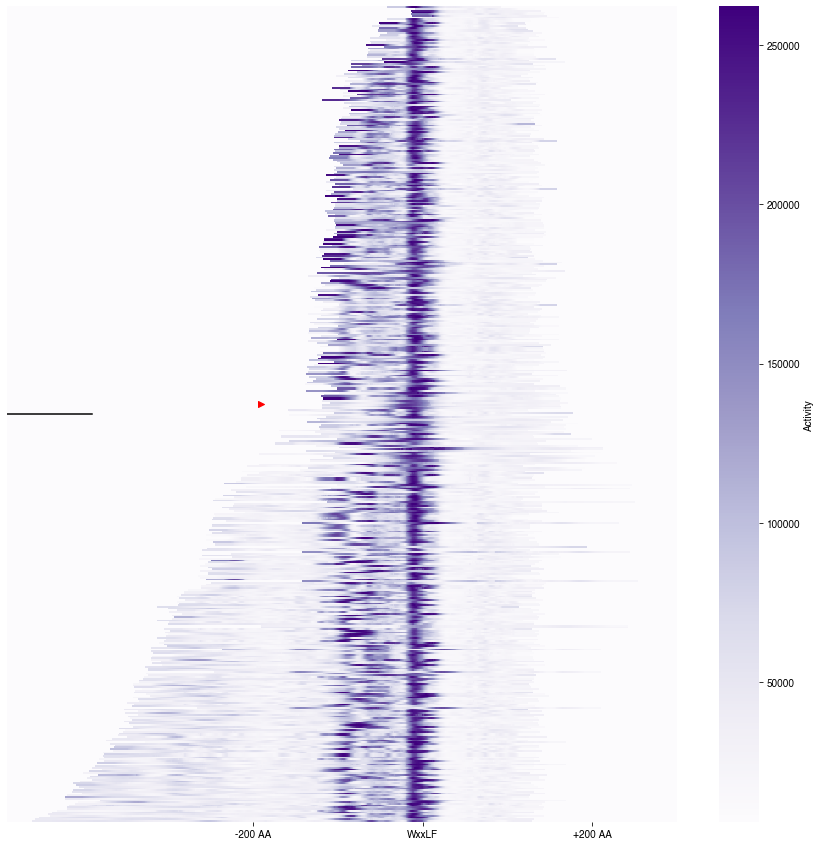

The peak of the sum is at 480
The sum of the peak is 216580


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_23768/2901517588.py:98: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


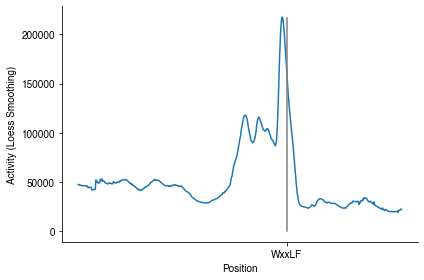

The orthologs are sorted by length. They are aligned by the location of the WxxLF motif (500). This figure excludes the 26 TFs longer than 600AA


In [30]:
indx = (FullOrthoDF.Length < 600)
ShortMedTFs = FullOrthoDF[indx]
tempDF = ShortMedTFs.sort_values(by = 'Length',ascending=True)
# LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivites')
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess')
# Disorder = plotFullLengthOrthologHeatMap(tempDF,'Disorder',AlignonDBD=False)
print('The orthologs are sorted by length. They are aligned by the location of the WxxLF motif (500). This figure excludes the 26 TFs longer than 600AA')

790
476 Orthologs are plotted
Scer is on line 232


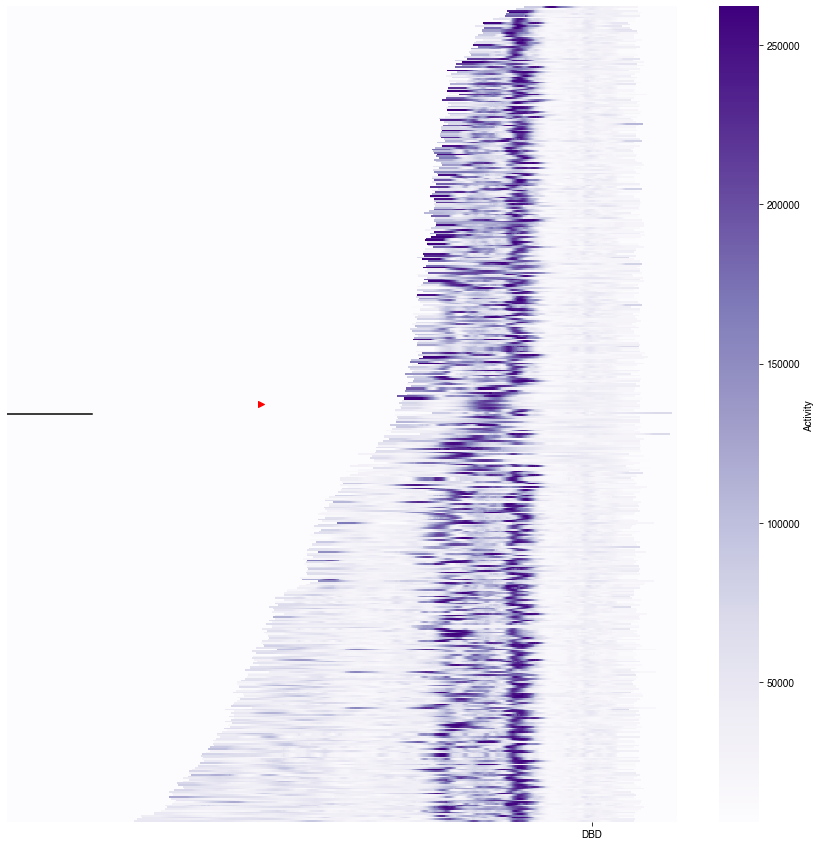

The peak of the sum is at 600
The sum of the peak is 175492


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_23768/2901517588.py:98: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


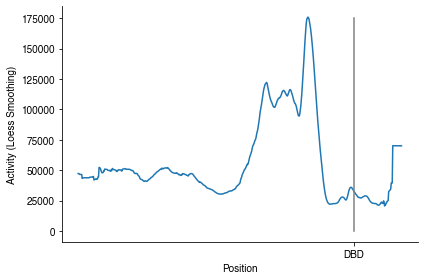

790
476 Orthologs are plotted
Scer is on line 232


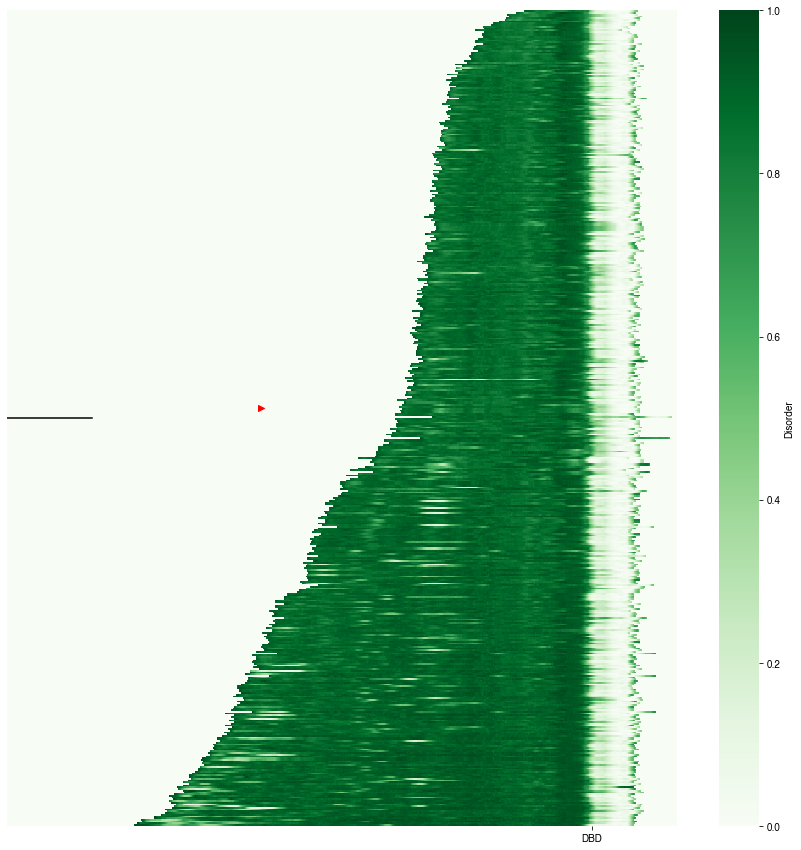

The peak of the sum is at 656
The sum of the peak is 0


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_23768/2901517588.py:98: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


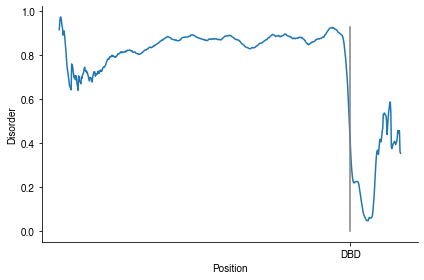

The orthologs are sorted by length. They are aligned by the location of the WxxLF motif (500). This figure excludes the 26 TFs longer than 600AA


In [31]:
indx = (FullOrthoDF.Length < 600)
ShortMedTFs = FullOrthoDF[indx]
tempDF = ShortMedTFs.sort_values(by = 'Length',ascending=True, )
# LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivites')
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',AlignonDBD=True)
Disorder = plotFullLengthOrthologHeatMap(tempDF,'Disorder',AlignonDBD=True)
print('The orthologs are sorted by length. They are aligned by the location of the WxxLF motif (500). This figure excludes the 26 TFs longer than 600AA')


790
476 Orthologs are plotted
Scer is on line 232


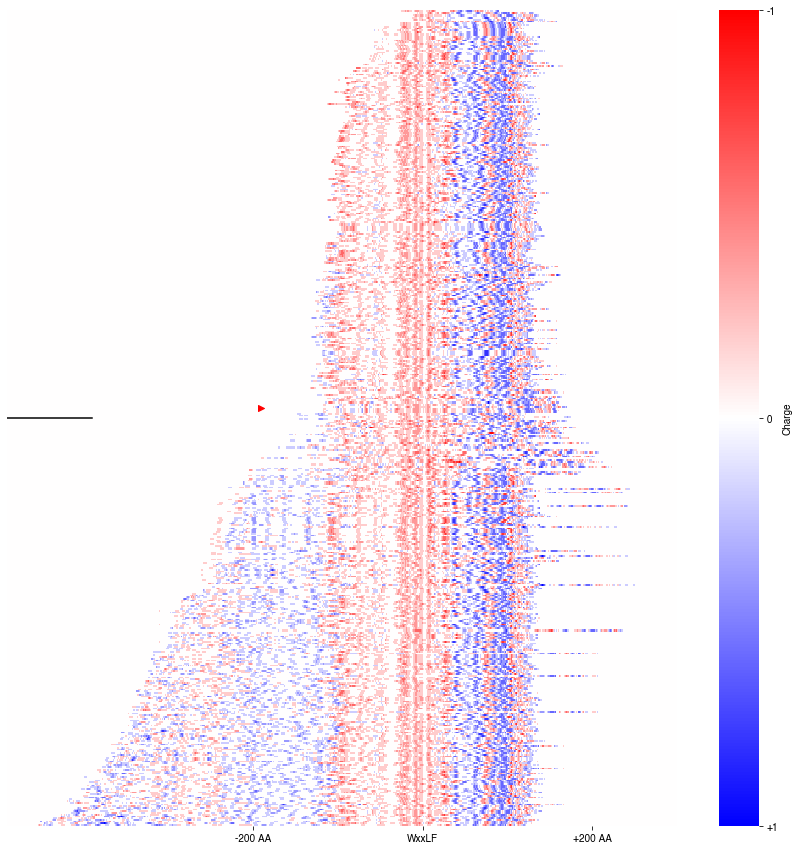

The peak of the sum is at 583
The sum of the peak is 0


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_23768/2901517588.py:98: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


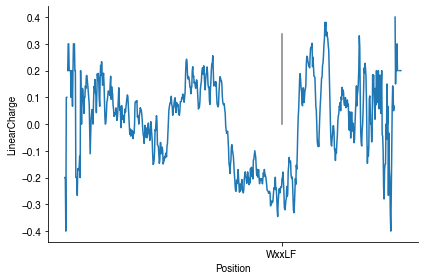

790
476 Orthologs are plotted
Scer is on line 232


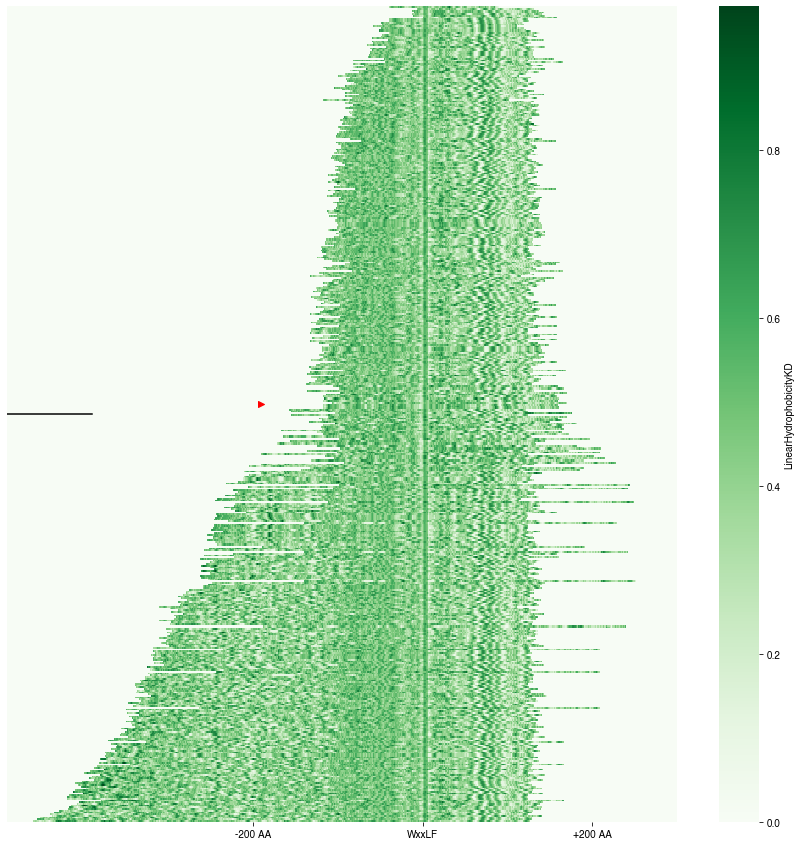

The peak of the sum is at 492
The sum of the peak is 0


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_23768/2901517588.py:98: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


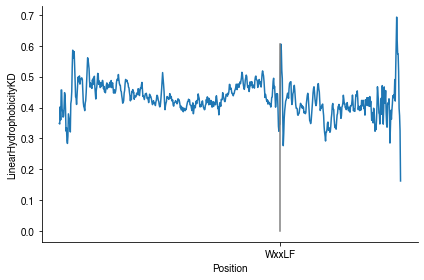

790
476 Orthologs are plotted
Scer is on line 232


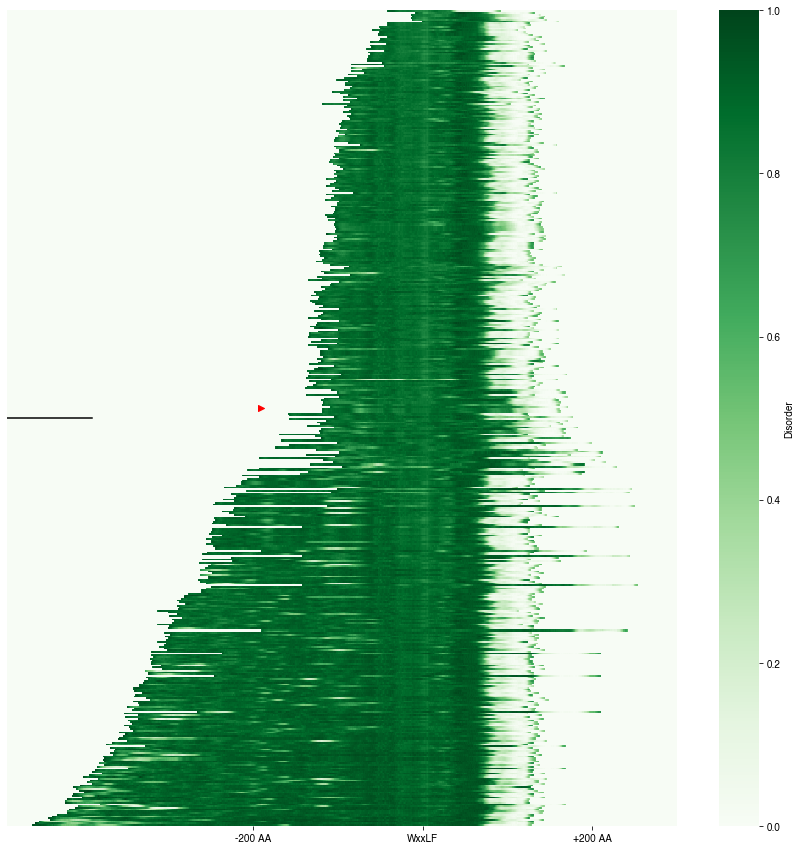

The peak of the sum is at 533
The sum of the peak is 0


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_23768/2901517588.py:98: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


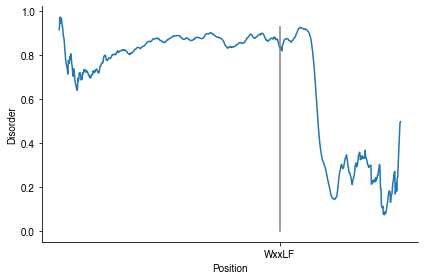

In [32]:
LinearCharge = plotFullLengthOrthologHeatMap(tempDF,'LinearCharge')
LinHydro = plotFullLengthOrthologHeatMap(tempDF,'LinearHydrophobicityKD')
Disorder = plotFullLengthOrthologHeatMap(tempDF,'Disorder')

790
476 Orthologs are plotted
Scer is on line 232


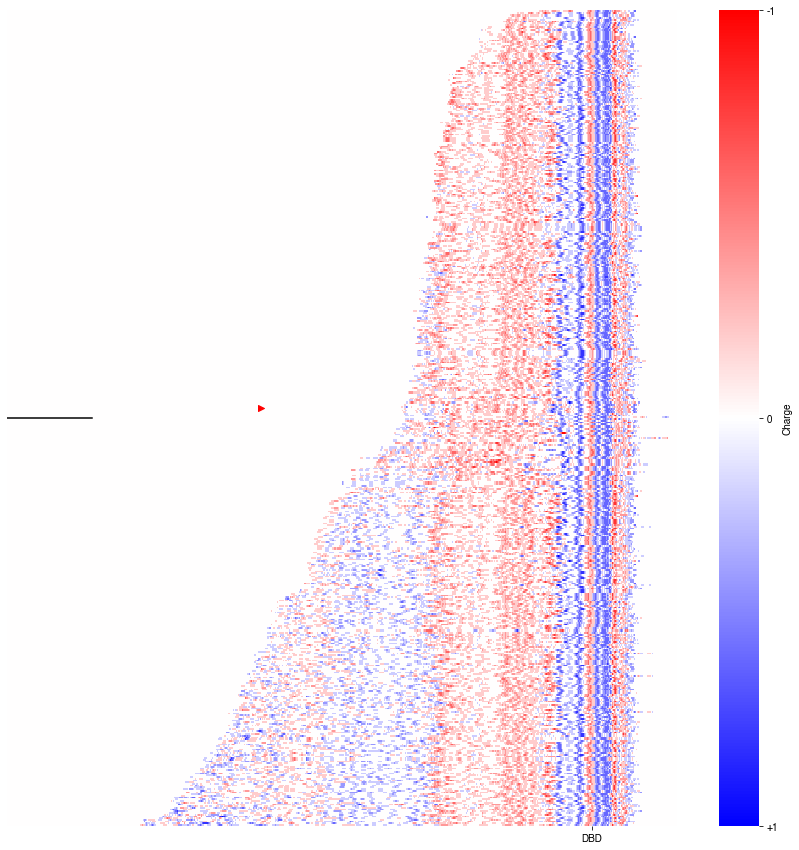

The peak of the sum is at 705
The sum of the peak is 0


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_23768/2901517588.py:98: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


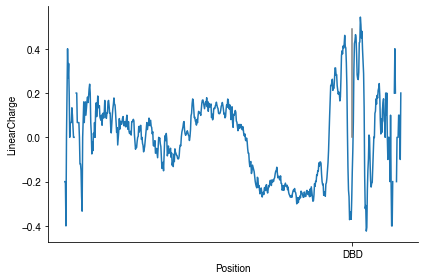

790
476 Orthologs are plotted
Scer is on line 232


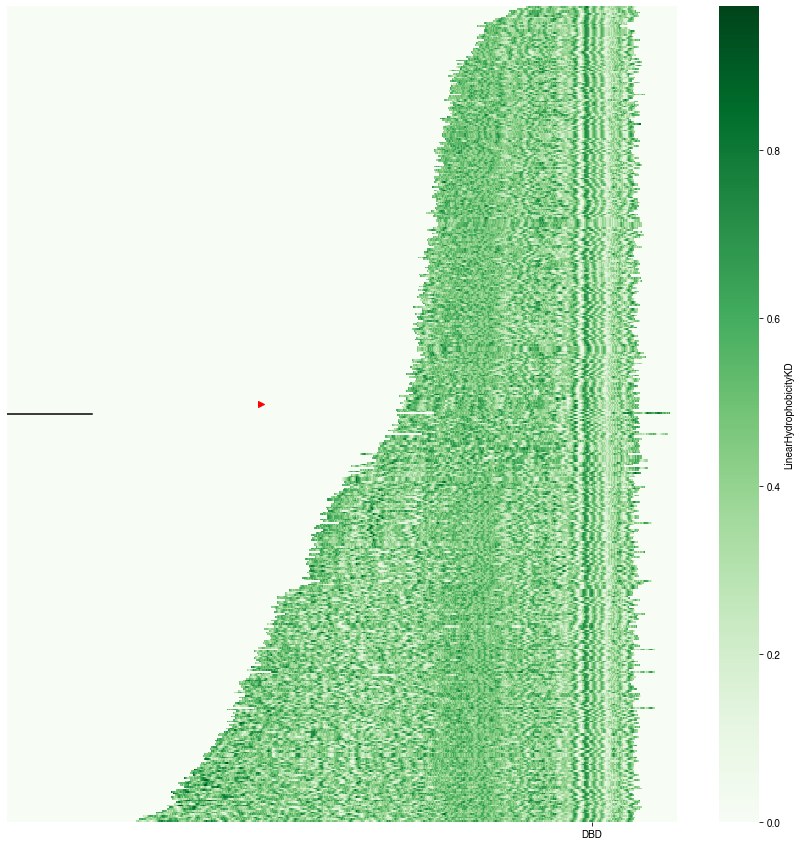

The peak of the sum is at 682
The sum of the peak is 0


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_23768/2901517588.py:98: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


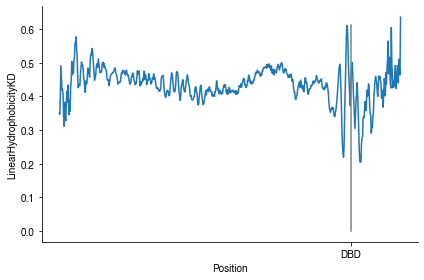

In [33]:
LinearCharge = plotFullLengthOrthologHeatMap(tempDF,'LinearCharge',AlignonDBD=True)
LinHydro = plotFullLengthOrthologHeatMap(tempDF,'LinearHydrophobicityKD',AlignonDBD=True)


790
476 Orthologs are plotted
Scer is on line 199


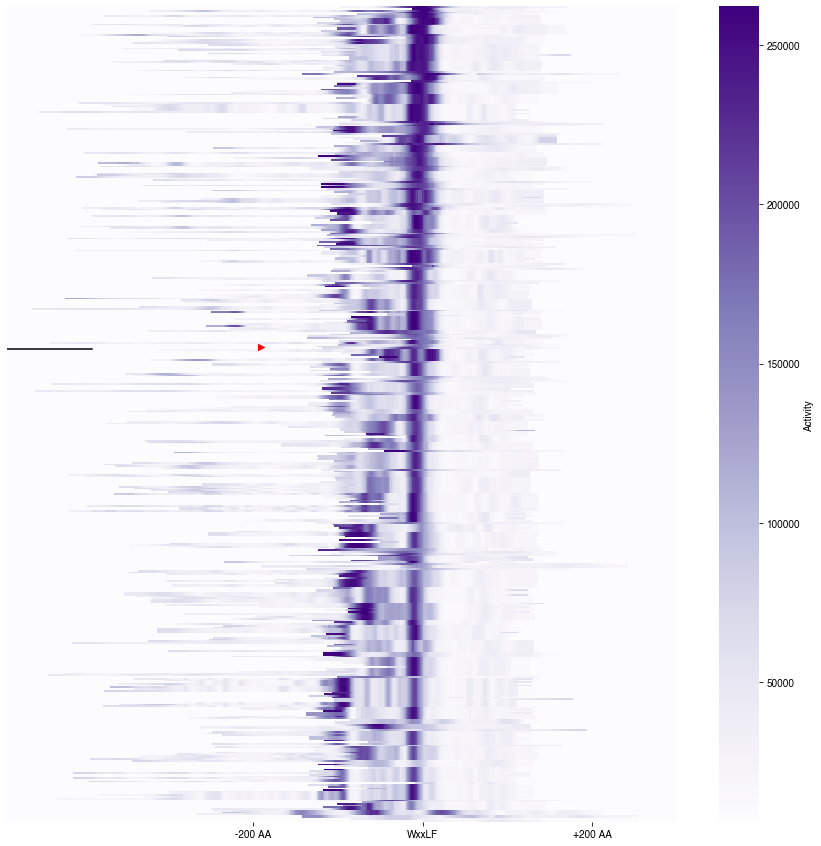

The peak of the sum is at 480
The sum of the peak is 216580


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_9983/3853533525.py:97: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


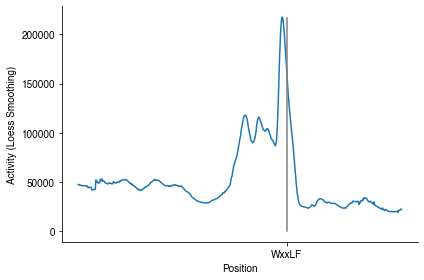

790
476 Orthologs are plotted
Scer is on line 201


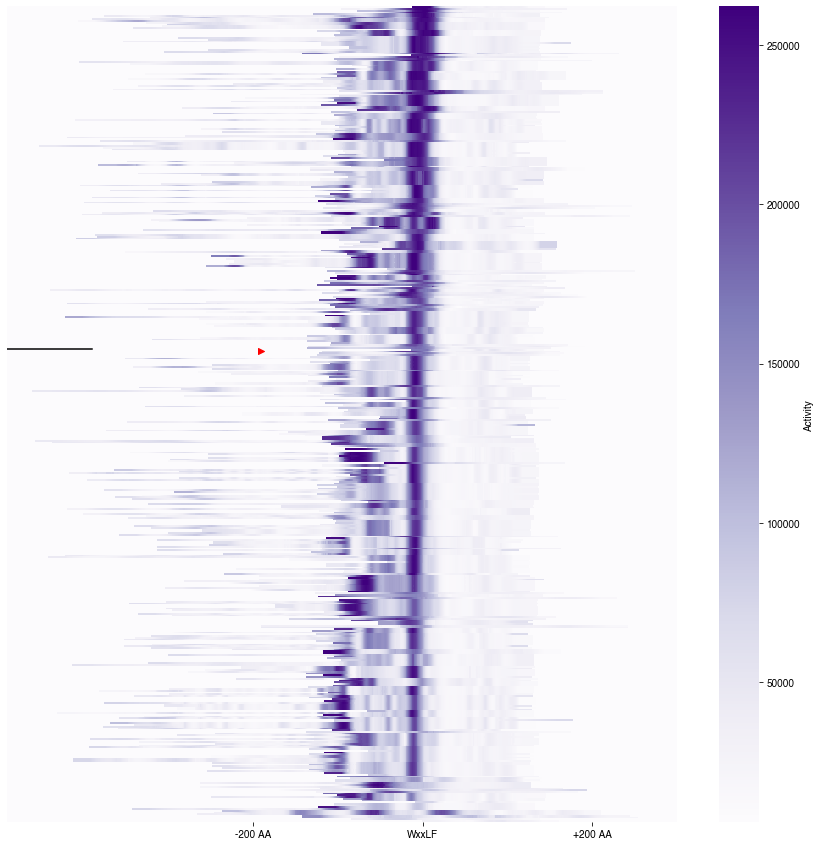

The peak of the sum is at 480
The sum of the peak is 216580


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_9983/3853533525.py:97: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


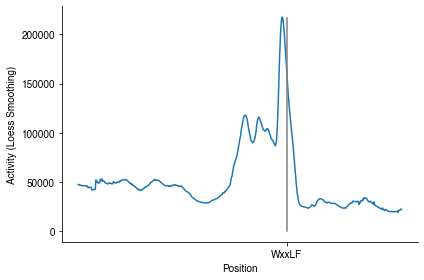

790
476 Orthologs are plotted
Scer is on line 319


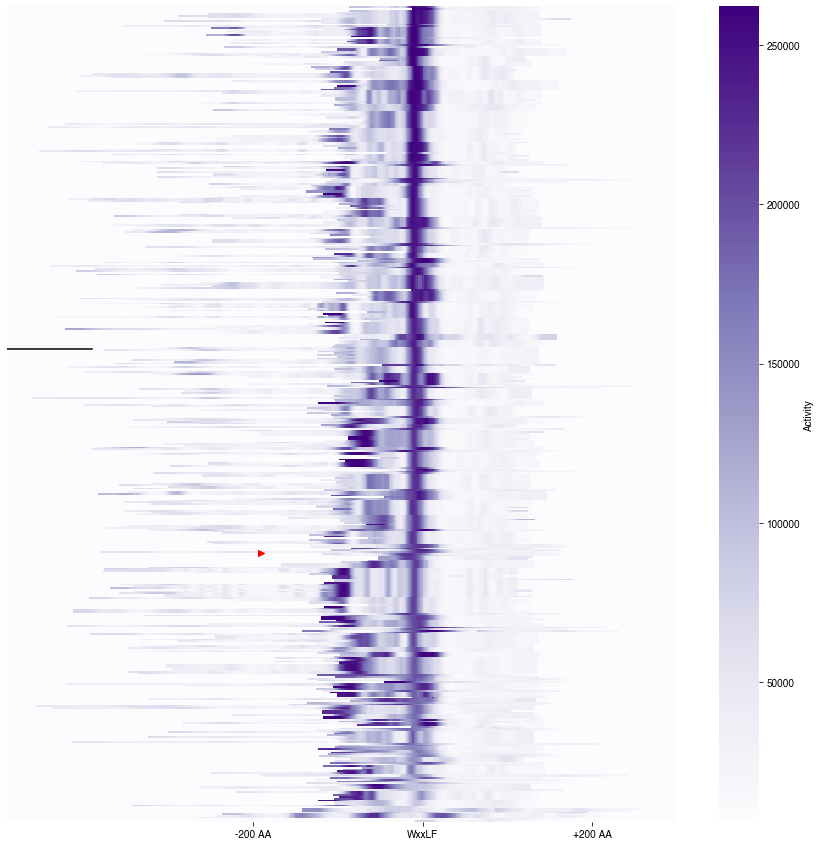

The peak of the sum is at 480
The sum of the peak is 216580


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_9983/3853533525.py:97: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


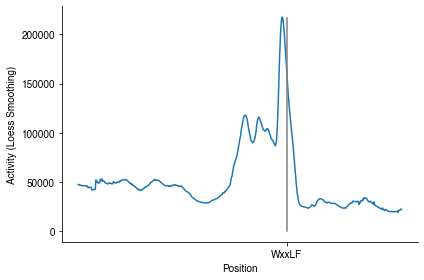

In [28]:
tempDF = ShortMedTFs.sort_values(by = 'Activity_at_WxxLF',ascending=False)
# LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivites')
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',OtherFileNameData='SortOnWxxLFAct')

# ShortMedTFs.Activity_at_WxxLF
tempDF = ShortMedTFs.sort_values(by = 'IntegralAround_WxxLF',ascending=False)
# LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivites')
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',OtherFileNameData='SortOnIntegralAround_WxxLF')

tempDF = ShortMedTFs.sort_values(by = 'Activity_at_WxxLF_minus10',ascending=False)
# LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivites')
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',OtherFileNameData='SortOnWxxLF_Minus10')



790
476 Orthologs are plotted
Scer is on line 201


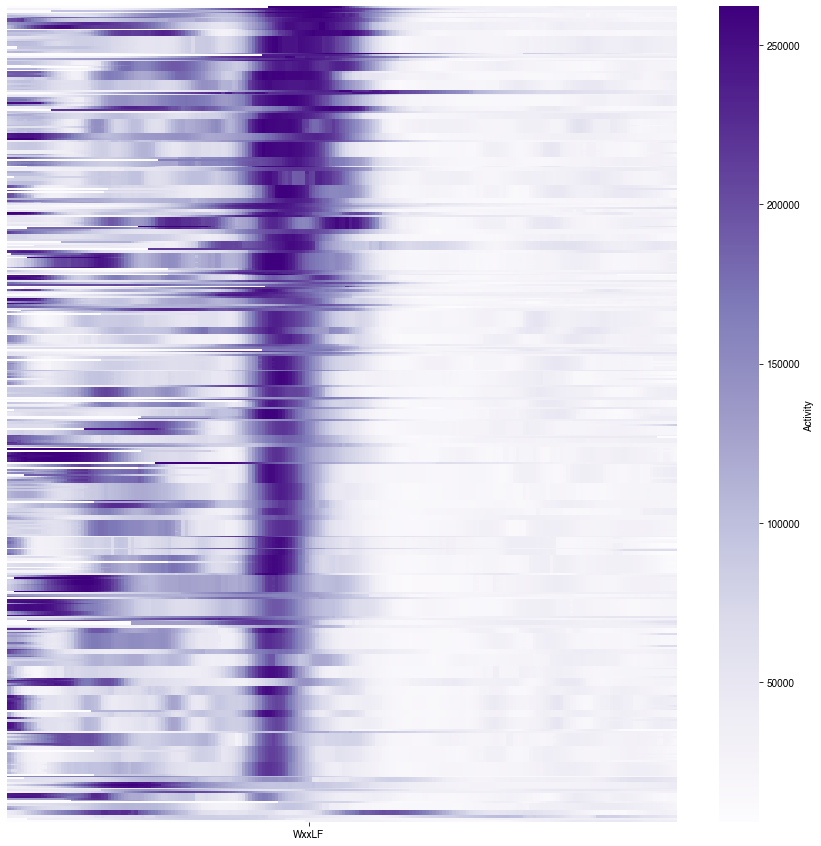

The peak of the sum is at 480
The sum of the peak is 216580


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_9983/3853533525.py:97: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


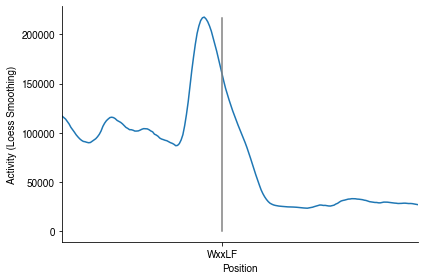

790
476 Orthologs are plotted
Scer is on line 319


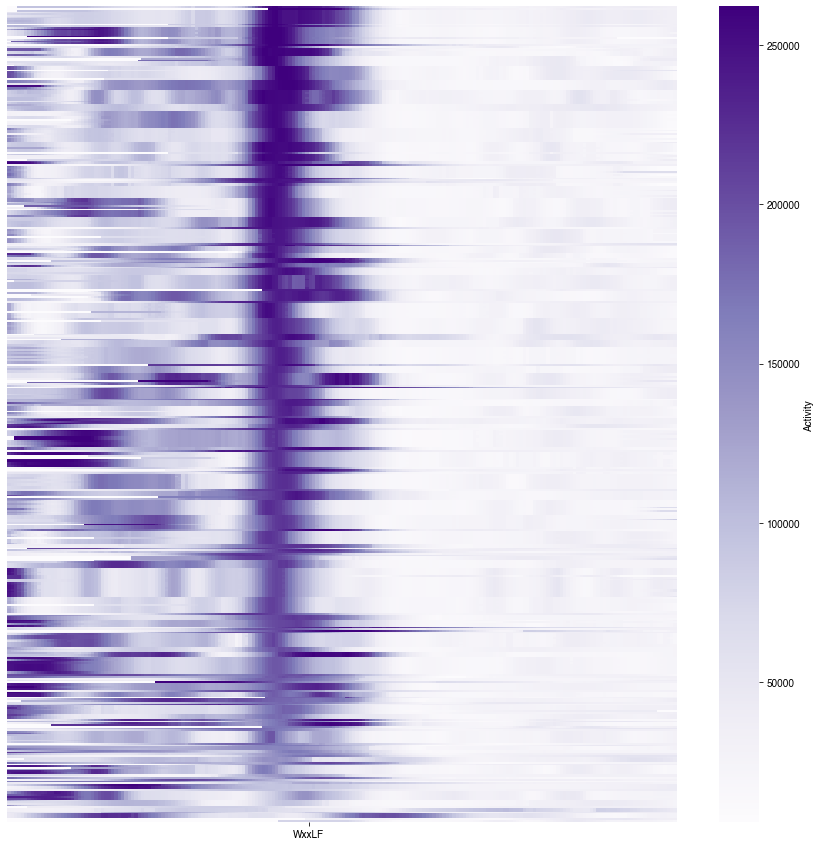

The peak of the sum is at 480
The sum of the peak is 216580


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_9983/3853533525.py:97: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


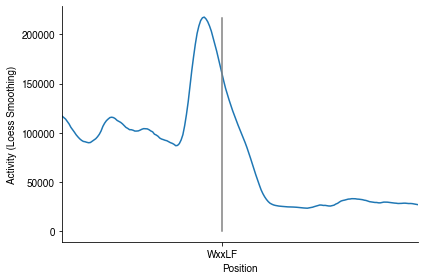

In [29]:
tempDF = ShortMedTFs.sort_values(by = 'IntegralAround_WxxLF',ascending=False)
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',ZoomCenter=True)

tempDF = ShortMedTFs.sort_values(by = 'Activity_at_WxxLF_minus10',ascending=False)
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',ZoomCenter=True)



790
476 Orthologs are plotted
Scer is on line 0


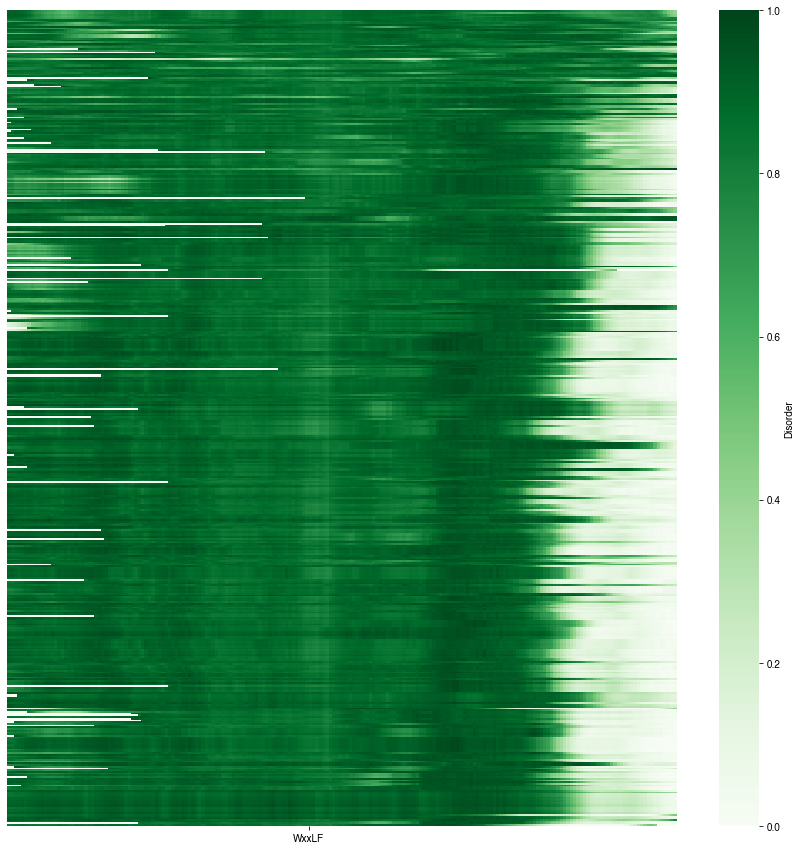

The peak of the sum is at 533
The sum of the peak is 0


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_9983/3853533525.py:97: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


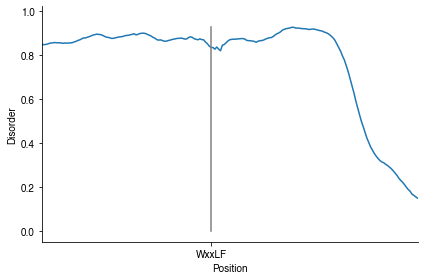

In [30]:
# AD activitiy is not correlated with DBD divergence
tempDF = ShortMedTFs.sort_values(by = 'DBD_AlignmentDist2Scer',ascending=False)
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'Disorder',ZoomCenter=True)
# LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivites')


In [31]:
# tempDF = ShortMedTFs.sort_values(by = 'Activity_at_WxxLF_minus10',ascending=False,OtherFileNameData='SortOnWxxLFAct_minus10')
# LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess')
# tempDF = ShortMedTFs.sort_values(by = 'Activity_at_WxxLF_plus10',ascending=False)
# LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',OtherFileNameData='SortOnWxxLFAct_plus10')
# # tempDF = ShortMedTFs.sort_values(by = 'Activity_at_WxxLF',ascending=False)
# # LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivites')

# # how many have lost activiy at peak position 490?
# print('%i TFs have lost activity at the peak, position 490'%sum(FullOrthoDF.Activity_at_WxxLF_minus10<ActivityThresh))
# print('%i TFs have lost activity at the WxxLF motif, position 500'%sum(FullOrthoDF.Activity_at_WxxLF<ActivityThresh))



/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_9983/2700853968.py:6: RuntimeWarning: Mean of empty slice
  ax1.plot(np.nanmean(LinearCharge,axis=0), color=color)
/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_9983/2700853968.py:12: RuntimeWarning: Mean of empty slice
  ax2.plot(np.nanmean(LinHydro,axis=0), color=color)


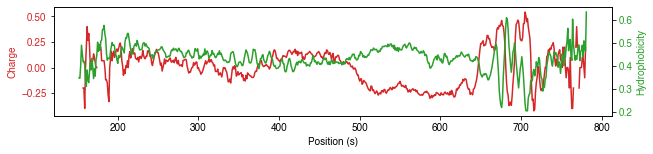

/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_9983/2700853968.py:22: RuntimeWarning: Mean of empty slice
  ax1.plot(np.nanmean(LinearCharge,axis=0), color=color)
/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_9983/2700853968.py:28: RuntimeWarning: Mean of empty slice
  ax2.plot(np.nanmean(LinActivity,axis=0), color=color)


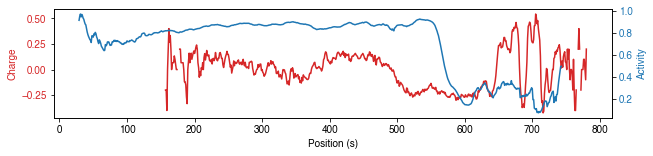

In [32]:
fig, ax1 = plt.subplots(figsize=(10,2))

color = 'tab:red'
ax1.set_xlabel('Position (s)')
ax1.set_ylabel('Charge', color=color)
ax1.plot(np.nanmean(LinearCharge,axis=0), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Hydrophobicity', color=color)  # we already handled the x-label with ax1
ax2.plot(np.nanmean(LinHydro,axis=0), color=color)
ax2.tick_params(axis='y', labelcolor=color)
# plt.xlim(200,600)
plt.show()
fig, ax1 = plt.subplots(figsize=(10,2))


color = 'tab:red'
ax1.set_xlabel('Position (s)')
ax1.set_ylabel('Charge', color=color)
ax1.plot(np.nanmean(LinearCharge,axis=0), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Activity', color=color)  # we already handled the x-label with ax1
ax2.plot(np.nanmean(LinActivity,axis=0), color=color)
ax2.tick_params(axis='y', labelcolor=color)
# plt.xlim(200,600)

plt.savefig('Figures/Heatmaps/OverlaySums.pdf')
plt.show()

# Blastocladiomycota  

In [33]:
# sequences that look out of place--where WxxLF motif has moved or degraded. 
names  = ['Blastocladiomycota_jgi|Catan2|1097078|CE97078_6759', # Looks like the 'true motif has degraded
          'Blastocladiomycota_jgi|Catan2|1466814|fgenesh1_pg.199_#_9',
          'Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g'
         ]
n1,n2,n3 = names

for name in names:
    indx = FullOrthoDF.SpeciesName ==name
    tempDF = FullOrthoDF[indx]
    a = str(tempDF.Seq.values)
#     print(tempDF)
    print('\nThere are %i Ws'%a.count('W'))
    print(a)
    print(tempDF.WxxLF_loc.values)
    print(tempDF.Length.values)
    print(tempDF.Activity_at_WxxLF.values)
    

    


There are 4 Ws
['MNHQATRIITPDFCLRVSGSFVHLLAAFDTRLDLKLTRLLHANNHKTDSVSVPFGSGSTPSALFPKSLLSLPLVPRPAQATTTAEHLNVASSPPPASIATPSPPLAAAQHVPAADGQWLALFPHPSSIDFDFNSFHQSFSSPPPHQPPTQLVAPPPTSFPGLAAPFTLDRFLANPAAEDSSKCPSTKAGTTEPDALFNWALDVACGADPIQQWTFITSTSAPPSPVPSLELCAATSGRALSKSPSPFDFGAAPPADATLVVSPSSWSSATSSAAAAPLQSPPPMSLDALDQLFLDATANVVAAPAPAAPATSAPAFIIPVHNDSALPDHIVVSPAAVSTKLEAPATTHLTLDAILGSASSMPALDLPPPATSSSSANPTPTRKRKASAASLPDHPNPPRPADPAQAKRLTNALSARRSRARKQAKLEYLERHVGELEDVNARLKRQVDLLRRKVDEGNKLAAQGHQHLDVFGGCRDG']
[266]
[477]
[55943.33781797]

There are 4 Ws
['MNHQATRIITPDFCLRVSDSVSVPFGSGSTPSALFPKSLLSLPLVPRPAQATTTAEHLNVASSPPPASIATPSPPLAAAQHVPAADGQWLALFPHPSSIDFDFNSFHQSFSSPPPHQPPTQLVAPPPTSFPGLAAPFTLDRFLANPAAEDSSKCPSTKAGTTEPDALFNWALDVACGADPIQQWTFITSTSAPPSPVPSLELCAATSGRALSKSPSPFDFGAAPPADATLVVSPSSWSSATSSAAAAPLQSPPPMSLDALDQLFLDATANVVAAPAPAAPATSAPAFIIPVHNDSALPDHIVVSPAAVSTKLEAPATTHLTLDAILGSASSMPALDLPPPATSSSSANPTPTRKRKASAASLPDHPNPPRPADPAQAKRLTNALSARRSRARKQAKLEYLERHVGELEDVNARLKRQVDLLRRKVDEGNKLAAQGHQHLDVFGGCRDG']
[237

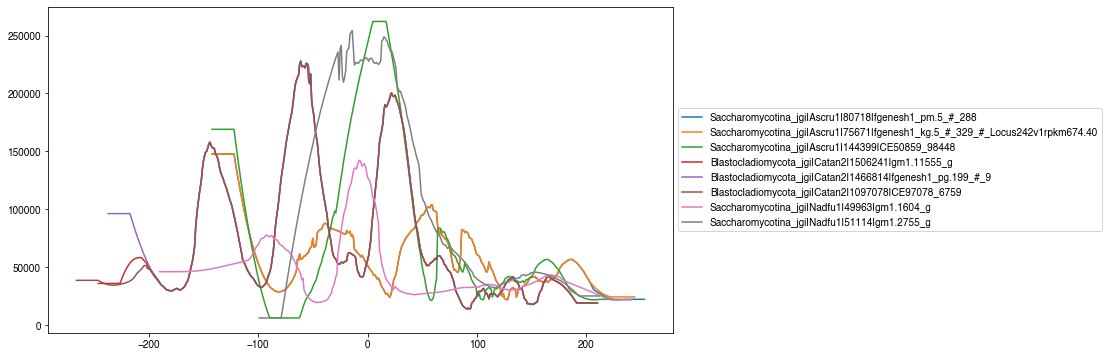

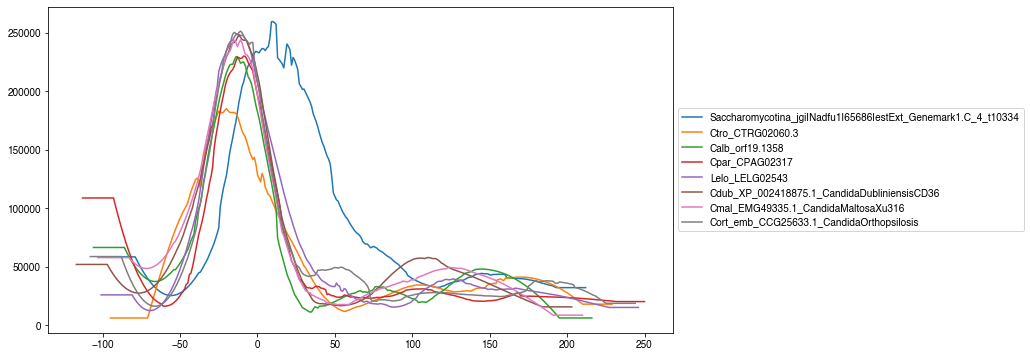

In [34]:

# look at all orthologs where WxxLF is more than 200 AA from the end.
indx =((FullOrthoDF.Length -FullOrthoDF.WxxLF_loc )>200)&((FullOrthoDF.Length -FullOrthoDF.WxxLF_loc )<300)
# indx = (FullOrthoDF.SpeciesName ==n1)|(FullOrthoDF.SpeciesName ==n2)|(FullOrthoDF.SpeciesName ==n3)
tempDF = FullOrthoDF[indx]
# drawlineTrace(tempDF)
# sns.regplot(x='CenteredXpos',y= 'SmoothedActivites',data=tempDF)
# FullOrthoDF.CenteredXpos
nperplot =8
counter =0
plt.figure(figsize=(14,6))
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

for i,row in tempDF.iterrows():
    if counter<nperplot:
        ax.plot(row.CenteredXpos,row.SmoothedActivitesLoess,label = row.SpeciesName)
        counter+=1
# plt.xlim(-100, 100)
    else:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
        #reset plot
        plt.figure(figsize=(14,6))
        ax = plt.subplot(111)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        counter = 0

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# tempDF.to_csv('ExportedSeqLists/Blastocladiomycota.csv')
# print(len(tempDF.CenteredXpos[-1]))
# len(tempDF.SmoothedActivites[-1])

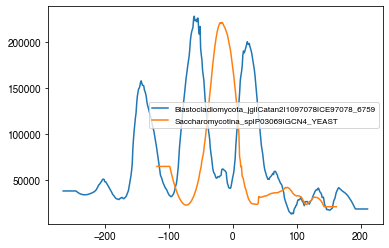

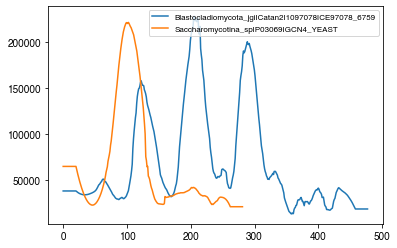

In [30]:
indx = (FullOrthoDF.SpeciesName=='Blastocladiomycota_jgi|Catan2|1097078|CE97078_6759')
# indx = indx |(FullOrthoDF.SpeciesName=='Blastocladiomycota_jgi|Catan2|1466814|fgenesh1_pg.199_#_9')
# indx = indx |(FullOrthoDF.SpeciesName=='Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g')
indx = indx |(FullOrthoDF.SpeciesName=='Saccharomycotina_sp|P03069|GCN4_YEAST')

TempFullOrthoDF = FullOrthoDF[indx].reindex()


for i, row in TempFullOrthoDF.iterrows():
    tempx = np.linspace(0,len(row.Seq),len(row.Seq))-row.WxxLF_loc
    plt.plot(tempx,row.SmoothedActivitesLoess,label=row.SpeciesName)

plt.legend(fontsize =8)
plt.show()


# Analysis of spacer sequence

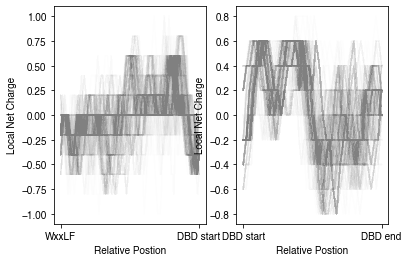

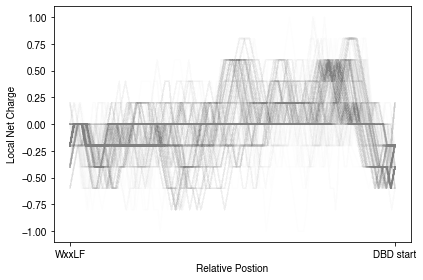

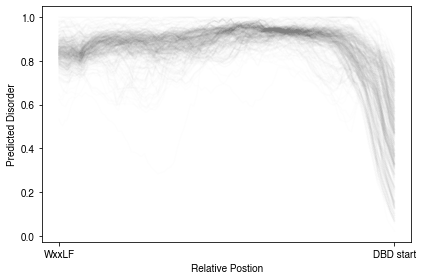

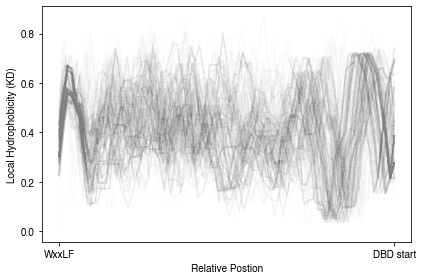

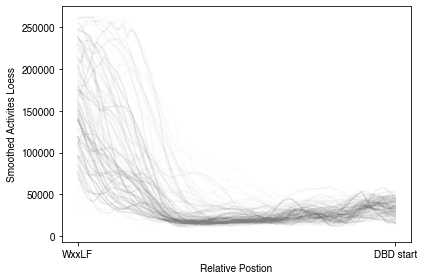

In [35]:
#attempt metagene plot of the spacer
loc1, loc2 = 'WxxLF_loc','DBD_start'
loc1, loc2 = 'WxxLF_loc','DBD_start'
labeldict = {'WxxLF_loc':'WxxLF','DBD_start':'DBD start','DBD_end':'DBD end',
            'LinearCharge':'Local Net Charge','Disorder':'Predicted Disorder',
             'LinearHydrophobicityKD':'Local Hydrophobicity (KD)',
            'SmoothedActivitesLoess':'Smoothed Activites Loess'}

def plotMetaGene(loc1, loc2, prop='LinearCharge'):
    for i, row in FullOrthoDF.iterrows():
        tempVals = row[prop]
        tempVals = tempVals[row[loc1]:row[loc2]]
        plt.plot(np.linspace(0,1,row[loc2]-row[loc1]),tempVals,alpha = 0.01,c='gray')
    plt.xticks([0,1],[labeldict[loc1],labeldict[loc2]])
    plt.ylabel(labeldict[prop])
    plt.xlabel('Relative Postion')
plt.subplot(1,2,1)
plotMetaGene('WxxLF_loc','DBD_start')
plt.subplot(1,2,2)
plotMetaGene('DBD_start','DBD_end')
# plotMetaGene('WxxLF_loc','DBD_end')
plt.show()
# plotMetaGene('WxxLF_loc','DBD_end')
# plt.show()
plotMetaGene('WxxLF_loc','DBD_start')
plt.tight_layout()
plt.savefig('Figures/PaperFigs/Supp/MetaGene_Charge.pdf')
plt.show()
plotMetaGene('WxxLF_loc','DBD_start',prop='Disorder')
plt.tight_layout()
plt.savefig('Figures/PaperFigs/Supp/MetaGene_disorder.pdf')
plt.show()
plotMetaGene('WxxLF_loc','DBD_start',prop='LinearHydrophobicityKD')
plt.tight_layout()
plt.savefig('Figures/PaperFigs/Supp/MetaGene_HydrophobicityKD.pdf')
plt.show()
plotMetaGene('WxxLF_loc','DBD_start',prop='SmoothedActivitesLoess')
plt.tight_layout()
plt.savefig('Figures/PaperFigs/Supp/MetaGene_Activity.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

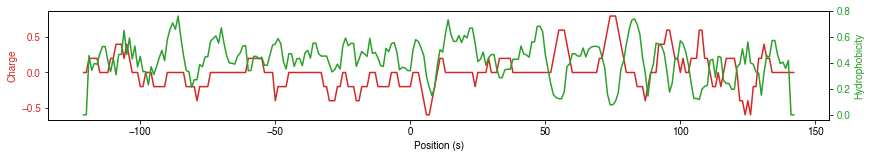

<Figure size 432x288 with 0 Axes>

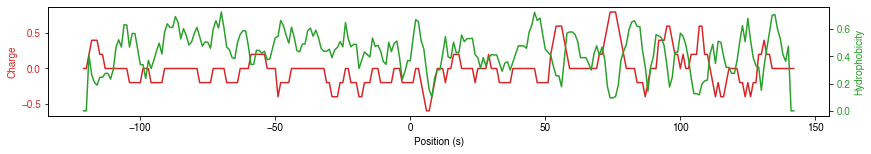

<Figure size 432x288 with 0 Axes>

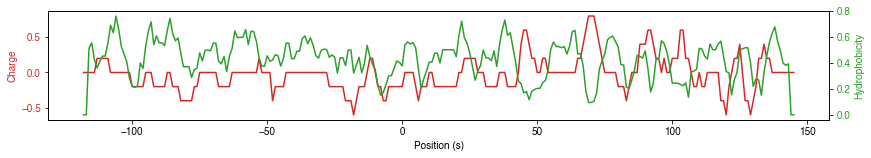

<Figure size 432x288 with 0 Axes>

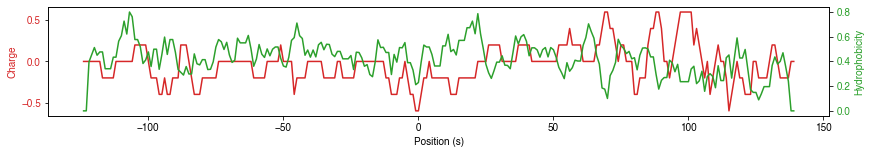

<Figure size 432x288 with 0 Axes>

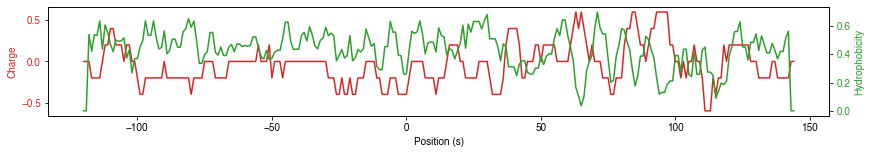

<Figure size 432x288 with 0 Axes>

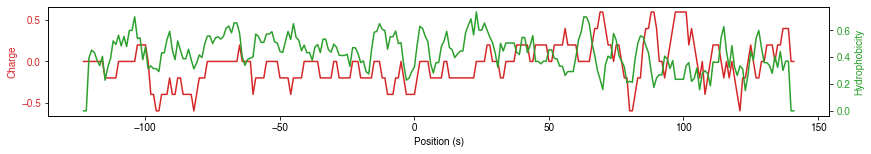

<Figure size 432x288 with 0 Axes>

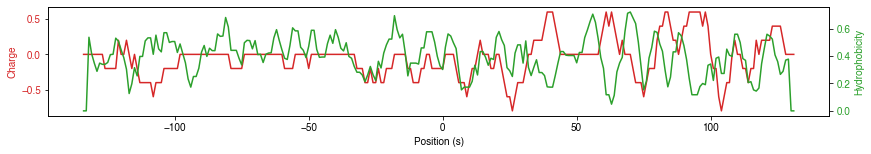

<Figure size 432x288 with 0 Axes>

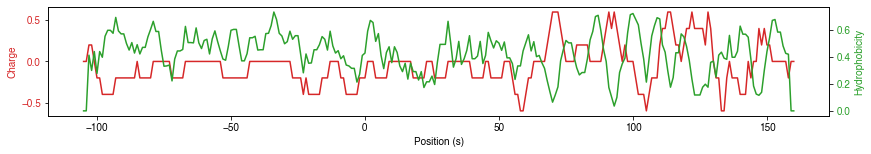

<Figure size 432x288 with 0 Axes>

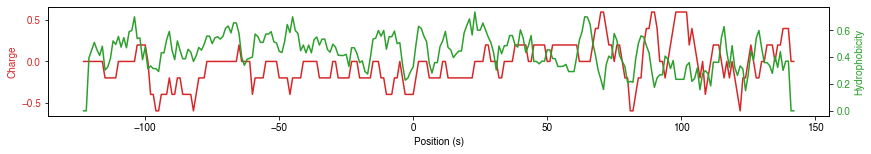

<Figure size 432x288 with 0 Axes>

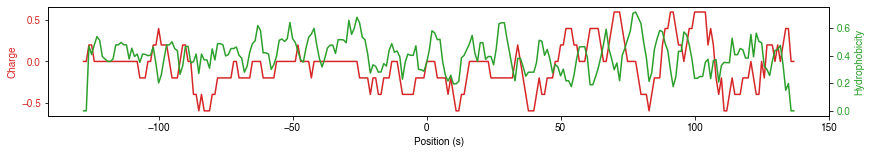

<Figure size 432x288 with 0 Axes>

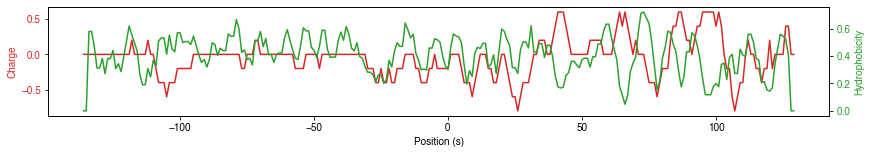

<Figure size 432x288 with 0 Axes>

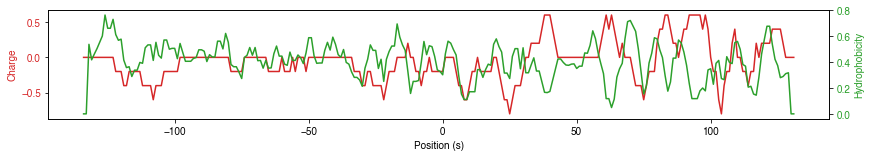

In [15]:
indx = FullOrthoDF.Length < 600
tempDF = FullOrthoDF[indx]
maxLength =2690
heatmapMatrix = np.zeros((len(tempDF),maxLength))
tempDF = tempDF.sort_values(by = 'Length',ascending=True)
tempDF = tempDF.reset_index()
for i in range(200,212):
    plt.figure()
    fig, ax1 = plt.subplots(figsize=(14,2))
    Xs = range(0,len(tempDF.Seq[i]))-tempDF.WxxLF_loc[i]

    color = 'tab:red'
    ax1.set_xlabel('Position (s)')
    ax1.set_ylabel('Charge', color=color)
    ax1.plot(Xs,tempDF.LinearCharge[i], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel('Hydrophobicity', color=color)  # we already handled the x-label with ax1
    ax2.plot(Xs,tempDF.LinearHydrophobicityKD[i], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.show()

In [37]:
#Export sequences 
N = 90

SortFeatures = ['Activity_at_WxxLF_plus20','Activity_at_WxxLF',
               'Activity_at_WxxLF_minus20'
               ]
for sortFeature in SortFeatures:
# sequences were most active part has shifted left (N termimal)
    tempDF = FullOrthoDF#[indx]
    tempDF['substring'] = tempDF.apply(lambda x: x['Seq'][max(x['WxxLF_loc']-50,0):x['WxxLF_loc']+50],1)
    tempDF = tempDF.sort_values(by = 'Length',ascending=True)
    tempDF = tempDF.sort_values(by = sortFeature,ascending=True,ignore_index=True)
    bot =tempDF.loc[0:N-1,:] 
    #grab 50 AA up and downstream of center
    tempDF = tempDF.sort_values(by = sortFeature,ascending=False,ignore_index=True)
    top =tempDF.loc[0:N-1,:]
    exportfilename = 'ExportedSeqLists/Full_Orthologs_%s_bottom%i.fasta'%(sortFeature,N)
    tempDict = dict(zip(bot.SpeciesName,bot.Seq))
    protfasta.write_fasta(tempDict,exportfilename)
    exportfilename = 'ExportedSeqLists/Full_Orthologs_%s_top%i.fasta'%(sortFeature,N)
    tempDict = dict(zip(top.SpeciesName,top.Seq))
    protfasta.write_fasta(tempDict,exportfilename)




# How many orthologs have Strong or Inactive regions at WxxLF?

In [20]:
#Export sequences for alignments
# Zoom into the region around the WxxLF Motif

N = 30
Upstream = 50
Downstream = 20
topHalfFigure5 = 138/2
HighActivityThresh = 150000
SortFeatures = ['Activity_at_WxxLF',
#                'Activity_at_WxxLF_minus10',
#                 'Activity_at_WxxLF_plus10',
#                 'IntegralAround_WxxLF'
               ]
for sortFeature in SortFeatures:
# sequences were most active part has shifted left (N termimal)
    tempDF = FullOrthoDF_pruned#[indx]
    #grab N AA Upstream and Downstream of center
    tempDF['substring'] = tempDF.apply(lambda x: x['Seq'][max(x['WxxLF_loc']-Upstream,0):x['WxxLF_loc']+Downstream],1)
    HighAct_N = sum(tempDF[sortFeature]>HighActivityThresh)
    LowAct_N = sum(tempDF[sortFeature]<ActivityThresh)
    
    temp2 = tempDF.sort_values(by='Length',ascending=True)
    temp2 = temp2[:500]
    print(temp2.shape)
    exportfilename = 'ExportedSeqLists/Activity_at_WxxLF_LocalSeqs_uniques/AllSeqsWithDuplicates_%s_-%i_+%i_%i.fasta'%(sortFeature,Upstream,Downstream,len(temp2))
    tempDict = dict(zip(temp2.SpeciesName,temp2.substring))
    protfasta.write_fasta(tempDict,exportfilename)
    tempDF= tempDF.drop_duplicates(subset=['substring'],ignore_index=True)
    
    print('\nWe are looking at the %i residues upstream and %i residues downstream of the WxxLF motif' %(Upstream,Downstream))
    print('In this region there are %i unique sequences for the %i orthologs'% (len(tempDF),len(FullOrthoDF)))
    print('We are looking at %s'%sortFeature)
    print('%i ortholgos are highly active, > %i'%(HighAct_N,HighActivityThresh))
    print('%i orthologs are lowly active,  <  %i\n'%(LowAct_N,ActivityThresh))
    
    HighAct_N = sum(tempDF[sortFeature]>HighActivityThresh)
    LowAct_N = sum(tempDF[sortFeature]<ActivityThresh)
    print('%i unique seqs  are highly active, > %i'%(HighAct_N,HighActivityThresh))
    print('%i unique seqs are lowly active,   <  %i'%(LowAct_N,ActivityThresh))

#     HighAct_N = 100
    
    tempDF = tempDF.sort_values(by = sortFeature,ascending=True,ignore_index=True)
    bot =tempDF.loc[0:LowAct_N-1,:] 
    print('\nActivity of highest BOTTOM region is %f'% max(bot[sortFeature]))

    tempDF = tempDF.sort_values(by = sortFeature,ascending=False,ignore_index=True)
#     temp = (tempDF[sortFeature])
#     print('\nActivity of last BOTTOM region is %f'% temp[LowAct_N-1])
    top =tempDF.loc[0:HighAct_N-1,:]
    temp = (top[sortFeature])
    print('\nActivity of last TOP region is %f'% temp[HighAct_N-1])
    print('\nActivity of lowest TOP region is %f'% min(top[sortFeature]))
    print('%i unique seqs  are highly active, > %i'%(HighAct_N,min(top[sortFeature])))

#     print(temp)
    exportfilename = 'ExportedSeqLists/Activity_at_WxxLF_LocalSeqs_uniques/%s_-%i_+%i_bottom%i.fasta'%(sortFeature,Upstream,Downstream,LowAct_N)
    tempDict = dict(zip(bot.SpeciesName,bot.substring))
    protfasta.write_fasta(tempDict,exportfilename)
    exportfilename = 'ExportedSeqLists/Activity_at_WxxLF_LocalSeqs_uniques/%s_-%i_+%i_top%i.fasta'%(sortFeature,Upstream,Downstream,HighAct_N)
    tempDict = dict(zip(top.SpeciesName,top.substring))
    protfasta.write_fasta(tempDict,exportfilename)
    
    
    exportfilename = 'ExportedSeqLists/Activity_at_WxxLF_LocalSeqs_uniques/AllSeqs_%s_-%i_+%i_top%i.fasta'%(sortFeature,Upstream,Downstream,len(tempDF))
    tempDict = dict(zip(tempDF.SpeciesName,tempDF.substring))
    protfasta.write_fasta(tempDict,exportfilename)
    tempDF2 = tempDF[['SpeciesName','substring','Activity_at_WxxLF','Activity_at_WxxLF_plus20','Activity_at_WxxLF_minus20','Activity_at_WxxLF_minus10','Activity_at_WxxLF_plus10']]
    exportfilename = 'ExportedSeqLists/Activity_at_WxxLF_LocalSeqs_uniques/AllSeqs_%s_-%i_+%i.csv'%(sortFeature,Upstream,Downstream)
    tempDF2.to_csv(exportfilename)
    
    topHalf =tempDF.loc[0:topHalfFigure5-1,:]

    exportfilename = 'ExportedSeqLists/Activity_at_WxxLF_LocalSeqs_uniques/%s_-%i_+%i_top%i.fasta'%(sortFeature,Upstream,Downstream,topHalfFigure5)
    tempDict = dict(zip(topHalf.SpeciesName,topHalf.substring))
    protfasta.write_fasta(tempDict,exportfilename)
    


#export full length TFs of sequences 

(138, 14)

We are looking at the 50 residues upstream and 20 residues downstream of the WxxLF motif
In this region there are 138 unique sequences for the 502 orthologs
We are looking at Activity_at_WxxLF
90 ortholgos are highly active, > 150000
16 orthologs are lowly active,  <  94031

90 unique seqs  are highly active, > 150000
16 unique seqs are lowly active,   <  94031

Activity of highest BOTTOM region is 93517.487029

Activity of last TOP region is 151368.566785

Activity of lowest TOP region is 151368.566785
90 unique seqs  are highly active, > 151368


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_73830/2949067997.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempDF['substring'] = tempDF.apply(lambda x: x['Seq'][max(x['WxxLF_loc']-Upstream,0):x['WxxLF_loc']+Downstream],1)


KeyError: "['Activity_at_WxxLF_plus20', 'Activity_at_WxxLF_minus20', 'Activity_at_WxxLF_minus10', 'Activity_at_WxxLF_plus10'] not in index"

In [17]:
tempDF = ShortMedTFs.sort_values(by = 'Activity_at_WxxLF',ascending=False)
# There are 36 homologs with Low activity at WxxLF via integral caluculation. These have 19 unique sequences                                
tempDF = tempDF.tail(63)
LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',OtherFileNameData='SortOnActivityAt_WxxLF',YZoom=True)

# tempDF = ShortMedTFs.sort_values(by = 'IntegralAround_WxxLF',ascending=False)
# # There are 36 homologs with Low activity at WxxLF via integral caluculation. These have 19 unique sequences                                
# tempDF = tempDF.tail(27)
# LinActivity = plotFullLengthOrthologHeatMap(tempDF,'SmoothedActivitesLoess',OtherFileNameData='SortOnIntegralAround_WxxLF',YZoom=True,showWxxLFIntegralRegion=True)


NameError: name 'ShortMedTFs' is not defined

In [40]:
# Howmany homologs have an active tile that overlaps the WxxLF motif?


#count WxxLF motifs in ORtholog DF
def CountMotifs(currentDF, motiflist,column='ADseq',printstats =True, plothist=True):
    for motif in motiflist:
        tempcol = []
        for seq in currentDF[column]:
            hits = re.search(motif,seq)
            if hits:
                matches = re.findall(motif,seq)
                tempcol.append(len(matches))
            else:
                tempcol.append(0)
        currentDF[motif]=tempcol
        if  printstats :
#             plt.hist(currentDF[Activity],150) #Blue hist includes not detected ADs
            indx = (currentDF[motif]>0)#&(currentDF.Recovered)
            tempDF  =  currentDF[indx]
            notindx = (currentDF[motif]==0)#&(currentDF.Recovered)
            notDF = currentDF[notindx]
            # stats does not use non detected ADs
            test = stats.ttest_ind(tempDF[Activity],notDF[Activity], equal_var=False)
            print(motif)
            print('%.1f (n=%i) with vs %.1f without (%i)\n'%(np.mean(tempDF[Activity]),sum(indx),np.mean(notDF[Activity]),sum((currentDF[motif]==0)&(currentDF.Recovered))))
            print(test)
        if plothist:
            #Blue hist does not use non detected ADs
            plt.hist(notDF[Activity],150,density=True) 
            # orange hist does not use non detected ADs
            plt.hist(tempDF[Activity],150,alpha=.5,density=True)
            plt.savefig('Figures/CompareActivitywMotif_%s.pdf'%motif)
            plt.show()
    return currentDF
Orthologs_DF = CountMotifs(Orthologs_DF,['W..LF'],column='Seq',printstats =False, plothist=False)

counter = 0
for name in set(Orthologs_DF.SpeciesNames):
    tempDF = Orthologs_DF[Orthologs_DF.SpeciesNames==name]
    indx = (tempDF.Activity > ActivityThresh)&(tempDF['W..LF']>0)
    if sum(indx) >0:
        counter +=1
    else:
        print(name)
print('There are %i homologs'%len(set(Orthologs_DF.SpeciesNames)))
print('%i homologs have a tile that is active with a WxxLF motif'%counter)
    
Orthologs_DF

Saccharomycotina_jgi|Hanpo2|10524|gm1.4782_g
Saccharomycotina_jgi|Canca1|23981|e_gw1.2.2068.1
There are 502 homologs
500 homologs have a tile that is active with a WxxLF motif


Unnamed: 0                                       SpeciesNames  \
0               0      Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g   
1               1      Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g   
2               2      Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g   
3               3      Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g   
4               4      Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g   
...           ...                                                ...   
88363       88363  Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224   
88364       88364  Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224   
88365       88365  Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224   
88366       88366  Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224   
88367       88367  Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224   

       NativeLocation  NormLocation                                       Seq  \
0                  20          -986  MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQA   
1                  25          -981  EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ   
2                  30          -976  IESSTASTALQRQDLRYTFRSNARAASGQANANYQAFTAG   
3                  35          -971  ASTALQRQDLRYTFRSNARAASGQANANYQAFTAGSALNG   
4                  40          -966  QRQDLRYTFRSNARAASGQANANYQAFTAGSALNGPSLPA   
...               ...           ...                                       ...   
88363             215            91  VAVKRARNTMAARKSRRRKLEKQEQMEDRIRELEAMLAKS   
88364             220            96  ARNTMAARKSRRRKLEKQEQMEDRIRELEAMLAKSEKDVQ   
88365             225           101  AARKSRRRKLEKQEQMEDRIRELEAMLAKSEKDVQYWKAM   
88366             230           106  RRRKLEKQEQMEDRIRELEAMLAKSEKDVQYWKAMAQTSM   
88367             233           109  KLEKQEQMEDRIRELEAMLAKSEKDVQYWKAMAQTSMTDA   

           Activity  Stdev_BYS4_BioReps  W..LF  
0      50849.756535        15910.995586      0  
1      22153.464394                 NaN      0  
2      25911.890423        13364.539799      0  
3      22446.773651        17698.744045      0  
4      51501.398208         5355.696567      0  
...             ...                 ...    ...  
88363  42259.516373          554.550689      0  
88364  15158.577492         4316.422793      0  
88365  85443.165260                 NaN      0  
88366  21800.948266                 NaN      0  
88367  18081.163896         5130.180276      0  

[88368 rows x 8 columns]

(50, 22)
(50, 22)
Looking 50 AA upstream and 20 AA downtsream of the WxxLF motif, there are 50 15 AA regions
There are 50 unique sequences. 0 have 3 prolines and 0 have 4 prolines
There are 50 unique sequences. 0 have 3 prolines and 0 have 4 prolines
There are 50 unique sequences. 0 have 3 prolines and 0 have 4 prolines
There are 50 unique sequences. 0 have 3 prolines and 0 have 4 prolines
There are 50 unique sequences. 0 have 3 prolines and 0 have 4 prolines


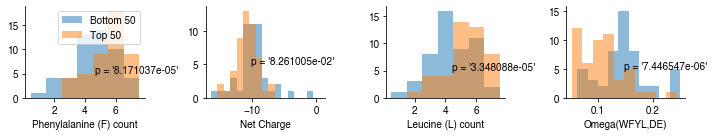

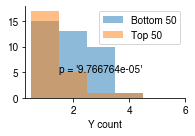

In [98]:
# count prolines in the VERY local region 
tempDF = FullOrthoDF
Upstream = 50
Downstream = 20
tempDF['substring2'] = tempDF.apply(lambda x: x['Seq'][max(x['WxxLF_loc']-Upstream,0):x['WxxLF_loc']+Downstream],1)
sortFeature ='IntegralAround_WxxLF'
tempDF= tempDF.drop_duplicates(subset=['substring2'],ignore_index=True)
tempDF = tempDF.sort_values(by = sortFeature,ascending=False,ignore_index=True)
top =tempDF.loc[0:49,:]
tempDF = tempDF.sort_values(by = sortFeature,ascending=True,ignore_index=True)
bot =tempDF.loc[0:49,:]
tempDF = bot
print(top.shape)
print(bot.shape)

print( 'Looking %i AA upstream and %i AA downtsream of the WxxLF motif, there are %i 15 AA regions' %(Upstream,Downstream,tempDF.shape[0]))
tempcount =[]
labeldict2 = {'P':'Proline count','F':'Phenylalanine (F) count','L':'Leucine (L) count','Y':'Y count','W':'W',
             'E':'E','D':'D','Charge':'Net Charge','OmegaWFYL_DE':"Omega(WFYL,DE)",'K':'K','R':'R','S':'S'}
def plotLocalCount(AA,printHist = False):
    Pcounter3, Pcounter4 = 0,0
    tempcount =[]
    for i, row in tempDF.iterrows():
        tempseq = row.substring2
        if AA =='Charge':
            tempCharge = tempseq.count('K')+tempseq.count('R')-tempseq.count('D')-tempseq.count('E')
            tempcount.append(tempCharge)
        elif AA =='OmegaWFYL_DE':
            seq =  SequenceParameters(tempseq)
            tempcount.append(seq.get_kappa_X(['D','E'],['W','F','Y','L']))
            
        else:
            tempcount.append(tempseq.count(AA))
    #         if tempseq.count(AA) >3:
    #             print((tempseq))
            if AA=='P': #count prolines
                if tempseq.count(AA) ==3:
                    Pcounter3+=1
                if tempseq.count(AA) ==4:
                    Pcounter4+=1
                
    print ('There are %i unique sequences. %i have 3 prolines and %i have 4 prolines' % ((tempDF.shape[0]),Pcounter3,Pcounter4))
        
    if AA=='Charge':
        plt.hist(tempcount,np.linspace(min(tempcount),0,np.abs(min(tempcount))+1)+.5,label ='Bottom 50',alpha=.5)        
    elif AA =='OmegaWFYL_DE':
        plt.hist(tempcount,10,label ='Bottom 50',alpha=.5)                
    else:
        plt.hist(tempcount,np.linspace(0,max(tempcount),max(tempcount)+1)+.5,label ='Bottom 50',alpha=.5)
    
    tempcount_top =[]
    for i, row in top.iterrows():
        tempseq = row.substring2
        if AA =='Charge':
            tempCharge = tempseq.count('K')+tempseq.count('R')-tempseq.count('D')-tempseq.count('E')
            tempcount_top.append(tempCharge)
        elif AA =='OmegaWFYL_DE':
            seq =  SequenceParameters(tempseq)
            tempcount_top.append(seq.get_kappa_X(['D','E'],['W','F','Y','L']))
        else:
            tempcount_top.append(tempseq.count(AA))
    if AA=='Charge':
        plt.hist(tempcount_top,np.linspace(min(tempcount),0,np.abs(min(tempcount))+1)+.5,label ='Top 50',alpha=.5)        
    elif AA =='OmegaWFYL_DE':
        plt.hist(tempcount_top,10,label ='Bottom 50',alpha=.5) 
    else:
        plt.hist(tempcount_top,np.linspace(0,max(tempcount),max(tempcount)+1)+.5,label ='Top 50',alpha=.5)
        plt.xticks([2,4,6])
    ##ttest
    test = stats.ttest_ind(tempcount,tempcount_top, equal_var=False)
    scientific_notation="{:e}".format(test[1])
    plt.text(np.mean(tempcount),5,'p = %r'%scientific_notation)


    plt.xlabel(labeldict2[AA])
    if printHist:
        x = plt.hist(tempcount,np.linspace(0,max(tempcount),max(tempcount)+1)+.5)
        print( x   )
plt.figure(figsize=(10,2)) 
plt.subplot(1,4,1)
plotLocalCount('F',printHist =False)
plt.legend()
plt.subplot(1,4,2)
plotLocalCount('Charge')
plt.subplot(1,4,3)
plotLocalCount('L')
plt.subplot(1,4,4)
plotLocalCount('OmegaWFYL_DE')

plt.tight_layout()
sns.despine()
plt.savefig('Figures/PaperFigs/Revision/CAD_From_FullOrthologs_CountAAs.pdf')


plt.figure(figsize=(10,2)) 
plt.subplot(1,4,1)
plotLocalCount('Y',printHist =False)
plt.legend()
# plt.subplot(1,4,2)
# plotLocalCount('S')
# plt.subplot(1,4,3)
# plotLocalCount('P')
# plt.subplot(1,4,4)
# plotLocalCount('P')

plt.tight_layout()
sns.despine()


27 Full length orthologs have average integral near WxxLF below Activity Threshold


SpeciesName  \
59    Saccharomycotina_jgi|Ascru1|80718|fgenesh1_pm....   
61    Saccharomycotina_jgi|Ascru1|75671|fgenesh1_kg....   
211        Saccharomycotina_jgi|Canar1|10128|gm1.5176_g   
214   Saccharomycotina_jgi|Canar1|204295|e_gw1.26.105.1   
218   Saccharomycotina_jgi|Canar1|226940|estExt_Gene...   
225    Saccharomycotina_jgi|Canca1|23981|e_gw1.2.2068.1   
233   Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g   
235   Blastocladiomycota_jgi|Catan2|1466814|fgenesh1...   
236   Blastocladiomycota_jgi|Catan2|1097078|CE97078_...   
459        Saccharomycotina_jgi|Hanpo2|10524|gm1.4782_g   
534   Sordariomycetes_jgi|Hypfra2|223471|CE223470_11...   
535   Sordariomycetes_jgi|Hypfra2|530715|MIX4042_126...   
537   Sordariomycetes_jgi|Hypfra2|485502|fgenesh1_kg...   
538   Sordariomycetes_jgi|Hypfra2|485503|fgenesh1_kg...   
713   Leotiomycetes_jgi|Oidma1|18868|fgenesh1_kg.6_#...   
753        Dothideomycetes_jgi|Pcapi1|508781|gm1.2810_g   
754   Dothideomycetes_jgi|Pcapi1|463902|fgenesh1_pg....   
756     Dothideomycetes_jgi|Pcapi1|410788|e_gw1.3.487.1   
761        Dothideomycetes_jgi|Pcapi1|387506|gw1.3.51.1   
763       Dothideomycetes_jgi|Pcapi1|395117|gw1.3.590.1   
1131     Saccharomycotina_jgi|Yarlip1|160666|gm1.4739_g   
1136  Saccharomycotina_jgi|Yarlip1|154613|estExt_fge...   
1152  Saccharomycotina_jgi|YarliYB419|173630|estExt_...   
1168                                  Cgla_CAGL0L02475g   
1175                                  Dhan_DEHA2B13662g   
1189                                   Tbla_TBLA0A00980   
1209             Mory_EHA48851.1_MagnaportheOryzae70_15   

                                                    Seq  Length  WxxLF_loc  \
59    MSDFLFDSIPEFPTNSTSIVGESIFDSFAPNSLEDLNFNNPPSNHL...     396        142   
61    MSDFLFDSIPEFPTNSTSIVGESIFDSFAPNSLEDLNFNNPPSNHL...     387        142   
211   MSSNMLLGESVFNSFVSNMNTDFISASNPATTATASDTVVTNPSII...     244        103   
214   MNTDFISASNPATTATASDTVVTNPSIIPDSVINDLLNDDFIILPE...     226         85   
218   MSSNMLLGESVFNSFVSNMNTDFISASNPATTATASDTVVTNPSII...     242        103   
225   MWQSLFPEWSESSEPKQDKDDVTSEVADRRCKSTSDSQDVYDKPGE...     162          1   
233   MPLTFAIITMASTPDFARLDDPSVRLPDSVSVPFGSGSTPSALFPK...     457        246   
235   MNHQATRIITPDFCLRVSDSVSVPFGSGSTPSALFPKSLLSLPLVP...     448        237   
236   MNHQATRIITPDFCLRVSGSFVHLLAAFDTRLDLKLTRLLHANNHK...     477        266   
459   MLLGESVFSAFAEPPSAKPVDLEDLLLDTRGSHLDDHNADQALRSN...     223         84   
534   MDLQDALSFEDFTPFEGGATTAYSSPGIPGYDMNVSSGSDSVSNLS...     238        105   
535   MQALKTDRSDKESFDENPDLETVLASSALPLQEDLNFNEAILSSLQ...     476        343   
537   MDLQGISTSTSLPSDSLISYIPDALSFEDFTPFEGGATTAYSSPGI...     256        123   
538   MDIPDALSFEDFTPFEGGATTAYSSPGIPGYDMNVSSGSDSVSNLS...     238        105   
713   MDHSLAGDPWYPLFPPEDQFEVPKIEDSSPLLPEEELEVSEALRTS...     142          9   
753   MVPDNGINVAFDGAAAALDTFDWETWSGAQFTTINDPMSASIGTAM...     247        101   
754   MVPGNLPRAPLFASVSHSNPDNGINVAFDGAAAALDTFDWETWSGA...     264        118   
756   APRSSFSSSSHPTIYNLQSFTTASNQQQWLPSPAPPALRQQQPQQT...     396        250   
761   NVAFDGAAAALDTFDWETWSGAQFTTINDPMSASIGTAMTVSPKDV...     238         94   
763   FTTINDPMSASIGTAMTVSPKDVFNDPLSSAPPSAAFTNLTSPSVS...     215         71   
1131  MRYKGFSTTDTTSAHPAWSASLSKLGSHRVERTEHHLAFDSPSYRS...     256        128   
1136  MDVAFLLCTFGPFSYGLVLVVRSERIQHHNFKLKELQHGRQTPQQP...     391        263   
1152  MDVAFLLCTFGPFSYGLVLVVRSERIQHHHFKLKELQHGRQTPQQP...     391        263   
1168  MKMYVAQSNENVTKAGVPEFTNDKKVVVGELVFGKFNQDQQAILRD...     310        126   
1175  MSATTNTTNRASGTNPLILCGDSMFESSDMFSHPQGPDSVLENDII...     287        121   
1189  MLQFSNQNMSTFTATKATSSATITNNNQLNNNNNTNTSNTTKINNK...     385        191   
1209  MNNTSDLGLDDFTAFGGGASAFPSPAMPGVFDIASTTASTMGTVSP...     239        101   

                                      SmoothedActivites  \
59    [235574.17350285183, 235574.17350285183, 23557...   
61    [235574.17350285183, 235574.17350285183, 23557...   
211   [94629.16009673814, 946

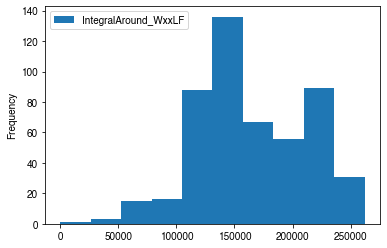

In [44]:

FullOrthoDF.plot.hist(column = 'IntegralAround_WxxLF')

indx =(FullOrthoDF.IntegralAround_WxxLF<ActivityThresh)
print('%i Full length orthologs have average integral near WxxLF below Activity Threshold'%sum(indx))
FullOrthoDF[indx]

Ttest_indResult(statistic=-0.48686219308031226, pvalue=0.6273904418047294)


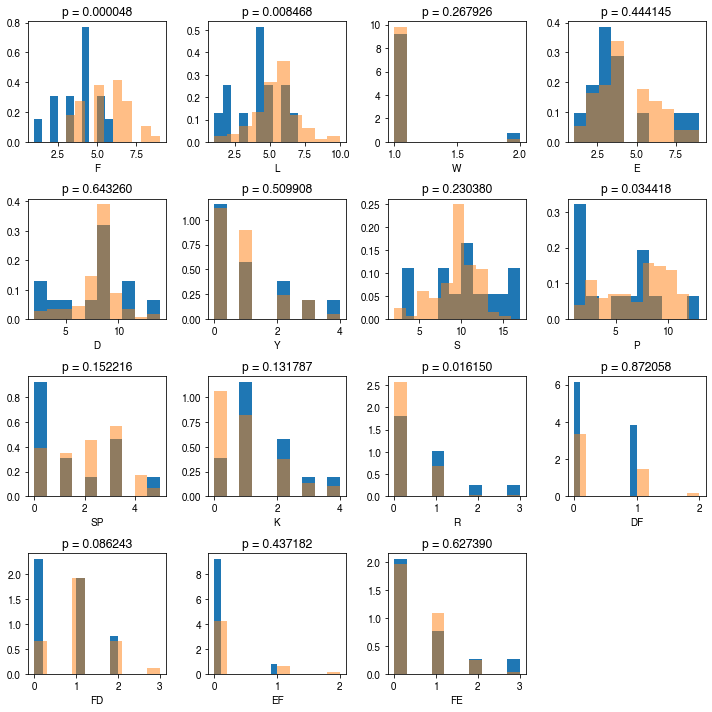

In [45]:
# look at AA abundances in the very local environment around WxxLF.
features = ['F','L','W','E','D','Y','S','P','SP','K','R','DF','FD','EF','FE']
fig, ax1 = plt.subplots(figsize=(10,10))
for j, feature in enumerate(features):
    tempcount =[]
    for i, row in top.iterrows():
        tempseq = row.substring
        tempcount.append(tempseq.count(feature))
    top[feature] = tempcount
    tempcount2 =[]
    for i, row in bot.iterrows():
        tempseq = row.substring
        tempcount2.append(tempseq.count(feature))
    bot[feature] = tempcount2
    test = scipy.stats.ttest_ind(tempcount,tempcount2)
    plt.subplot(4,4,j+1)
    plt.hist(bot[feature],density=1)
    plt.hist(top[feature],alpha=.5,density=1)
    plt.xlabel(feature)
    plt.title('p = %f'%test[1])
plt.tight_layout()
print(test)

# Edit distance of 138 unique central sequences

In [8]:
# alignment distance vs activity difference 
# very slow to run.
plt.rcParams["font.family"] = "Helvetica"

UniqueCentralRegionsDF = pd.read_csv('ExportedSeqLists/Activity_at_WxxLF_LocalSeqs_uniques/AllSeqs_IntegralAround_WxxLF_-50_+20.csv')
UniqueCentralRegionsDF = UniqueCentralRegionsDF.rename(columns={'substring':'CAD_seq'})
UniqueCentralRegionsDF['ADseq']=UniqueCentralRegionsDF.CAD_seq
import editdistance
def Calc_AlignmentDists(tempDF):
    mindists ={}
#     minExpDiffs = {}
    
    Seqlist = tempDF.ADseq.values
    AlignmentDists = np.zeros((len(Seqlist),len(Seqlist)))
    print (AlignmentDists.shape)
    ActDict = dict(zip(masterDF.ADseq,masterDF[Activity]))
    for i, seq1 in enumerate(Seqlist):
        tempdists = []
#         expdists = []
        for j, seq2 in enumerate(Seqlist):
            if i>j:
                tempDist =editdistance.eval(seq1,seq2)
                tempdists.append(tempDist)
#                 expdists.append(np.abs(ActDict[seq1]-ActDict[seq2]))
                AlignmentDists[i,j]=tempDist
        if i>0:
            indx = min(tempdists)==tempdists
            mindists[seq1] =(min(tempdists))
#             minExpDiffs[seq1] = (expdists[indx])
    return AlignmentDists, mindists

AlignmentDists, minDistances = Calc_AlignmentDists(UniqueCentralRegionsDF)

(138, 138)


In [9]:
max(np.max(AlignmentDists,axis=1))

62.0

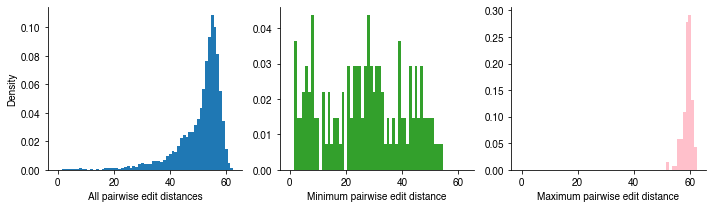

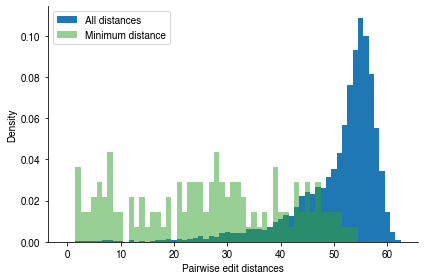

In [10]:
fig, ax1 = plt.subplots(figsize=(10,3))

bins =np.linspace(-.5,62.5,64)
temp2 = np.ravel(AlignmentDists)
temp3 = temp2[temp2>0]
plt.subplot(1,3,1)
plt.hist(temp3,bins,color=darkblue,label='All distances',density=1)
# plt.yscale('log')
# plt.ylim([3e-4,4e-1]),plt.yticks([1e-4, 1e-3,1e-2,1e-1])
plt.ylabel('Density')
plt.xlabel('All pairwise edit distances')


plt.subplot(1,3,2)

temp3 = minDistances.values()
plt.hist(temp3,bins,alpha=1,color=darkgreen,label='Min distance',density=1)
# plt.yscale('log')
# plt.ylim([3e-4,4e-1]),plt.yticks(ticks=[1e-4, 1e-3,1e-2,1e-1],labels=[])
plt.xlabel('Minimum pairwise edit distance')

plt.subplot(1,3,3), 
temp3 = np.max(AlignmentDists,axis=1)
temp3 = temp3[1:]
plt.hist(temp3,bins,alpha=1,color='pink',label='Max distance',density=1)
# plt.yscale('log')
# plt.ylim([3e-4,4e-1]),plt.yticks(ticks=[1e-4, 1e-3,1e-2,1e-1],labels=[])
plt.xlabel('Maximum pairwise edit distance')
plt.tight_layout()
sns.despine()
# plt.savefig('Figures/PaperFigs/Supp/EditDistances_HistSummary.pdf')
plt.show()


#######
# fig, ax1 = plt.subplots(figsize=(10,3))
bins =np.linspace(-.5,62.5,64)
temp2 = np.ravel(AlignmentDists)
temp3 = temp2[temp2>0]
plt.hist(temp3,bins,color=darkblue,label='All distances',density=1)
# plt.yscale('log')
# plt.ylim([3e-4,4e-1]),plt.yticks([1e-4, 1e-3,1e-2,1e-1])
plt.ylabel('Density')
plt.xlabel('Pairwise edit distances')

temp3 = minDistances.values()
plt.hist(temp3,bins,alpha=.5,color=darkgreen,label='Minimum distance',density=1)
# plt.yscale('log')
# plt.ylim([3e-4,4e-1]),plt.yticks(ticks=[1e-4, 1e-3,1e-2,1e-1],labels=[])
plt.legend()
plt.tight_layout()
sns.despine()
plt.savefig('Figures/PaperFigs/Supp/Uniqu138_CAAD_EditDistances_HistSummary_linear.pdf')
plt.show()

# edit distance of the Synthetic ADs

In [18]:
SyntheticADs_MM = pd.read_csv('../Data/DesignFiles/Synthetics_NegMarked.csv')
print(SyntheticADs_MM.shape)
Synthetics_NoControls = SyntheticADs_MM[~(SyntheticADs_MM.NegCtrl)]
Synthetics_NoControls=Synthetics_NoControls.rename(columns={'AAseq':'ADseq'})
Synthetics_NoControls.shape
SynthAlignmentDists, SynthminDistances = Calc_AlignmentDists(Synthetics_NoControls)

(18954, 2)
(18750, 18750)


[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5
 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5]


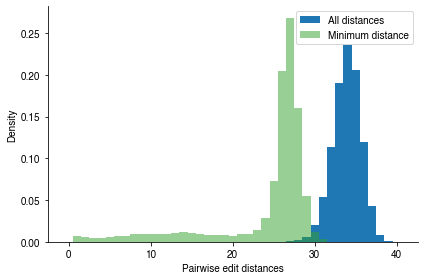

In [32]:
bins =np.linspace(-.5,40.5,42)
print(bins)
temp2 = np.ravel(SynthAlignmentDists)
temp3 = temp2[temp2>0]
plt.hist(temp3,bins,color=darkblue,label='All distances',density=1)
# plt.yscale('log')
# plt.ylim([3e-4,4e-1]),plt.yticks([1e-4, 1e-3,1e-2,1e-1])
plt.ylabel('Density')
plt.xlabel('Pairwise edit distances')

temp3 = SynthminDistances.values()
plt.hist(temp3,bins,alpha=.5,color=darkgreen,label='Minimum distance',density=1)
# plt.yscale('log')
# plt.ylim([3e-4,4e-1]),plt.yticks(ticks=[1e-4, 1e-3,1e-2,1e-1],labels=[])
plt.legend()
plt.tight_layout()
sns.despine()
plt.savefig('Figures/PaperFigs/Supp/SyntheticADs_EditDistances_HistSummary_linear.pdf')
plt.show()

In [23]:
def Calc_AlignmentDists_2DFs(tempDF1,tempDF2):
    mindists ={}
#     minExpDiffs = {}
    
    Seqlist1 = tempDF1.ADseq.values
    Seqlist2 = tempDF2.ADseq.values
    AlignmentDists = np.zeros((len(Seqlist1),len(Seqlist2)))
    print (AlignmentDists.shape)
    for i, seq1 in enumerate(Seqlist1):
        tempdists = []
#         expdists = []
        for j, seq2 in enumerate(Seqlist2):
            if i>j:
                tempDist =editdistance.eval(seq1,seq2)
                tempdists.append(tempDist)
#                 expdists.append(np.abs(ActDict[seq1]-ActDict[seq2]))
                AlignmentDists[i,j]=tempDist
        if i>0:
            indx = min(tempdists)==tempdists
            mindists[seq1] =(min(tempdists))
#             minExpDiffs[seq1] = (expdists[indx])
    return AlignmentDists, mindists
tempDF1 = masterDF[masterDF.Recovered]

AlignmentDists2DFs, mindists2DFs = Calc_AlignmentDists_2DFs(tempDF1,Synthetics_NoControls)

(18947, 18750)


[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5
 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5]


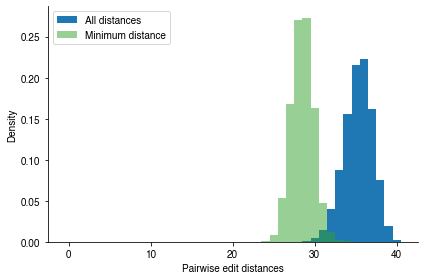

In [34]:
bins =np.linspace(-.5,40.5,42)
print(bins)
temp2 = np.ravel(AlignmentDists2DFs)
temp3 = temp2[temp2>0]
plt.hist(temp3,bins,color=darkblue,label='All distances',density=1)
# plt.yscale('log')
# plt.ylim([3e-4,4e-1]),plt.yticks([1e-4, 1e-3,1e-2,1e-1])
plt.ylabel('Density')
plt.xlabel('Pairwise edit distances')

temp3 = mindists2DFs.values()
plt.hist(temp3,bins,alpha=.5,color=darkgreen,label='Minimum distance',density=1)
# plt.yscale('log')
# plt.ylim([3e-4,4e-1]),plt.yticks(ticks=[1e-4, 1e-3,1e-2,1e-1],labels=[])
plt.legend()
plt.tight_layout()
sns.despine()
plt.savefig('Figures/PaperFigs/Supp/Gcn4_toSynthetics_EditDistances_HistSummary_linear.pdf')
plt.show()

# project heatmap onto Multiple Sequence Alignment (MSA)

In [46]:

## SCript from Alex Holehose to process FASTA file.d
## 20150828
##
def readMSA(SEQUENCE_FILENAME):
    """
    Usage:

    SEQUENCE_FILENAME = standard reference proteome file
    OUTPUTNAME        = file which is to be generated

    e.g.

    from fasta2oneline import fasta2oneline
    fasta2oneline('UP000005640_9606.fasta', 'my_snazzy_proteome.txt')
    """

    print ("Reading and parsing sequences from [%s]"%(SEQUENCE_FILENAME))
    with open(SEQUENCE_FILENAME, 'r') as fh:
        contents = fh.readlines()
        
    ID=contents[0].strip()[1:]#.split('|')[0]
    sequence = ''

    sequences = {}

    for line in contents[1:]:
        if line[0] == ">":
            sequences[ID]=sequence # add previous seq to Dictionary
            ID=line.strip()[1:]#.split('|')[1]
            sequence = ''

        else:
            sequence = sequence+line.strip()

    # finally append final sequence
    sequences[ID] = sequence

    print ("Parsed sequence file (found [%i] sequences)" % len(sequences))

#     print "Writing one sequence per line to [%s]" %(OUTPUTNAME)
#     with open(OUTPUTNAME, 'w') as fh:
#         for ID in sequences:
#             seq=sequences[ID]
#             #fh.write('%s\n'%seq)
#             fh.write('%s'%seq)


    print( "DONE")
    return sequences 
MSA = readMSA('../Data/Giovani_MSA/500YeastGcn4Alignment.fasta')
len(MSA)

Reading and parsing sequences from [../Data/Giovani_MSA/500YeastGcn4Alignment.fasta]
Parsed sequence file (found [500] sequences)
DONE


500

In [47]:
# sort the MSA by Integratl of activity near WxxLF
counter =0
speciesorder =[]
alignmentwidth = 2690
MSAplotmatrix = np.zeros((502,alignmentwidth)) #seqs, alignment lenth 


sortedDF = FullOrthoDF.sort_values(by= 'IntegralAround_WxxLF',ascending=False)
sortedDF = sortedDF.reset_index()

for j,row in (sortedDF.iterrows()):
    key = row.SpeciesName
    if key in MSA.keys(): #for each sequence in the MSA
        MSAmember = MSA[key] # MSA sequence with '-' gaps
        speciesorder.append(key)
        counter +=1
        protein = row.Seq # ortholog sequence
        tempSmoothActivity = row.SmoothedActivitesLoess
        currentposition = 0
        for k, MSApos in enumerate(MSAmember):
            if MSApos != '-':
                MSAplotmatrix[j,k] = tempSmoothActivity[currentposition] #record activity in the master matrix
                currentposition+=1
MSAplotmatrix_SortbyWxxLF = MSAplotmatrix
print('%i matches'%counter)


500 matches


In [48]:
# Keep the MSA in the order it was in 
counter =0
speciesorder =[]
alignmentwidth = 2690
MSAplotmatrix = np.zeros((502,alignmentwidth)) #seqs, alignment lenth 

for key in MSA: #iterage through the species names in order.
#     print(row)
#     if key in MSA.keys(): #for each sequence in the MSA
#         MSAmember = MSA[key] # MSA sequence with '-' gaps
    speciesorder.append(key)
    counter +=1
    MSAmember = MSA[key] # ortholog sequence
    temprow = FullOrthoDF[FullOrthoDF.SpeciesName==key]
    tempSmoothActivity = temprow.SmoothedActivitesLoess.values
    tempSmoothActivity=tempSmoothActivity[0]
    currentposition = 0
    for k, MSApos in enumerate(MSAmember):
        if MSApos != '-':
            MSAplotmatrix[counter,k] = tempSmoothActivity[currentposition] #record activity in the master matrix
            currentposition+=1
MSAplotmatrix_SortbyMSA = MSAplotmatrix

print('%i matches'%counter)

500 matches


In [49]:
# remove sparse rows from MSAplotMatrix
def RemoveSparseColumns(MSAplotmatrix,fraction=0.05):
    print('Orginal matrix has %i species and %i alignment columns' %(MSAplotmatrix.shape))
    MSAplotmatrix_binary = MSAplotmatrix>0
    sumVert = np.sum(MSAplotmatrix_binary,0)
    colindexes = sumVert> (fraction*MSAplotmatrix.shape[0]) # find columns with 
    print ('%i columns are present in more than %.1f percent of sequences' % (sum(colindexes),fraction*100))
    MSAplotmatrix_RemoveInsertions = MSAplotmatrix[:,colindexes]
    print('Returned matrix has %i species and %i alignment columns' %(MSAplotmatrix_RemoveInsertions.shape))
    return MSAplotmatrix_RemoveInsertions
    # for i in range(0,alignmentwidth)
    # MSAplotmatrix_RemoveInsertions = np.delete(MSAplotmatrix_SortbyMSA,colindexes,1)
    # MSAplotmatrix_RemoveInsertions.shape
MSAplotmatrix_SortbyMSA_SparseRemoved = RemoveSparseColumns(MSAplotmatrix_SortbyMSA,fraction=.1)
    
MSAplotmatrix_SortbyMSA_SparseRemoved = RemoveSparseColumns(MSAplotmatrix_SortbyMSA)


Orginal matrix has 502 species and 2690 alignment columns
678 columns are present in more than 10.0 percent of sequences
Returned matrix has 502 species and 678 alignment columns
Orginal matrix has 502 species and 2690 alignment columns
848 columns are present in more than 5.0 percent of sequences
Returned matrix has 502 species and 848 alignment columns


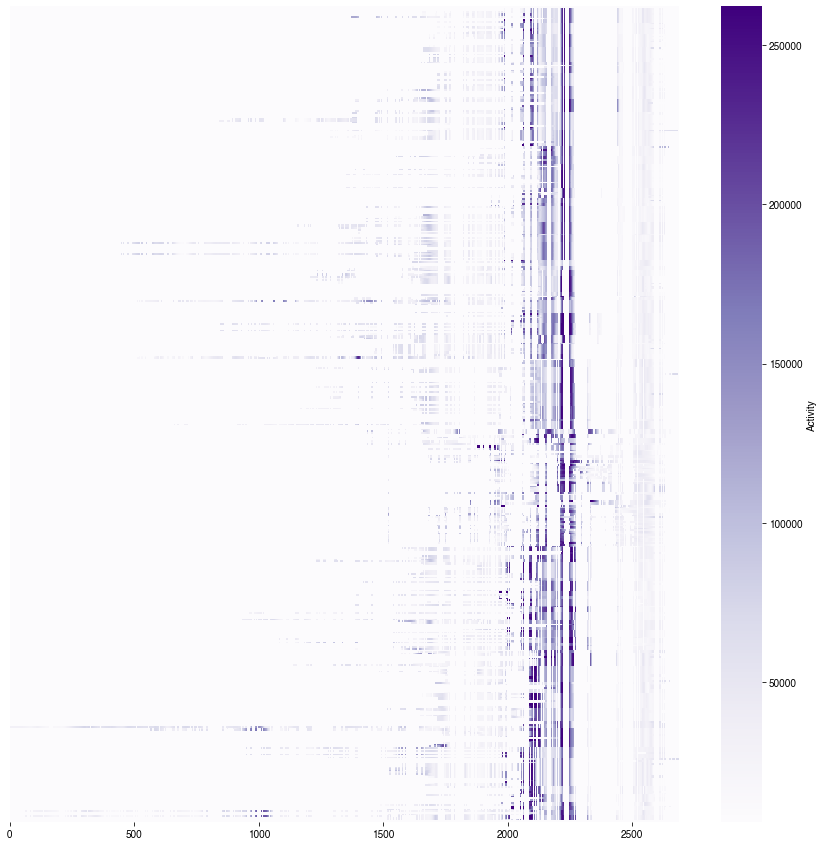

In [50]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(MSAplotmatrix_SortbyMSA,cmap='Purples', vmin=minActivity, vmax=maxActivity,xticklabels=500, yticklabels=False,
                        cbar_kws={'label': 'Activity'})
plt.savefig('Figures/Heatmaps/Heatmap_MSA_SortbyMSA_Purples.pdf')


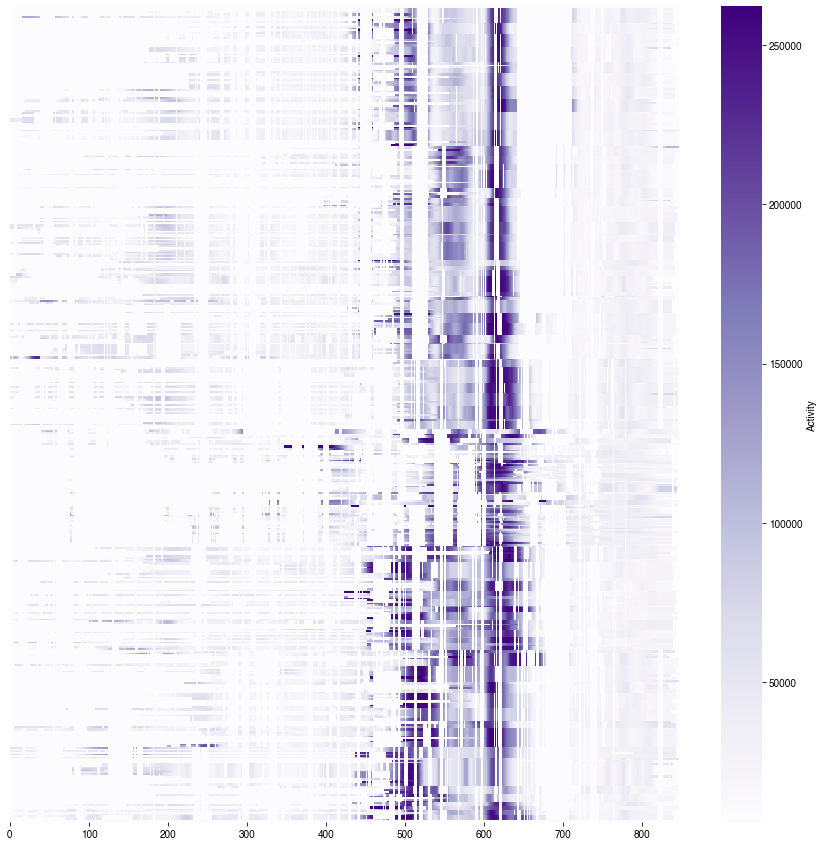

In [51]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(MSAplotmatrix_SortbyMSA_SparseRemoved,cmap='Purples', vmin=minActivity, vmax=maxActivity,xticklabels=100, yticklabels=False,
                        cbar_kws={'label': 'Activity'})
plt.savefig('Figures/Heatmaps/Heatmap_MSA_SortbyMSA_RemoveSparse.pdf')


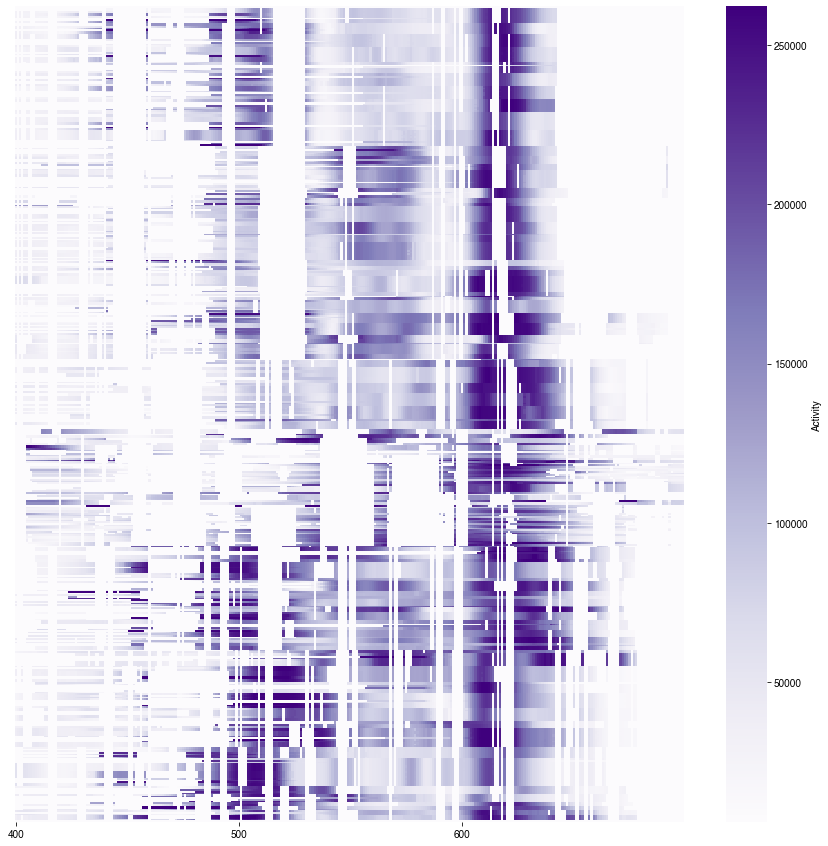

In [52]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(MSAplotmatrix_SortbyMSA_SparseRemoved,cmap='Purples', vmin=minActivity, vmax=maxActivity,xticklabels=100, yticklabels=False,
                        cbar_kws={'label': 'Activity'})
plt.xlim(400,700)
plt.savefig('Figures/Heatmaps/Heatmap_MSA_SortbyMSA_RemoveSparse_Zoom.pdf')


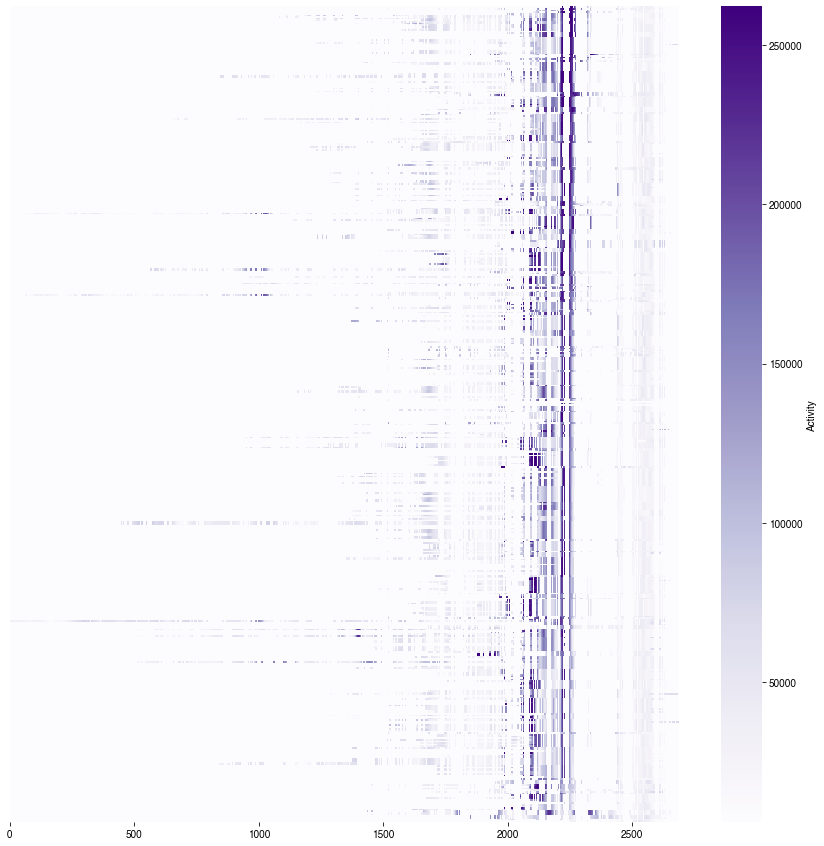

In [53]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(MSAplotmatrix_SortbyWxxLF,cmap='Purples', vmin=minActivity, vmax=maxActivity,xticklabels=500, yticklabels=False,
                        cbar_kws={'label': 'Activity'})

# W is a 2245 (of WxxLF)

plt.savefig('Figures/Heatmaps/Heatmap_MSA_SortActivityWxxLF_Purples.pdf')
# plt.savefig('Figures/Heatmaps/Heatmap_MSA_SortActivityWxxLF_Purples.png')


Orginal matrix has 502 species and 2690 alignment columns
848 columns are present in more than 5.0 percent of sequences
Returned matrix has 502 species and 848 alignment columns


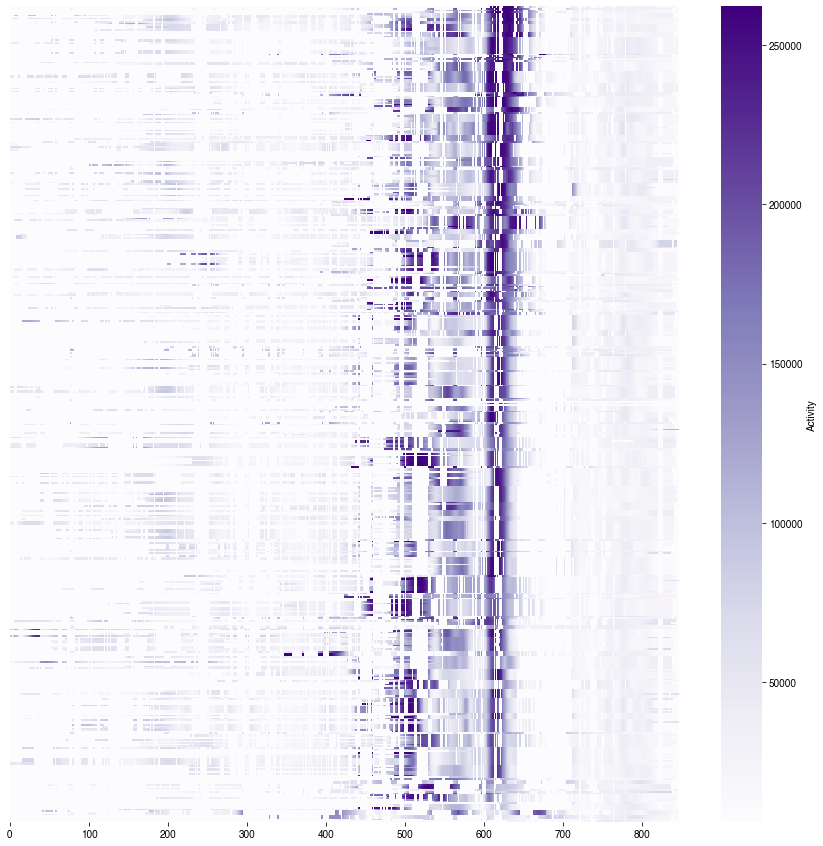

In [54]:
MSAplotmatrix_SortbyWxxLF_SparseRemoved = RemoveSparseColumns(MSAplotmatrix_SortbyWxxLF)
plt.figure(figsize=(15,15))
ax = sns.heatmap(MSAplotmatrix_SortbyWxxLF_SparseRemoved,cmap='Purples', vmin=minActivity, vmax=maxActivity,xticklabels=100, yticklabels=False,
                        cbar_kws={'label': 'Activity'})
plt.savefig('Figures/Heatmaps/Heatmap_MSA_SortbyWxxLF_RemoveSparse.pdf')


(2000.0, 2280.0)

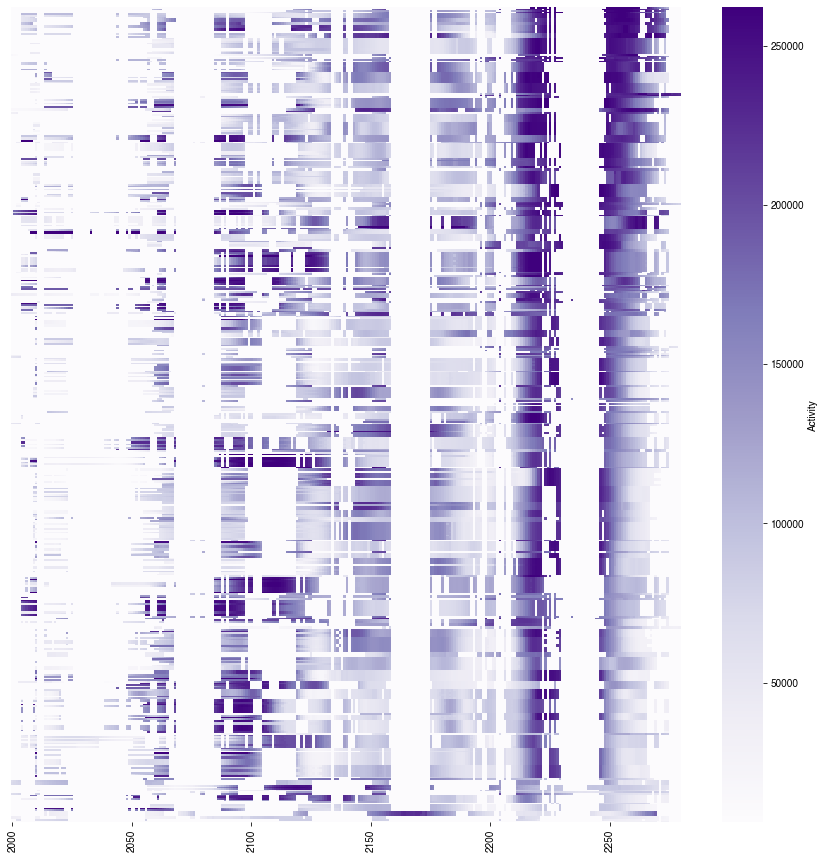

In [55]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(MSAplotmatrix_SortbyWxxLF,cmap='Purples', vmin=minActivity, vmax=maxActivity,xticklabels=50, yticklabels=False,
                        cbar_kws={'label': 'Activity'})
# plt.xlim(1500,2260)
plt.xlim(2000,2280)


# plt.savefig('Figures/Heatmaps/Heatmap_MSA_SortActivityWxxLF_Zoom_Purples.pdf')
# plt.savefig('Figures/Heatmaps/Heatmap_MSA_SortActivityWxxLF_Zoom_Purples.png')


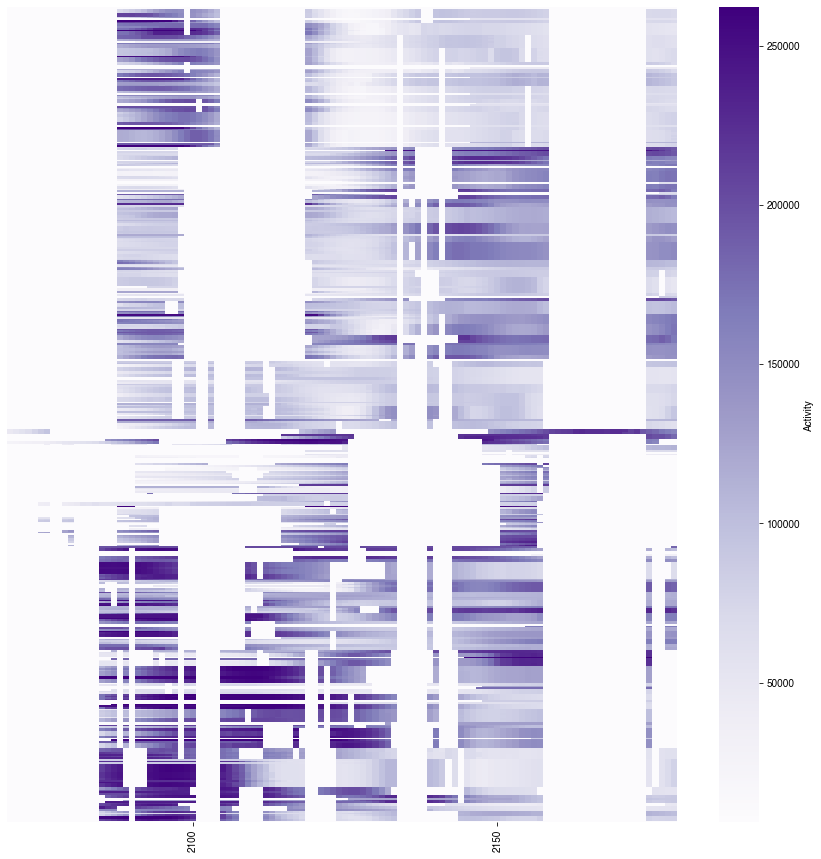

In [56]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(MSAplotmatrix,cmap='Purples', vmin=minActivity, vmax=maxActivity,xticklabels=50, yticklabels=False,
                        cbar_kws={'label': 'Activity'})
plt.xlim(2075,2162)
# plt.ylim(400,500)
plt.xlim(2070,2180)


# plt.savefig('Figures/Heatmaps/Heatmap_MSA_SortActivityWxxLF_Zoom_Purples.pdf')
plt.savefig('Figures/Heatmaps/Heatmap_MSA_SortActivityWxxLF_Zoom_Purples.png')


In [57]:
# N =100
# tempDict = dict(zip(sortedDF.SpeciesName[0:N],sortedDF.Seq[0:N]))
# protfasta.write_fasta(tempDict,'ExportedSeqLists/FullLengthOrthologs/FullLength_SortByActivityAtWxxLF_top%i.fasta'%N)
# tempDict = dict(zip(sortedDF.SpeciesName,sortedDF.Seq))
# protfasta.write_fasta(tempDict,'ExportedSeqLists/FullLengthOrthologs/FullLength_SortByActivityAtWxxLF_all.fasta')
# tempDict = dict(zip(sortedDF.SpeciesName[-N:],sortedDF.Seq[-N:]))
# protfasta.write_fasta(tempDict,'ExportedSeqLists/FullLengthOrthologs/FullLength_SortByActivityAtWxxLF_bottom%i.fasta'%N)


### Insertions less active than the background distribution

There are 2690 positions in the alignemnt 
There are 880 positions with less than 1.00 percent of sequences, (32.71 percent of all positions)
Mean of Insersions = 43695.344578 
Mean of All Other positions = 63394.549487 
Ttest_indResult(statistic=-26.73395148662783, pvalue=2.3972860505755456e-136)


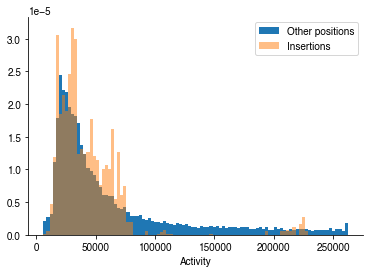

In [58]:
### Are the insertions more active than expected by chance?
NumSeqs, NumPositions = MSAplotmatrix.shape
NonGapPositions = MSAplotmatrix >0
NumEntriesAtEachPosition = np.sum(NonGapPositions,axis =0)
print('There are %i positions in the alignemnt '%len(NumEntriesAtEachPosition))
Threshold = 5 # 1% 
PositionsWithRareInsertions = NumEntriesAtEachPosition < Threshold
NumPositionsWithRareInsertions =sum(PositionsWithRareInsertions)
print('There are %i positions with less than %.2f percent of sequences, (%.2f percent of all positions)' %(NumPositionsWithRareInsertions, 100.0*(Threshold/NumSeqs),100.0*NumPositionsWithRareInsertions/NumPositions))

ActivitiesOfPositionsWithRareInsertions = MSAplotmatrix[:,PositionsWithRareInsertions]
ActivitiesOfPositionsWithRareInsertions = np.ravel(ActivitiesOfPositionsWithRareInsertions)
ActivitiesOfPositionsWithRareInsertions =ActivitiesOfPositionsWithRareInsertions[ActivitiesOfPositionsWithRareInsertions !=0]
ActivitiesOfPositionsWithRareInsertions = ActivitiesOfPositionsWithRareInsertions[~np.isnan(ActivitiesOfPositionsWithRareInsertions)]

ActivitiesOfOtherPositions = MSAplotmatrix[:,~PositionsWithRareInsertions]
ActivitiesOfOtherPositions = np.ravel(ActivitiesOfOtherPositions)
ActivitiesOfOtherPositions =ActivitiesOfOtherPositions[ActivitiesOfOtherPositions !=0]
ActivitiesOfOtherPositions = ActivitiesOfOtherPositions[~np.isnan(ActivitiesOfOtherPositions)]

bins = np.linspace(minActivity,maxActivity,100)
plt.hist(ActivitiesOfOtherPositions,bins,density=True,label='Other positions')
plt.hist(ActivitiesOfPositionsWithRareInsertions,bins,alpha=.5,density=True,label= 'Insertions')
plt.legend(),plt.xlabel('Activity')

print('Mean of Insersions = %f '%np.mean(ActivitiesOfPositionsWithRareInsertions))
print('Mean of All Other positions = %f '%np.mean(ActivitiesOfOtherPositions))

ttest = stats.ttest_ind(ActivitiesOfPositionsWithRareInsertions,ActivitiesOfOtherPositions, equal_var=False)
print(ttest)
sns.despine()
# matplotlib.pyplot.text(100000,1,'p =')
plt.savefig('Figures/PaperFigs/Supp/CompareInsertionsToRest.pdf')
plt.show()


# Are there Tiles that are in the DBD that are active? 
# Or start and End?

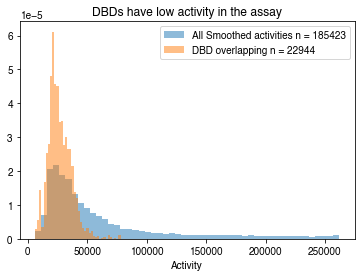

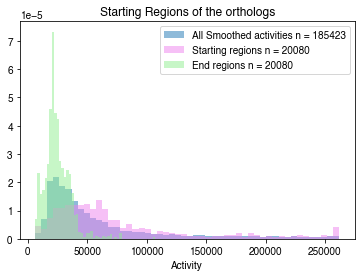

In [59]:
# in smoothened space
# for each TF
DBDseqs =[]
DBDactivities = []
Allactivities =[]
StartActivities =[]
StartSeqs=[]
EndActivites =[]
EndSeqs =[]
for i,TF in FullOrthoDF.iterrows():
    # find DBD region
    # look at activities of the DBD region
    
    fullTFactivities = np.array(TF['SmoothedActivitesLoess'])
    tempActivities = fullTFactivities[TF.DBD_start : TF.DBD_end]
    # export the seqs of all the DBDs
    DBDseqs.append(TF.Seq[TF.DBD_start:TF.DBD_end])
    DBDactivities.extend(tempActivities)
    Allactivities.extend(fullTFactivities)
    StartActivities.extend(fullTFactivities[0:40])
    StartSeqs.append(TF.Seq[0:40])
    EndActivites.extend(fullTFactivities[-40:])
    EndSeqs.append(TF.Seq[-40:])
# make histograms comparing all smoothened activities to DBD smoothened activities
plt.hist(Allactivities,bins =50,alpha=.5,density=True,label='All Smoothed activities n = %i' %len(Allactivities))
plt.hist(DBDactivities,bins =50,alpha=.5,density=True,label='DBD overlapping n = %i' %len(DBDactivities))
plt.xlabel('Activity'),plt.title('DBDs have low activity in the assay')
plt.legend()
plt.savefig('Figures/PaperFigs/DBD_activities_Smoothened.pdf')
plt.show()

plt.hist(Allactivities,bins =50,alpha=.5,density=True,label='All Smoothed activities n = %i' %len(Allactivities))
plt.hist(StartActivities,bins =50,alpha=.5,density=True,color='violet',label='Starting regions n = %i' %len(StartActivities))
plt.hist(EndActivites,bins =50,alpha=.5,density=True,color='lightgreen',label='End regions n = %i' %len(EndActivites))
plt.xlabel('Activity'),
plt.title('Starting Regions of the orthologs')
plt.legend()
plt.savefig('Figures/PaperFigs/StartEnd_activities_Smoothened.pdf')

plt.show()


In [60]:
#repeat for all tiles
BoolColumn = np.zeros(len(masterDF))
for i, tile in masterDF.iterrows():
    for DBD in DBDseqs:
# test if they are contained in any of the DBD seqs.
        hits = re.search(tile.ADseq,DBD)
        if hits:
            BoolColumn[i]=1
            continue    
# create column to flag tiles a 'inDBD'
masterDF['inDBD']=BoolColumn


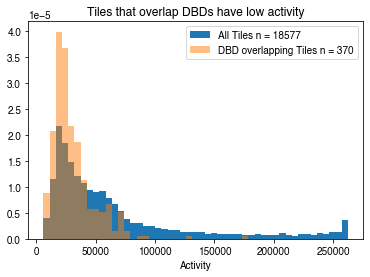

There are 2 titles that overlap the DBD that are active
There are 1 titles that overlap the DBD that have high activity


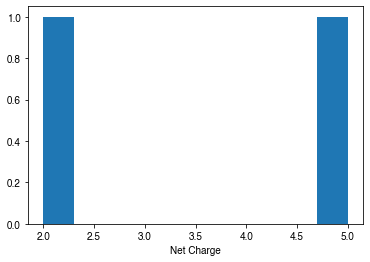

In [61]:
# overlay histogram of activities inside or outside the DBD
indx = masterDF.Recovered & (masterDF.inDBD==0)
tempDF = masterDF[indx]
bins = np.linspace(minActivity,maxActivity,50)
mylabel = 'All Tiles n = %i' % sum(indx)
plt.hist(tempDF[Activity],bins,density=True,label=mylabel)
indx = masterDF.Recovered & (masterDF.inDBD==1)
DBD_DF = masterDF[indx]
mylabel = 'DBD overlapping Tiles n = %i' % sum(indx)
plt.hist(DBD_DF[Activity],bins,alpha=.5,density=True,label=mylabel)
plt.xlabel('Activity'),plt.title('Tiles that overlap DBDs have low activity')
plt.legend()
plt.savefig('Figures/PaperFigs/DBD_activities_Tiles.pdf')
plt.show()
indx = masterDF.Recovered & (masterDF.inDBD==1) & (masterDF[Activity]>ActivityThresh)
print('There are %i titles that overlap the DBD that are active'%sum(indx))
tempDF = masterDF[indx]
indx = masterDF.Recovered & (masterDF.inDBD==1) &(masterDF[Activity]>150000)
print('There are %i titles that overlap the DBD that have high activity'%sum(indx))
plt.hist(tempDF.Charge)
plt.xlabel('Net Charge')
plt.show()

In [62]:
#repeat for all tiles
BoolColumn = np.zeros(len(masterDF))
for i, tile in masterDF.iterrows():
    for DBD in StartSeqs:
# test if the tiles is contained in any of the Ortholog Starting seqs.
        hits = re.search(tile.ADseq,DBD)
        if hits:
            BoolColumn[i]=1
            continue    
# create column to flag tiles a 'inDBD'
masterDF['atStart']=BoolColumn

#repeat for all tiles
BoolColumn = np.zeros(len(masterDF))
for i, tile in masterDF.iterrows():
    for DBD in EndSeqs:
# test if the tiles is contained in any of the Ortholog Starting seqs.
        hits = re.search(tile.ADseq,DBD)
        if hits:
            BoolColumn[i]=1
            continue    
# create column to flag tiles a 'inDBD'
masterDF['atEnd']=BoolColumn



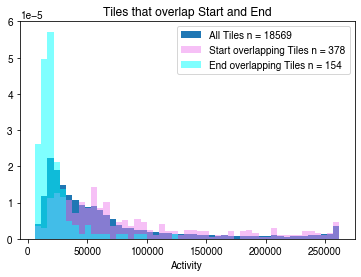

There are 118 titles that overlap the TF starts that are active
There are 96 titles that overlap the TF starts that are active and do not have a W
There are 63 titles that overlap the TF starts that have high activity
There are 49 titles that overlap the TF starts that  have high activity and do not have a W
/nThere are 0 titles that overlap the TF End that have high activity

There are 394 unique START seqs
There are 178 unique END seqs


In [63]:
# overlay histogram of activities at Start of TF
indx = masterDF.Recovered & (masterDF.atStart==0)
tempDF = masterDF[indx]
bins = np.linspace(minActivity,maxActivity,50)
mylabel = 'All Tiles n = %i' % sum(indx)
plt.hist(tempDF[Activity],bins,density=True,label=mylabel)
indx = masterDF.Recovered & (masterDF.atStart==1)
Start_DF = masterDF[indx]
mylabel = 'Start overlapping Tiles n = %i' % sum(indx)
plt.hist(Start_DF[Activity],bins,color='violet',alpha=.5,density=True,label=mylabel)

indx = masterDF.Recovered & (masterDF.atEnd==1)
End_DF = masterDF[indx]
mylabel = 'End overlapping Tiles n = %i' % sum(indx)
plt.hist(End_DF[Activity],bins,color='cyan',alpha=.5,density=True,label=mylabel)

plt.xlabel('Activity'),plt.title('Tiles that overlap Start and End')
plt.legend()
plt.savefig('Figures/PaperFigs/StartEnd_activities_Tiles.pdf')

plt.show()

indx = masterDF.Recovered & (masterDF.atStart==1) & (masterDF[Activity]>ActivityThresh)
print('There are %i titles that overlap the TF starts that are active'%sum(indx))
indx = masterDF.Recovered & (masterDF.atStart==1) & (masterDF[Activity]>ActivityThresh)&(masterDF['W']==0)
print('There are %i titles that overlap the TF starts that are active and do not have a W'%sum(indx))

indx = masterDF.Recovered & (masterDF.atStart==1) &(masterDF[Activity]>150000)
print('There are %i titles that overlap the TF starts that have high activity'%sum(indx))
indx = masterDF.Recovered & (masterDF.atStart==1) & (masterDF[Activity]>150000)&(masterDF['W']==0)
print('There are %i titles that overlap the TF starts that  have high activity and do not have a W'%sum(indx))


indx = masterDF.Recovered & (masterDF.atEnd==1) &(masterDF[Activity]>150000)
print('/nThere are %i titles that overlap the TF End that have high activity'%sum(indx))
# plt.hist(tempDF.Charge)
# plt.xlabel('Net Charge')
# plt.show()

print()
print('There are %i unique START seqs'%len(set(StartSeqs)))
print('There are %i unique END seqs'%len(set(EndSeqs)))

# Export the heatmap data for plotting on the tree

In [64]:
SumanthOrthologList = protfasta.read_fasta('../Data/DesignFiles/Gcn4_OrthologSequences_Sumanth_Aug2020.fa',expect_unique_header=False,duplicate_record_action='ignore')
SumanthDF = pd.DataFrame.from_dict(SumanthOrthologList,orient='index')
SumanthDF=SumanthDF.rename(columns={0:'Sequence'})
SumanthDF['Fullname'] = SumanthDF.index
SumanthDF

Sequence  \
Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g       MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQA...   
Sordariomycetes_jgi|Acral2|2027520|fgenesh1_pg....  MWLVVRAGPSPLLQDLAARCHIDGMSMPLLHFDPPDFPLTGVALGI...   
Sordariomycetes_jgi|Acral2|2034848|fgenesh1_kg....  MSITELDDFTGFEGGASTAYSSPGAPAVFDLPGASNHVGTISPQDL...   
Sordariomycetes_jgi|Acral2|2034849|fgenesh1_kg....  MSITGNYNQHFGAAGIISSHNYVLSELDDFTGFEGGASTAYSSPGA...   
Sordariomycetes_jgi|Acral2|2042123|fgenesh1_pm....  MSITGNYNQHFGAAGIISSHNYVLSELDDFTGFEGGASTAYSSPGA...   
...                                                                                               ...   
Cimm_XP_012214147.1_CoccidioidesImmitisRS           MSTSNLPLDIGTLLDLSTDQFVEDLGSSSHSSLLDQDQLDQLINFN...   
Cpos_XP_003070205.1_CoccidioidesPosadasiiC735       MSTSNLPLGMVSLSASAVRLVANQRPDIGTLLDLSTDQYVEDLGSS...   
Mory_EHA48851.1_MagnaportheOryzae70_15              MNNTSDLGLDDFTAFGGGASAFPSPAMPGVFDIASTTASTMGTVSP...   
Nfis_EAW24893.1_NeosartoryaFischeriNRRL181          MSTPNIAQDMPDFFGLPSNDFGDDFELSTEPTMLSPNQIPTGLMAV...   
Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224   MSSSHIPQVSQIDANDYSFPFTDFSLDLFDLPTQSPLLDDLTSPTS...   

                                                                                             Fullname  
Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g           Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g  
Sordariomycetes_jgi|Acral2|2027520|fgenesh1_pg....  Sordariomycetes_jgi|Acral2|2027520|fgenesh1_pg...  
Sordariomycetes_jgi|Acral2|2034848|fgenesh1_kg....  Sordariomycetes_jgi|Acral2|2034848|fgenesh1_kg...  
Sordariomycetes_jgi|Acral2|2034849|fgenesh1_kg....  Sordariomycetes_jgi|Acral2|2034849|fgenesh1_kg...  
Sordariomycetes_jgi|Acral2|2042123|fgenesh1_pm....  Sordariomycetes_jgi|Acral2|2042123|fgenesh1_pm...  
...                                                                                               ...  
Cimm_XP_012214147.1_CoccidioidesImmitisRS                   Cimm_XP_012214147.1_CoccidioidesImmitisRS  
Cpos_XP_003070205.1_CoccidioidesPosadasiiC735           Cpos_XP_003070205.1_CoccidioidesPosadasiiC735  
Mory_EHA48851.1_MagnaportheOryzae70_15                         Mory_EHA48851.1_MagnaportheOryzae70_15  
Nfis_EAW24893.1_NeosartoryaFischeriNRRL181                 Nfis_EAW24893.1_NeosartoryaFischeriNRRL181  
Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224   Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224  

[1188 rows x 2 columns]

790
476 Orthologs are plotted
Scer is on line 397


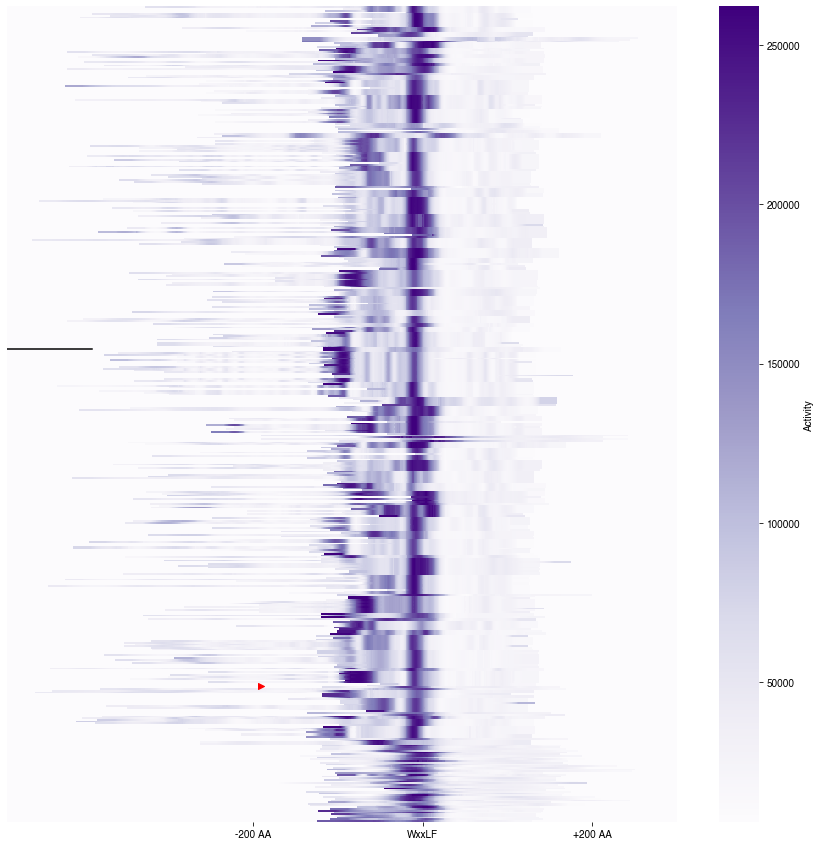

The peak of the sum is at 480
The sum of the peak is 216580


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_25935/3015638587.py:88: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(heatmapMatrix,axis=0))# 20240726


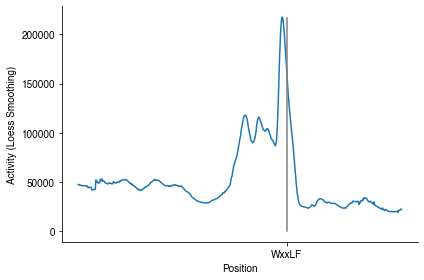

/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_25935/3735056465.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ExportDF['SmoothedActivitesLoess_fullmatrix'] = tempSeries.map(tempDict)


In [65]:
LinActivity = plotFullLengthOrthologHeatMap(ShortMedTFs,'SmoothedActivitesLoess')
tempDict = dict(zip(ShortMedTFs.SpeciesName,LinActivity))

ExportDF = ShortMedTFs[['SpeciesName','Seq']]
tempSeries = ExportDF.SpeciesName

ExportDF['SmoothedActivitesLoess_fullmatrix'] = tempSeries.map(tempDict)
ExportDF.to_csv('../Data/Processed/Heatmap_Loess_ForSumath_UniqueSeqs.csv')
ExportDF.to_pickle('../Data/Processed/Heatmap_Loess_ForSumath_UniqueSeqs')

tempSeries = SumanthDF.Sequence
tempDict = dict(zip(ShortMedTFs.Seq,LinActivity)) 
SumanthDF['SmoothedActivitesLoess_fullmatrix'] = tempSeries.map(tempDict)
SumanthDF.to_csv('../Data/Processed/Heatmap_Loess_ForSumath_MostSeqs.csv')
SumanthDF.to_pickle('../Data/Processed/Heatmap_Loess_ForSumath_MostSeqs')


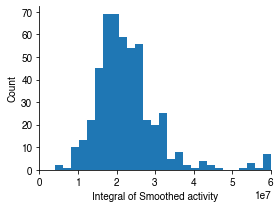

In [66]:
# Integral of smoothed activity
plt.figure(figsize=(4,3))
tempIntegrals =[]
for i, row in FullOrthoDF.iterrows():
    integral = np.sum(row.SmoothedActivitesLoess)
    tempIntegrals.append(integral)
FullOrthoDF['ActivitySum'] = tempIntegrals
FullOrthoDF['ActivitySum'] 
bins = np.linspace(0, 6e7,30)
bins[-1]=1.6e8
plt.hist(FullOrthoDF.ActivitySum,bins)
plt.xlabel('Integral of Smoothed activity')
plt.xlim(0,6e7)
plt.ylabel('Count')
plt.tight_layout()
sns.despine()
plt.savefig('Figures/PaperFigs/Supp/Fulllength_TFs_IntegralofActivity.png')
plt.show()

In [67]:
temp

0     261861.160629
1     258282.100096
2     254594.085430
3     253407.404011
4     249111.784651
          ...      
87    151397.613505
88    151199.893941
89    150340.444799
90    150273.727974
91    150064.484491
Name: IntegralAround_WxxLF, Length: 92, dtype: float64

In [68]:
FullOrthoDF.columns

Index(['SpeciesName', 'Seq', 'Length', 'WxxLF_loc', 'SmoothedActivites',
       'LinearCharge', 'LinearHydrophobicityKD', 'SmoothedActivitesLoess',
       'Disorder', 'DBD_start', 'DBD_end', 'WxxLF bZIP distance', 'SpacerSeq',
       'Spacer_Rg', 'Spacer_End2EndDist', 'Spacer_ScalingExp',
       'Spacer_asphericity', 'Activity_at_WxxLF', 'CenteredXpos',
       'Activity_at_WxxLF_plus20', 'Activity_at_WxxLF_minus20',
       'Activity_at_WxxLF_minus10', 'IntegralAround_WxxLF',
       'Activity_at_WxxLF_plus10', 'DBD_AlignmentDist2Scer', 'substring',
       'substring2', 'ActivitySum'],
      dtype='object')